<h1><b>Introduction</b></h1>
<p>In this notebook, i analyze two models which are GAE and DAG-GNN using both the synthetic dataset (csuite) and the observational set (sachs). Hartemink discretization is also applied to all datasets to experiment with and without discreatization. Moreover, both models are fine-tuned and their performances are compared to check wether or not the fine-tuning improved them.</p>
<p>Both methods are evaluated taking into consideration the adjagency f1 score and the orientation f1 score in each dataset</p>
<p>The models are further compared using the structural Hamming distance (SHD) and true positive rate (TPR).</p>

In [1]:
from data.csuite.csuite_datasets import *
from evaluation.metrics import eval_all
from utils.params import *
from models.example import gae_cs, gae_sachs, gae_tuning
from castle.algorithms import DAG_GNN
from models.dag_gnn import dag_gnn_cs, dag_gnn_sachs, gnn_tuning


2024-05-13 00:04:41,997 - c:\Users\rubin\AppData\Local\Programs\Python\Python311\Lib\site-packages\castle\backend\__init__.py[line:36] - INFO: You can use `os.environ['CASTLE_BACKEND'] = backend` to set the backend(`pytorch` or `mindspore`).
2024-05-13 00:04:42,355 - c:\Users\rubin\AppData\Local\Programs\Python\Python311\Lib\site-packages\castle\algorithms\__init__.py[line:36] - INFO: You are using ``pytorch`` as the backend.


<h1>GAE Model</>

<h4>Paper: <a href="https://arxiv.org/pdf/1911.07420">A Graph Autoencoder Approach to
Causal Structure Learning
</a><br>
Reference: <a href="https://github.com/huawei-noah/trustworthyAI/tree/master/gcastle">gCastle</a></h4>

<p>This method is a generalization of another gradient-based method for causal structure learning called NOTEARS.<br>
The authors of NOTEARS were able to transform the combinatorial optimization problem of
score-based methods into a continuous one for linear structural equation model (SEM), which adopts
the following data generation model: </p>

$ X_{i} = A_{i}^T X + Z_{i}, i = 1, 2, ..., d$ <br>
$ X_{i} $ vector-valued vars. representing the vertices of the DAG <br>
$ Z_{i} $ is an additive noise  <br>
$ A_{i} $ is the coefficient vector, and A = $ [ A_{1}, A_{2}, ... , A_{d} ] $ is the weighted adjacency matrix of the linear SEM.
<p>To ensure the acyclicity of the of the graph, a smooth constraint on A is proposed as: </p>

$ tr(e^{A°A}) - d = 0$
<p>To learn the underlying causal structure, the author considers the regularized score function
consisting of least squares loss and the l1 norm, which, together with the above acyclicity constraint,
leads to a continuous optimization problem:</p>

$ \underset{A}{\textrm{min}} \space \frac{1}{2n} \sum \limits _{j = 1}^{n}  \lVert X^{j} - A^T X^j \rVert _F^{2} + \lambda \lVert A \rVert _1$ subject to the smooth constraint.<br>
where $n$ is the sample size and $ X^{j} $ is the j-th observed sample of X.
<p>The above problem can then be solved by standard numeric optimization methods such as the
augmented Lagrangian.</p>




<p>In the GAE paper, they rewrite the continuous optimization problem above as follows:</p>

$ \underset{A, \theta}{\textrm{min}} \space \frac{1}{2n} \sum \limits _{j = 1}^{n}  \lVert X^{j} - f(X^j, A) \rVert _F^{2} + \lambda \lVert A \rVert _1$ subject to the smooth constraint.<br>
Where $ f(X^j, A) $ denotes the data generating model w.r.t the j-th observed sample of X, and $ \theta $ denotes the parameters associated with $ f $.<br><br>
They extend $ f(X^j, A) $ to handle complex non linear models:<br>
$ f(X^j, A) = g_{2}(A^{T}g_{1}(X^{j}))$ where $ g_{1} $ and $ g_{2} $ are two MLPs with shared weights across all vars. $ X_{i} $.
<p>The above eq. can be rewritten as: </p>

$ H^{(j)} = g_{1}(X^{(j)}) $<br>
$ H^{(j)'} = A^{T}H^{(j)} $ <br>
$ f(X^{(j)}, A) = g_{2}(H^{(j)'}) $ <br><br>
These equations form a GAE trained with reconstruction error where $ g_{1}$ and $ g_{2}$ are the variable-wise encoder and decoder respectively, and the message passing operation is applied at the latent representation $ H^{(j)}$.<br>
In our case, the message passing operation is a linear
transformation $ A^{T} H{(j)} $.

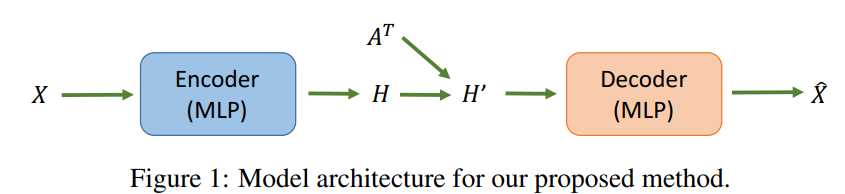

In [39]:
from IPython.display import Image
PATH = "/university/ai_industry/AI_in_Industry_Project/"

Image(filename = PATH + "encoder-decoder.png", width=1000, height=1000)

<p>The final optimization problem is hence to minimize the reconstruction error of the GAE (with l1 penalty): </p>

$ \underset{A, \theta{1},\theta{2}}{\textrm{min}} \space \frac{1}{2n} \sum \limits _{j = 1}^{n}  \lVert X^{j} - (\hat{X}^{(j)}) \rVert _F^{2} + \lambda \lVert A \rVert _1$ subject to the smooth constraint.<br>
Where $ \hat{X}^{(j)} = g_{2}(A^{T} g{_1}(X^{(j)})) $ is the reconstructed output and $ \theta{1}, \theta{2} $ are the MLPs weights associated with $g_{1}$ and $ g_{2}$ respectively.
<p>The optimization problem can be solved using the augmented Lagrangian given by: </p>

$ L_{\rho}(A, \theta_{1}, \theta_{2}, \alpha) = \frac{1}{2n} \sum \limits _{j = 1}^{n}\lVert X^{j} - (\hat{X}^{(j)}) \rVert _F^{2} + \lambda \lVert A \rVert _1 + \alpha h(A) + \frac{\rho}{2} |h(A)|^{2} $,<br><br>
where h(a) is the smooth constraing, $ \alpha$ is the Lagrangian multiplier, and $ \rho$ > 0 is the penalty parameter.
<p>We have then the following update rules: </p>

$ A^{k+1}, \theta_{1}^{k+1}, \theta_{2}^{k+1} = \underset{A, \theta_{1}, \theta_{2}}{\textrm{arg min}}\space L_{\rho^{k}}(A, \theta_{1}, \theta_{2}, \alpha^{k})$, 

$ \alpha^{k+1} = \alpha^{k} + \rho^{k} h(A^{k+1}) $, 

$ \rho^{k+1}:  \begin{cases} 
    \beta\rho^{k}, & if \space |h(A^{k+1}| >= \gamma|h(A^{k})), \\
    \rho^{k}, & \text{otherwise}
\end{cases} $

where $ \beta > 1 $ and $ \gamma < 1 $ are tuning hyperparameters.
<p>This problem is first-order differentiable and we apply gradient descent method with autograd and Adam optimizer.</p>


<h4>Lingauss</h4>

~~~~~ Lingauss WITH DISCRETIZATION ~~~~~
Working on the 60th level of discretization.
Working on the 50th level of discretization.
Working on the 40th level of discretization.
Working on the 30th level of discretization.
Working on the 20th level of discretization.
Working on the 10th level of discretization.
{'adjacency_f1': 1.0, 'orientation_f1': 0.0}


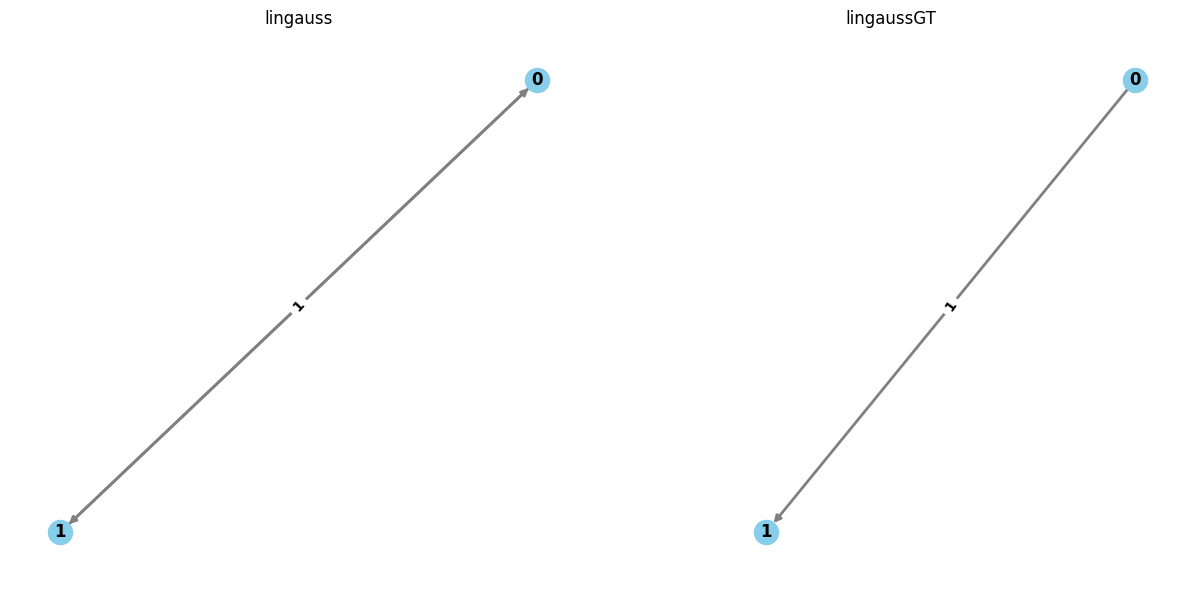

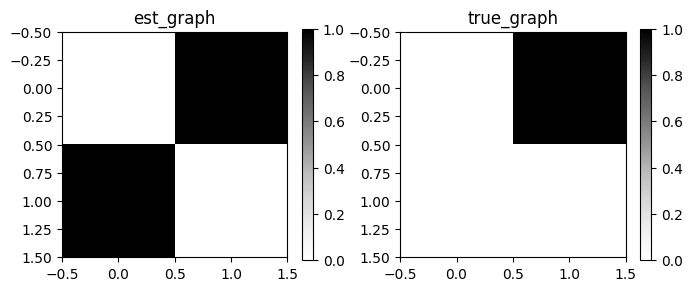




~~~~~ Lingauss WITHOUT DISCRETIZATION ~~~~~
{'adjacency_f1': 1.0, 'orientation_f1': 0.0}


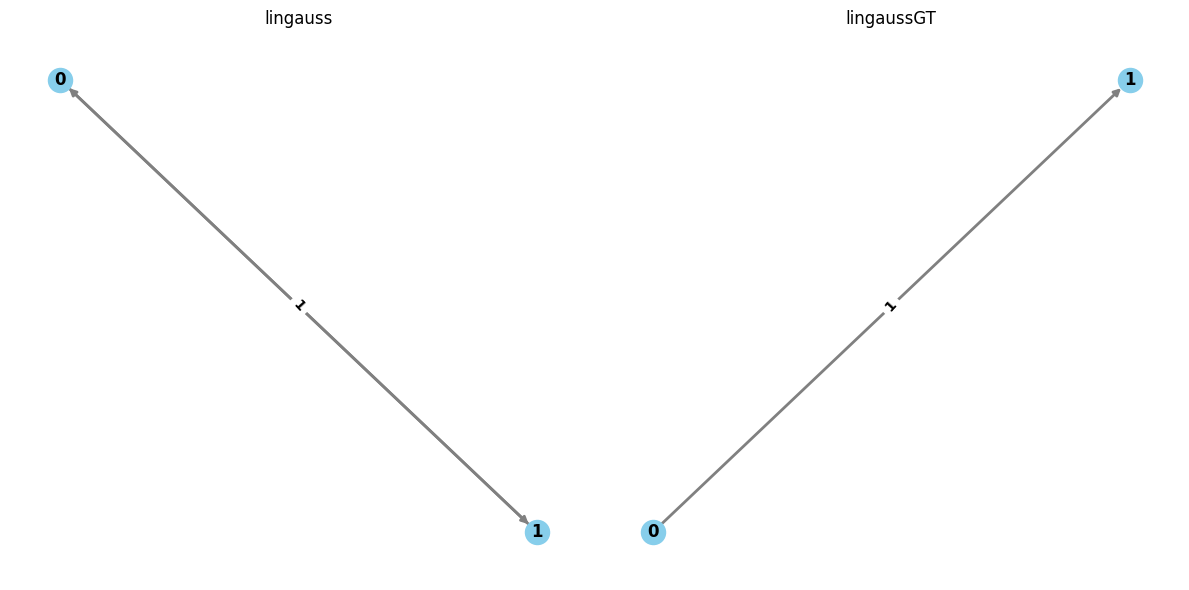

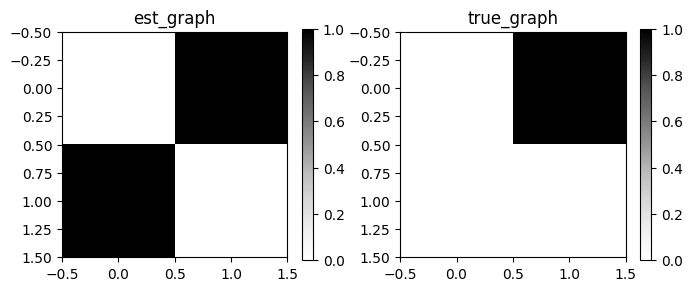

In [2]:
# With discretization
print("~~~~~ Lingauss WITH DISCRETIZATION ~~~~~")
hart_est_adj_lingauss, gt_lingauss, hart_f1_scores_lingauss, hart_metrics_lingauss = gae_cs(dataset=lingauss, apply_hartemink_discretization=True)

# Without discretization
print("\n\n\n~~~~~ Lingauss WITHOUT DISCRETIZATION ~~~~~")
est_adj_lingauss, gt_lingauss, f1_scores_lingauss, metrics_lingauss = gae_cs(dataset=lingauss, apply_hartemink_discretization=False)

<h4>Linexp</h4>

~~~~~ Linexp WITH DISCRETIZATION ~~~~~
Working on the 60th level of discretization.


Working on the 50th level of discretization.
Working on the 40th level of discretization.
Working on the 30th level of discretization.
Working on the 20th level of discretization.
Working on the 10th level of discretization.
{'adjacency_f1': 1.0, 'orientation_f1': 0.0}


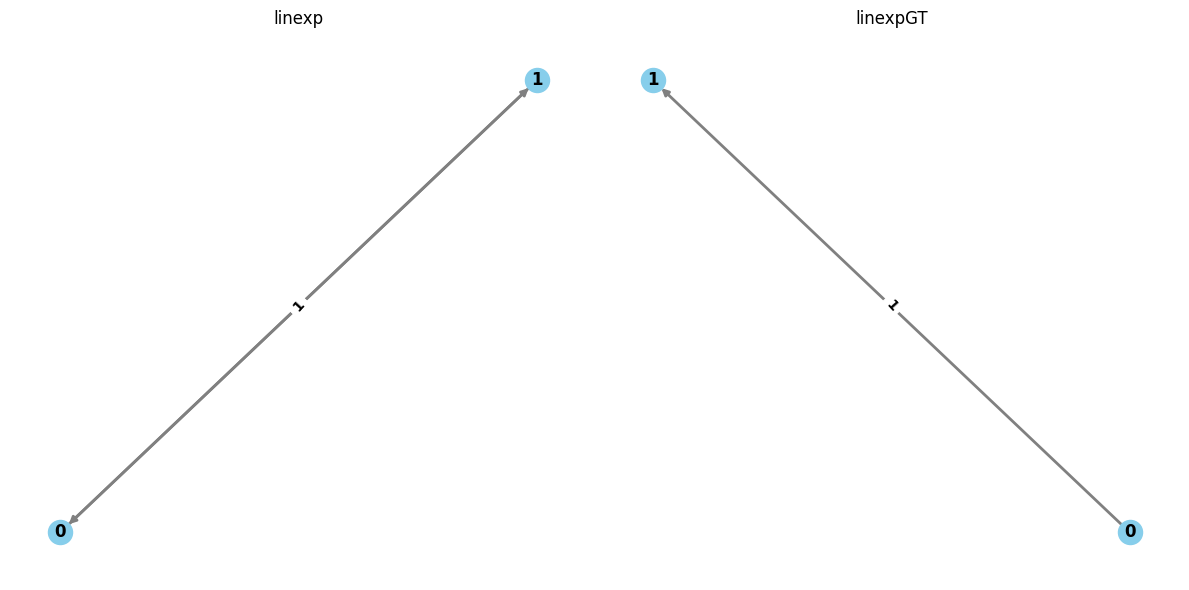

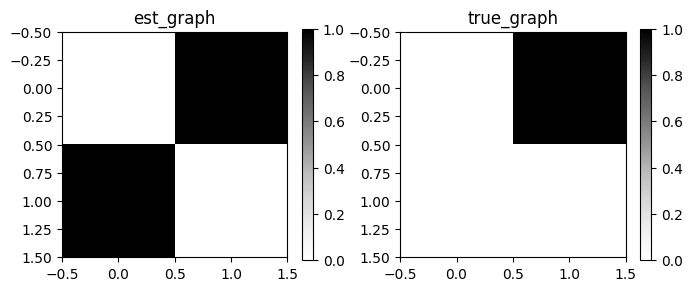




~~~~~ Linexp WITHOUT DISCRETIZATION ~~~~~
{'adjacency_f1': 1.0, 'orientation_f1': 0.0}


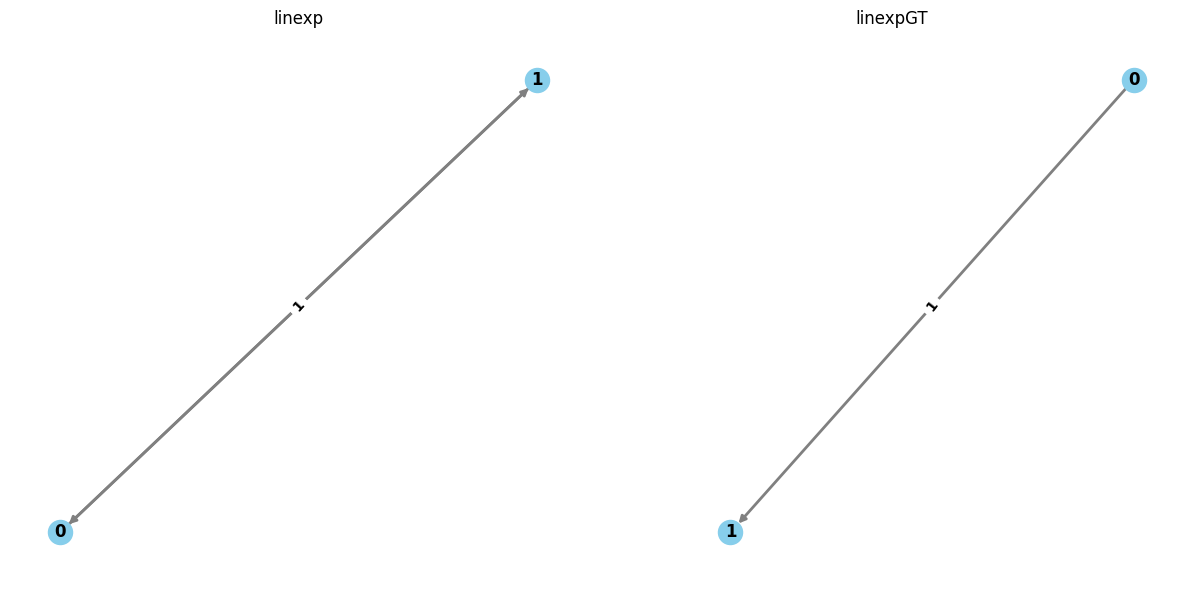

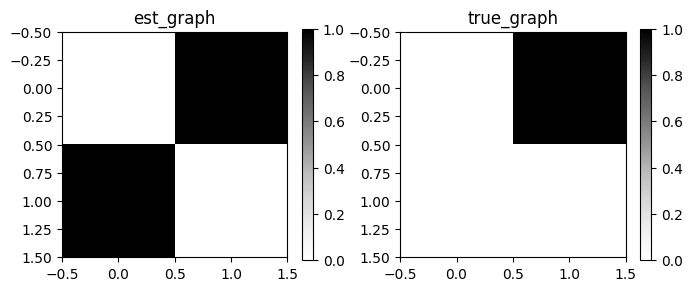

In [3]:
# With discretization
print("~~~~~ Linexp WITH DISCRETIZATION ~~~~~")
hart_est_adj_linexp, gt_linexp, hart_f1_scores_linexp, hart_metrics_linexp = gae_cs(dataset=linexp, apply_hartemink_discretization=True)

# Without discretization
print("\n\n\n~~~~~ Linexp WITHOUT DISCRETIZATION ~~~~~")
est_adj_linexp, gt_linexp, f1_scores_linexp, metrics_linexp = gae_cs(dataset=linexp, apply_hartemink_discretization=False)

<h4>nonLinGauss</h4>

~~~~~ NonLingauss WITH DISCRETIZATION ~~~~~
Working on the 60th level of discretization.
Working on the 50th level of discretization.
Working on the 40th level of discretization.
Working on the 30th level of discretization.
Working on the 20th level of discretization.
Working on the 10th level of discretization.
{'adjacency_f1': 1.0, 'orientation_f1': 1.0}


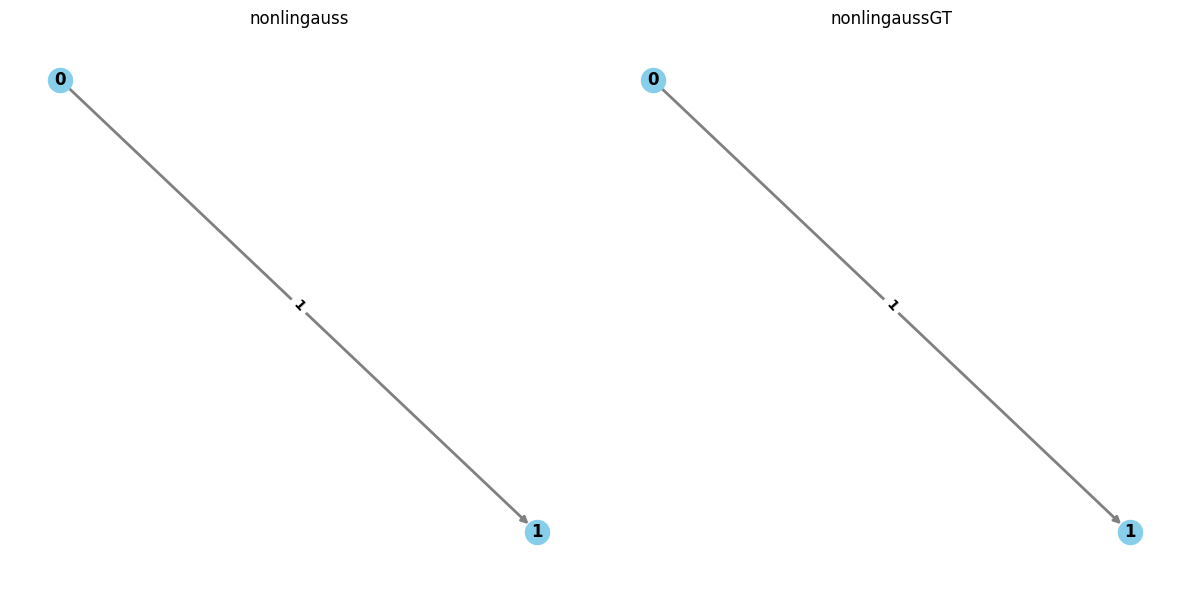

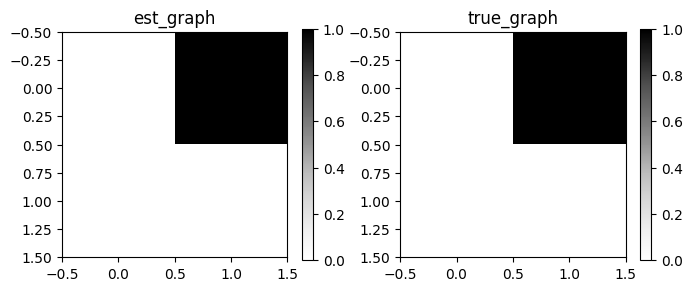




~~~~~ NonLingauss WITHOUT DISCRETIZATION ~~~~~
{'adjacency_f1': 1.0, 'orientation_f1': 0.0}


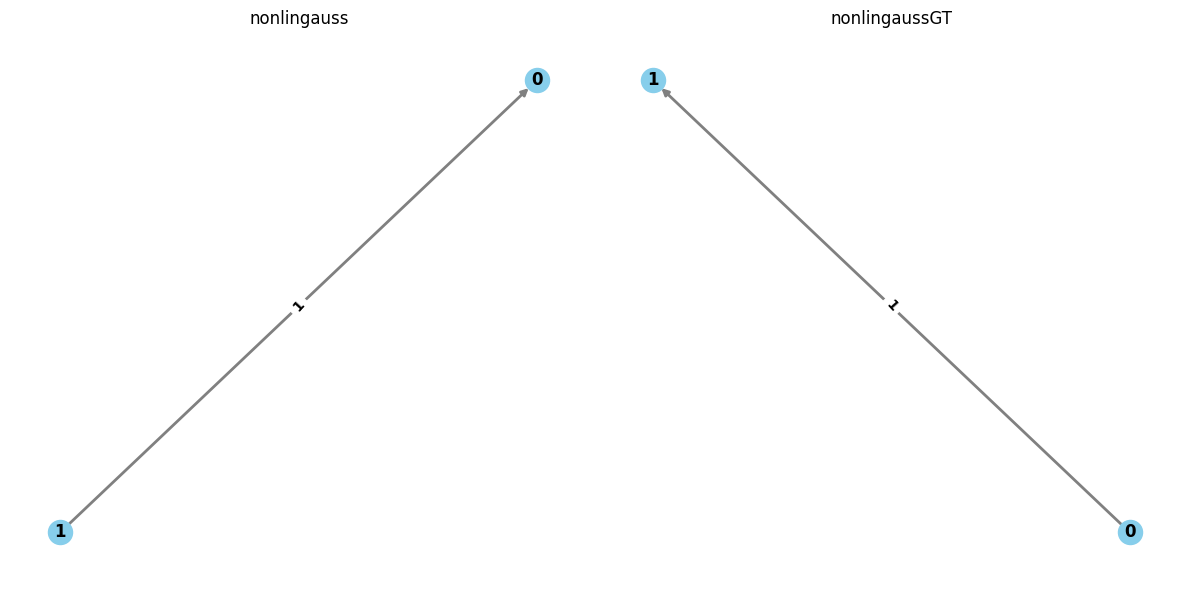

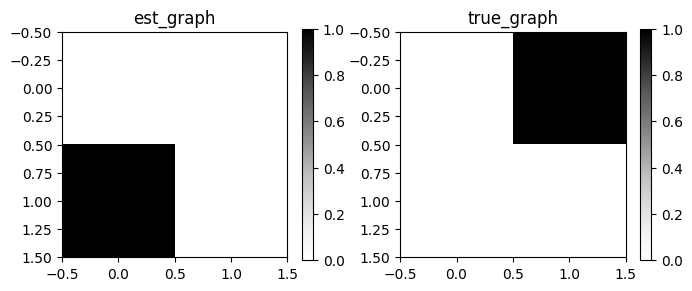

c:\Users\rubin\AppData\Local\Programs\Python\Python311\Lib\site-packages\castle\metrics\evaluation.py:226: RuntimeWarning: invalid value encountered in double_scalars
  F1 = 2*(recall*precision)/(recall+precision)


In [4]:
# With discretization
print("~~~~~ NonLingauss WITH DISCRETIZATION ~~~~~")
hart_est_adj_nonlingauss, gt_nonlingauss, hart_f1_scores_nonlingauss, hart_metrics_nonlingauss = gae_cs(dataset=nonlingauss, apply_hartemink_discretization=True)

# Without discretization
print("\n\n\n~~~~~ NonLingauss WITHOUT DISCRETIZATION ~~~~~")
est_adj_nonlingauss, gt_nonlingauss, f1_scores_nonlingauss, metrics_nonlingauss = gae_cs(dataset=nonlingauss, apply_hartemink_discretization=False)

<h4>nonlin_simpson</h4>

~~~~~ Nonlin Simpson WITH DISCRETIZATION ~~~~~
Working on the 60th level of discretization.
Working on the 50th level of discretization.
Working on the 40th level of discretization.
Working on the 30th level of discretization.
Working on the 20th level of discretization.
Working on the 10th level of discretization.
{'adjacency_f1': 0.8571428571428571, 'orientation_f1': 0.5714285714285715}


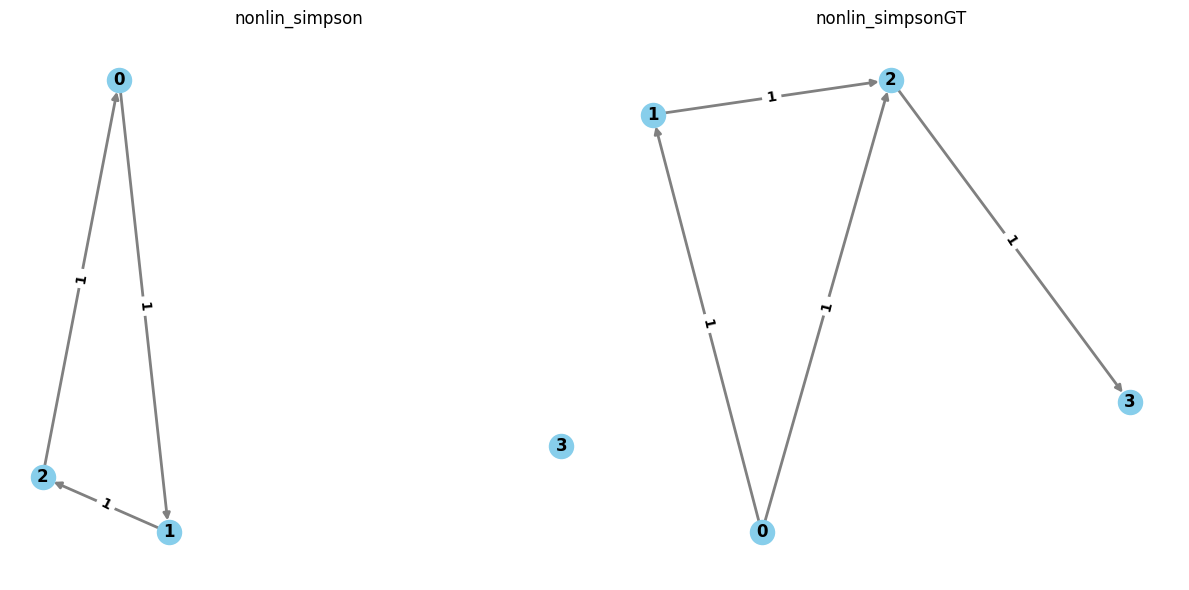

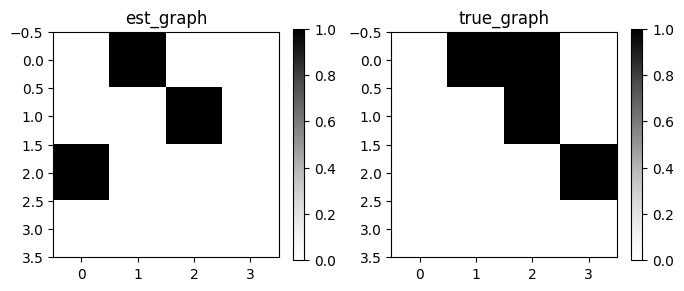




~~~~~ Nonlin Simpson WITHOUT DISCRETIZATION ~~~~~
{'adjacency_f1': 0.6666666666666666, 'orientation_f1': 0.0}


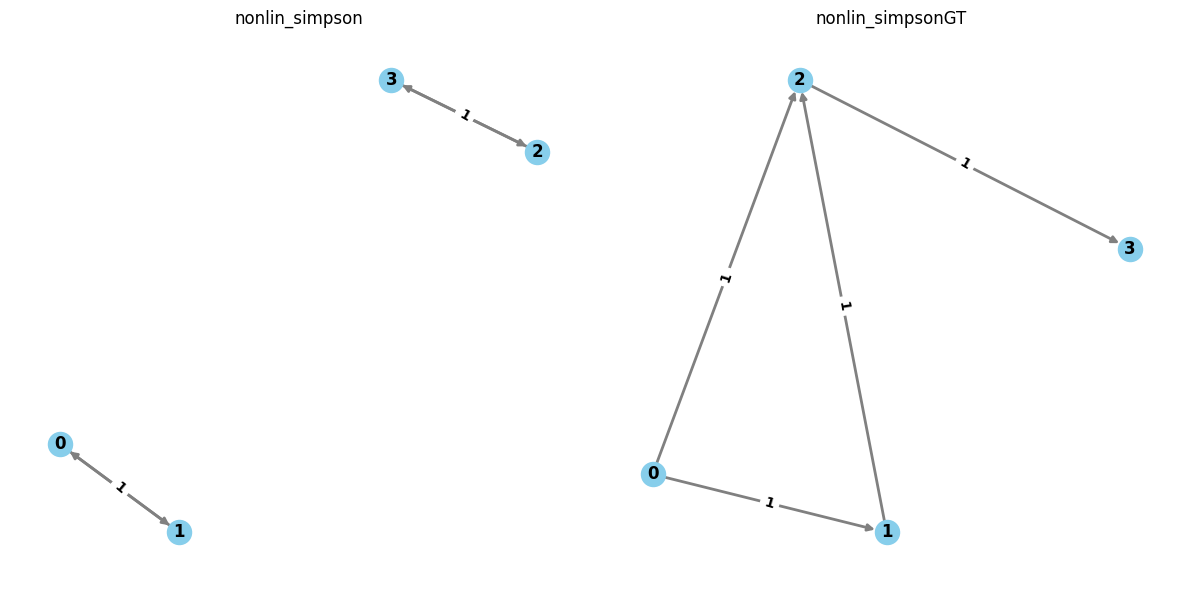

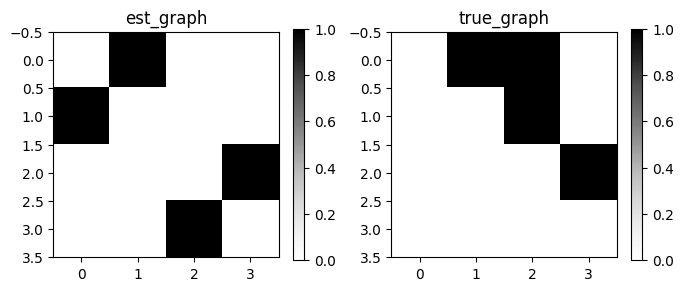

In [5]:
# With discretization
print("~~~~~ Nonlin Simpson WITH DISCRETIZATION ~~~~~")
hart_est_adj_nonlin_simpson, gt_nonlin_simpson, hart_f1_scores_nonlin_simpson, hart_metrics_nonlin_simpson = gae_cs(dataset=nonlin_simpson, apply_hartemink_discretization=True)

# Without discretization
print("\n\n\n~~~~~ Nonlin Simpson WITHOUT DISCRETIZATION ~~~~~")
est_adj_nonlin_simpson, gt_nonlin_simpson, f1_scores_nonlin_simpson, metrics_nonlin_simpson = gae_cs(dataset=nonlin_simpson, apply_hartemink_discretization=False)

<h4>Symprod Simpson</h4>

~~~~~ Symprod Simpson WITH DISCRETIZATION ~~~~~
Working on the 60th level of discretization.
Working on the 50th level of discretization.
Working on the 40th level of discretization.
Working on the 30th level of discretization.
Working on the 20th level of discretization.
Working on the 10th level of discretization.
{'adjacency_f1': 0.75, 'orientation_f1': 0.5}


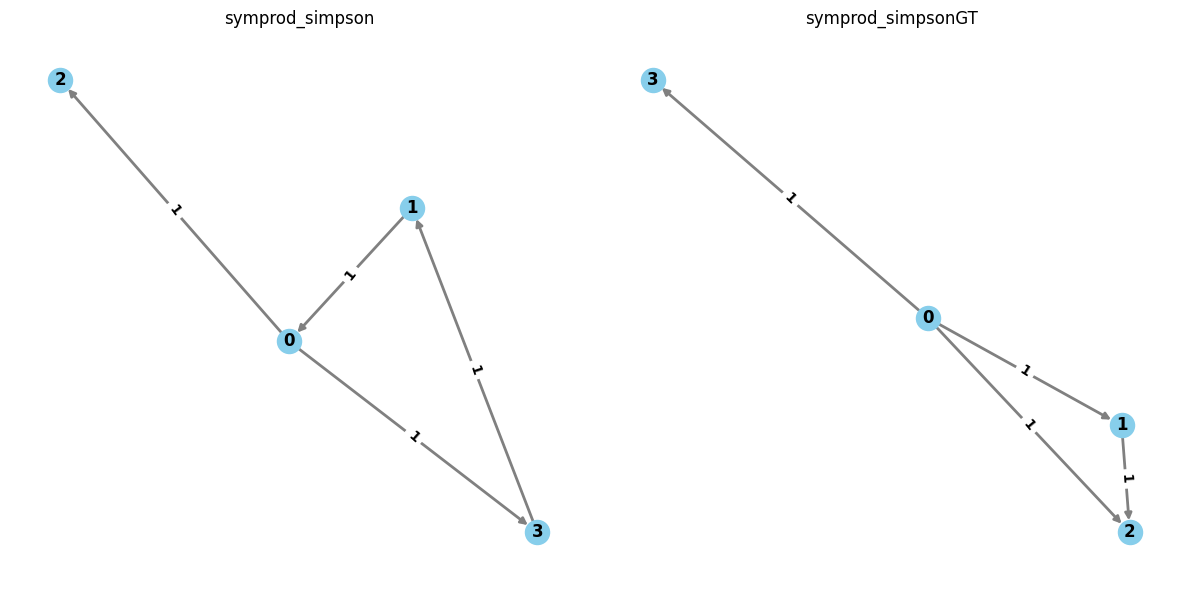

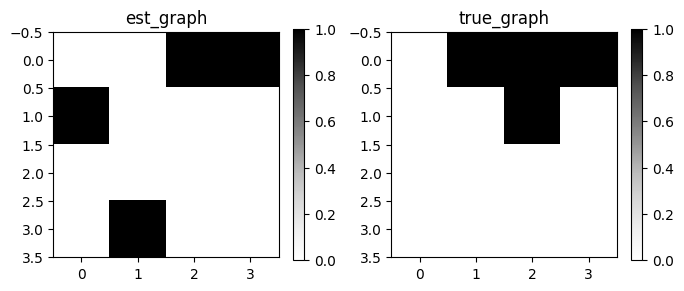




~~~~~ Symprod Simpson WITHOUT DISCRETIZATION ~~~~~
{'adjacency_f1': 0.4, 'orientation_f1': 0.4}


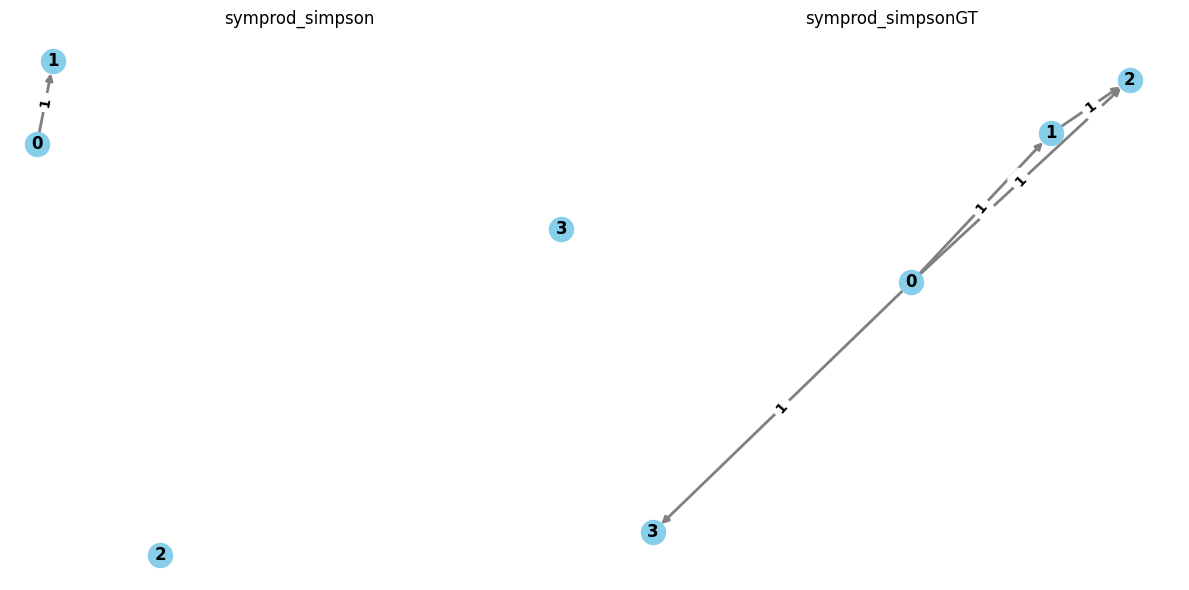

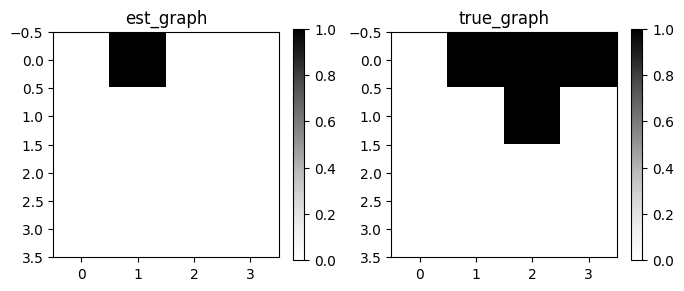

In [6]:
# With discretization
print("~~~~~ Symprod Simpson WITH DISCRETIZATION ~~~~~")
hart_est_adj_symprod_simpson, gt_symprod_simpson, hart_f1_scores_symprod_simpson, hart_metrics_symprod_simpson = gae_cs(dataset=symprod_simpson, apply_hartemink_discretization=True)

# Without discretization
print("\n\n\n~~~~~ Symprod Simpson WITHOUT DISCRETIZATION ~~~~~")
est_adj_symprod_simpson, gt_symprod_simpson, f1_scores_symprod_simpson, metrics_symprod_simpson = gae_cs(dataset=symprod_simpson, apply_hartemink_discretization=False)

<h4>Large Backdoor</h4>

~~~~~ large_backdoor WITH DISCRETIZATION ~~~~~
Working on the 60th level of discretization.
Working on the 50th level of discretization.
Working on the 40th level of discretization.
Working on the 30th level of discretization.
Working on the 20th level of discretization.
Working on the 10th level of discretization.
{'adjacency_f1': 0.5, 'orientation_f1': 0.5}


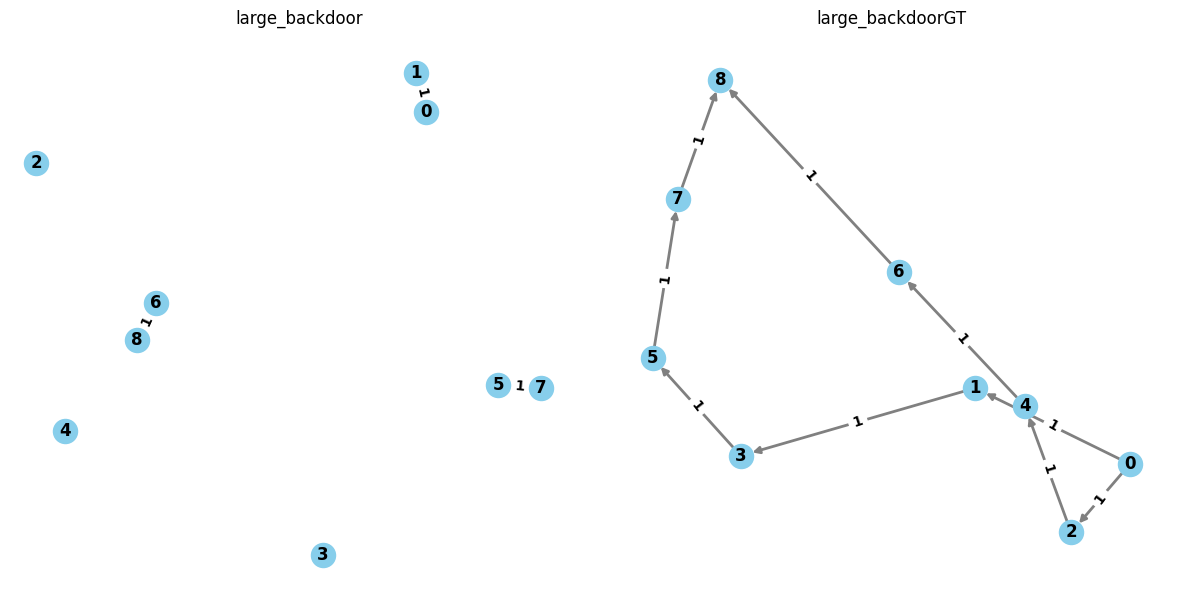

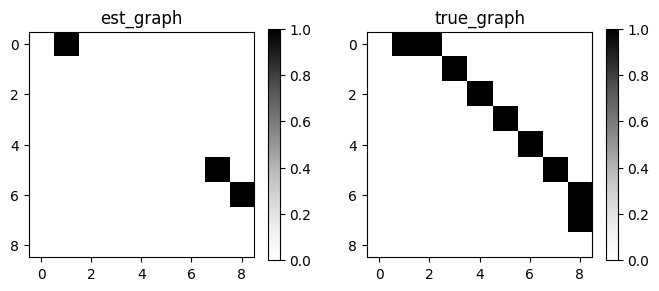




~~~~~ large_backdoor WITHOUT DISCRETIZATION ~~~~~
{'adjacency_f1': 1.0, 'orientation_f1': 0.4444444444444444}


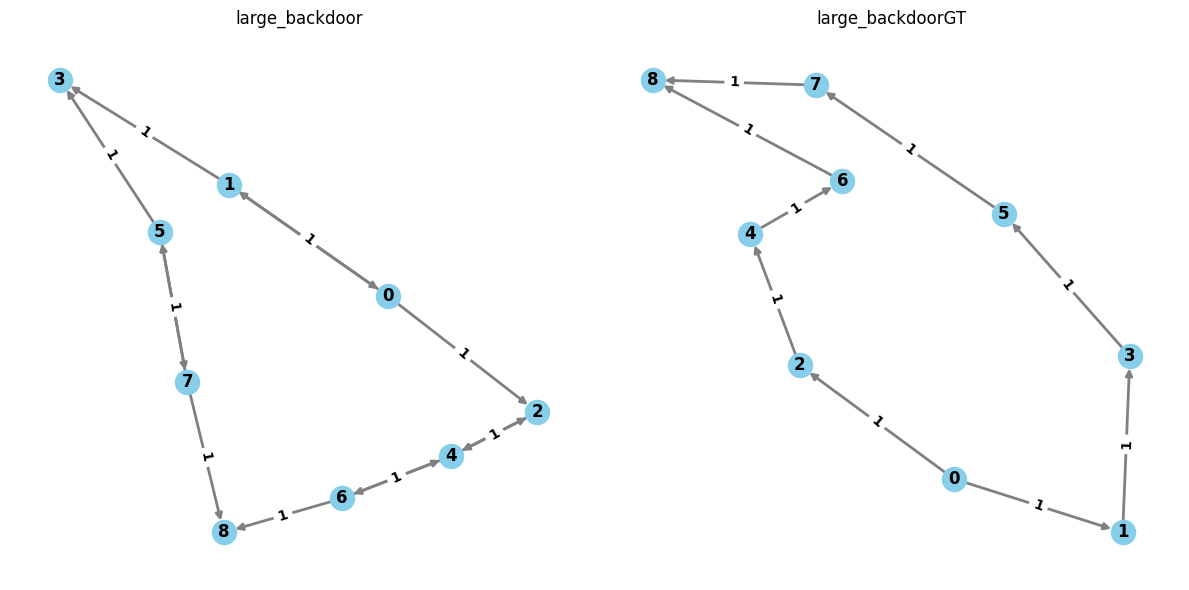

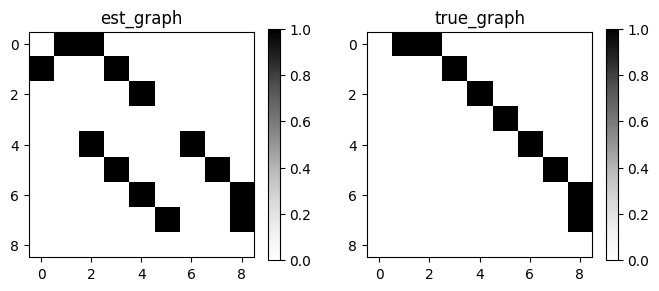

In [7]:
# With discretization
print("~~~~~ large_backdoor WITH DISCRETIZATION ~~~~~")
hart_est_adj_large_backdoor, gt_large_backdoor, hart_f1_scores_large_backdoor, hart_metrics_large_backdoor = gae_cs(dataset=large_backdoor, apply_hartemink_discretization=True)

# Without discretization
print("\n\n\n~~~~~ large_backdoor WITHOUT DISCRETIZATION ~~~~~")
est_adj_large_backdoor, gt_large_backdoor, f1_scores_large_backdoor, metrics_large_backdoor = gae_cs(dataset=large_backdoor, apply_hartemink_discretization=False)

<h4>Weak Arrows</h4>

~~~~~ weak_arrows WITH DISCRETIZATION ~~~~~
Working on the 60th level of discretization.
Working on the 50th level of discretization.
Working on the 40th level of discretization.
Working on the 30th level of discretization.
Working on the 20th level of discretization.
Working on the 10th level of discretization.
{'adjacency_f1': 0.6363636363636364, 'orientation_f1': 0.0}


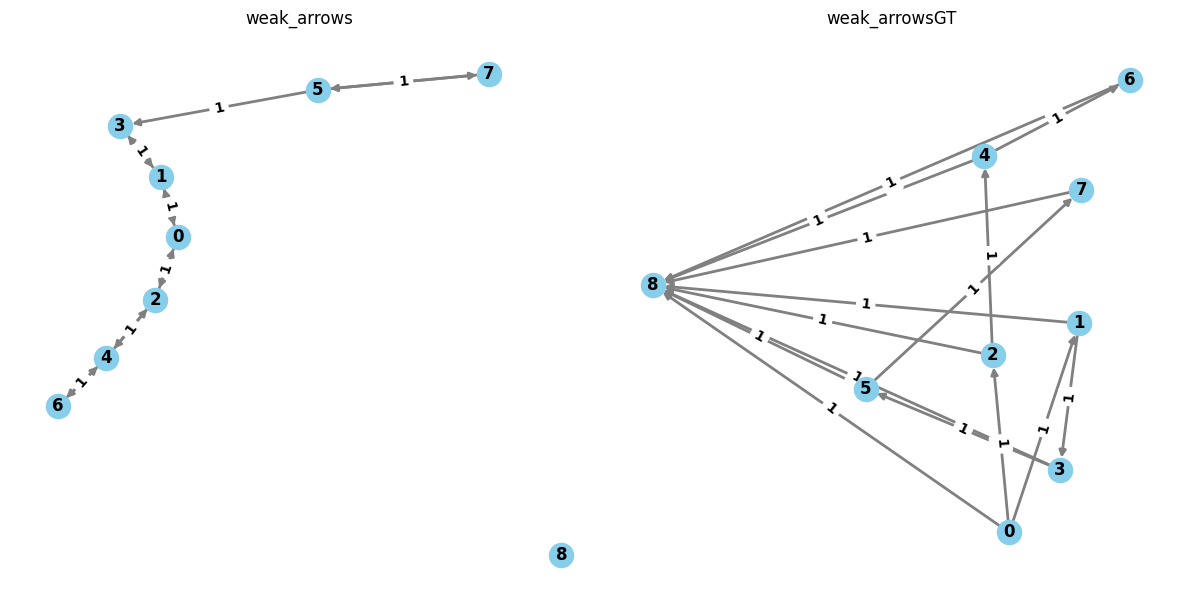

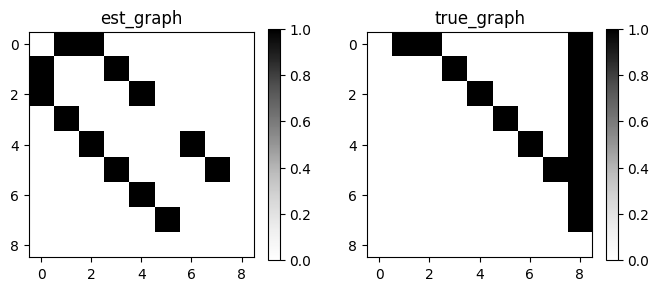




~~~~~ weak_arrows WITHOUT DISCRETIZATION ~~~~~


In [8]:
# With discretization
print("~~~~~ weak_arrows WITH DISCRETIZATION ~~~~~")
hart_est_adj_weak_arrows, gt_weak_arrows, hart_f1_scores_weak_arrows, hart_metrics_weak_arrows = gae_cs(dataset=weak_arrows, apply_hartemink_discretization=True)

# Without discretization
print("\n\n\n~~~~~ weak_arrows WITHOUT DISCRETIZATION ~~~~~")
est_adj_weak_arrows, gt_weak_arrows, f1_scores_weak_arrows, metrics_weak_arrows = gae_cs(dataset=weak_arrows, apply_hartemink_discretization=False)

<h4>Sachs set</h4>

~~~~~ Sachs WITH DISCRETIZATION ~~~~~
Working on the 60th level of discretization.
Working on the 50th level of discretization.
Working on the 40th level of discretization.
Working on the 30th level of discretization.
Working on the 20th level of discretization.
Working on the 10th level of discretization.
{'adjacency_f1': 0.10526315789473684, 'orientation_f1': 0.10526315789473684}


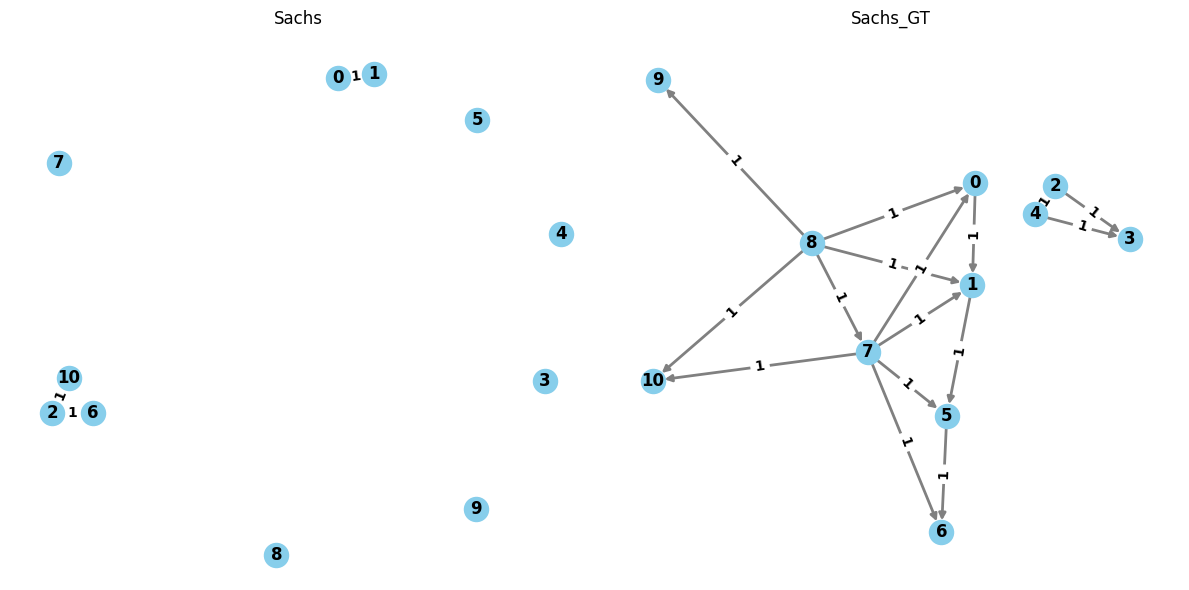

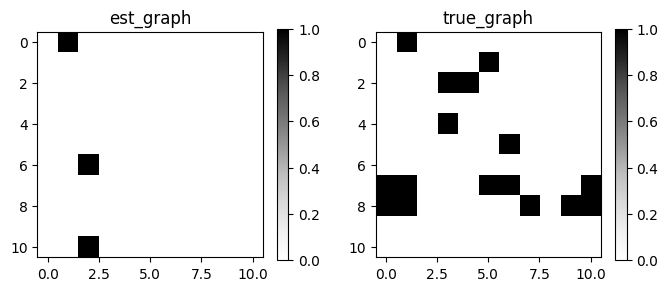




~~~~~ Sachs WITHOUT DISCRETIZATION ~~~~~
{'adjacency_f1': 0.2222222222222222, 'orientation_f1': 0.0}


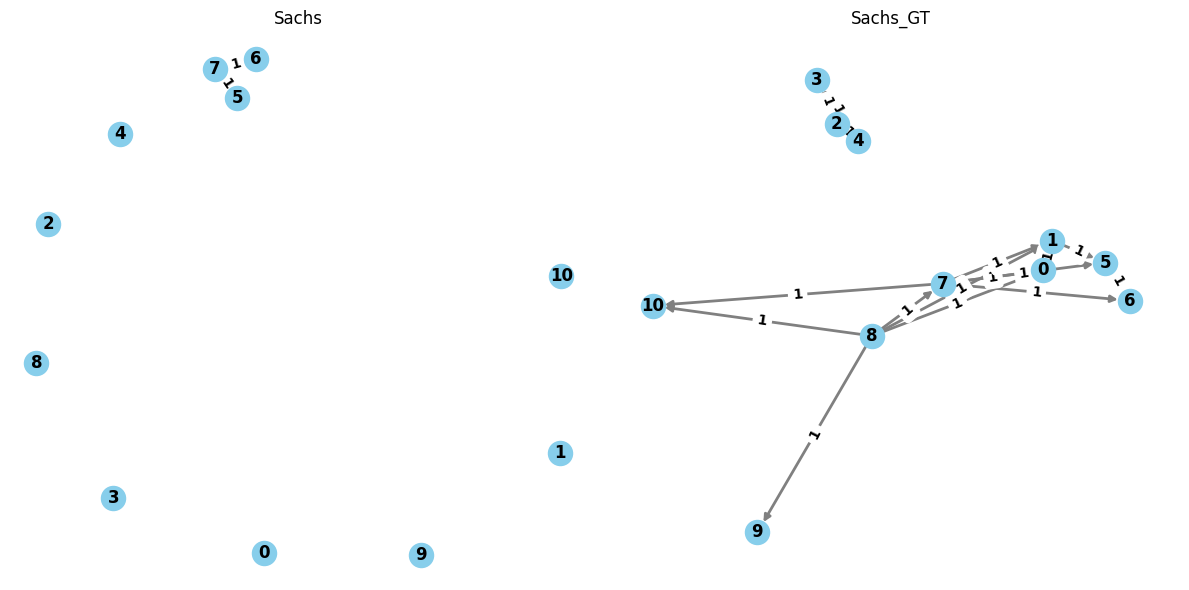

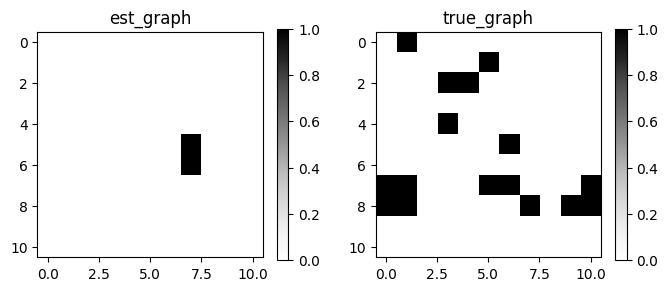

c:\Users\rubin\AppData\Local\Programs\Python\Python311\Lib\site-packages\castle\metrics\evaluation.py:226: RuntimeWarning: invalid value encountered in double_scalars
  F1 = 2*(recall*precision)/(recall+precision)


In [ ]:
# With discretization
print("~~~~~ Sachs WITH DISCRETIZATION ~~~~~")
hart_est_adj_sachs, gt_sachs, hart_f1_scores_sachs, hart_metrics_sachs = gae_sachs(apply_hartemink_discretization=True)

# Without discretization
print("\n\n\n~~~~~ Sachs WITHOUT DISCRETIZATION ~~~~~")
est_adj_sachs, gt_sachs, f1_scores_sachs, metrics_sachs = gae_sachs(apply_hartemink_discretization=False)

<h4>Let's plot the adjagency and orientation f1 scores of GAE for all datasets, with and without Hartemink Discretization.</h4>

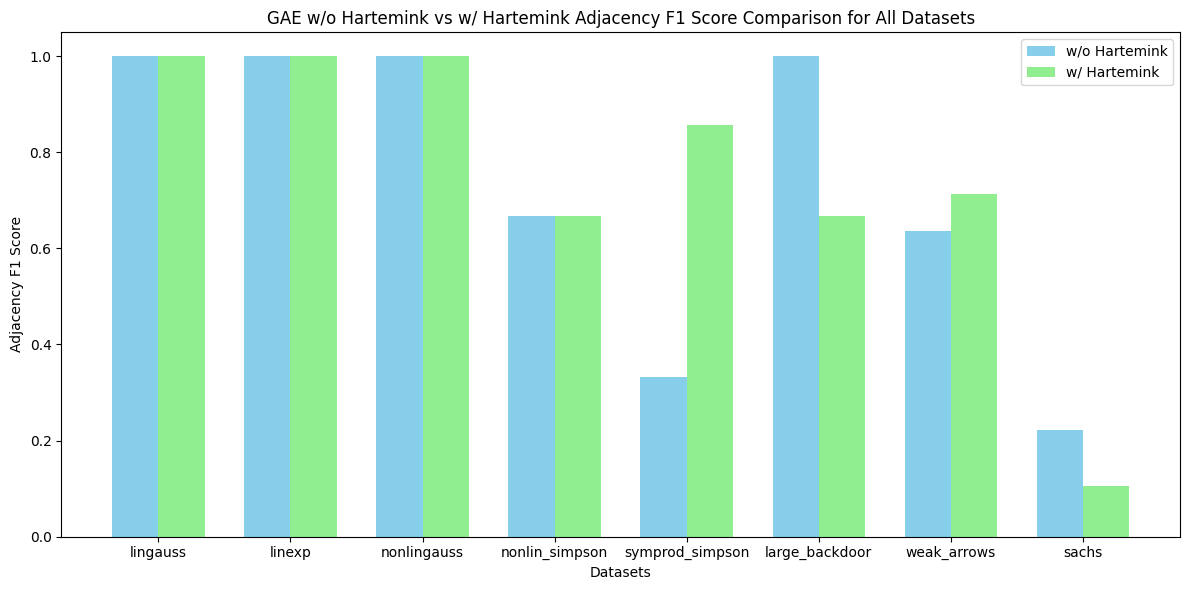

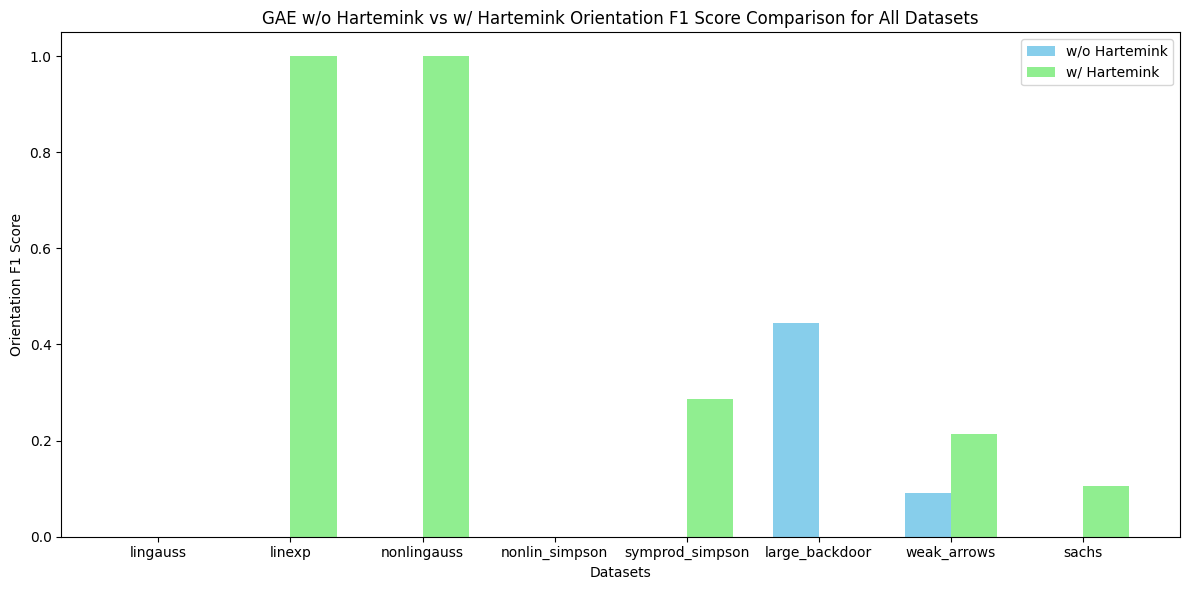

In [ ]:
datasets = [lingauss, linexp, nonlingauss, nonlin_simpson, symprod_simpson, large_backdoor, weak_arrows]
f1_scores_all = [f1_scores_lingauss, f1_scores_linexp, f1_scores_nonlingauss, f1_scores_nonlin_simpson, f1_scores_symprod_simpson, f1_scores_large_backdoor, f1_scores_weak_arrows ]
f1_scores_all_hartemink = [hart_f1_scores_lingauss, hart_f1_scores_linexp, hart_f1_scores_nonlingauss, hart_f1_scores_nonlin_simpson, hart_f1_scores_symprod_simpson, hart_f1_scores_large_backdoor, hart_f1_scores_weak_arrows ]

all_datasets = [i.__name__ for i in datasets] + ['sachs']

GAE_adjacency = [d['adjacency_f1'] for d in f1_scores_all] + [f1_scores_sachs['adjacency_f1']]
#print(GAE_adjacency)
GAE_adjacency_hart = [d['adjacency_f1'] for d in f1_scores_all_hartemink] + [hart_f1_scores_sachs['adjacency_f1']]

GAE_orientation = [d['orientation_f1'] for d in f1_scores_all] + [f1_scores_sachs['orientation_f1']]
GAE_orientation_hart = [d['orientation_f1'] for d in f1_scores_all_hartemink] + [hart_f1_scores_sachs['orientation_f1']]

# Define colors
colors = ['skyblue', 'lightgreen']
bar_width = 0.35
index = range(len(all_datasets))

# Plot sequence F1 scores
plt.figure(figsize=(12, 6))

plt.bar(index, GAE_adjacency, bar_width, label='w/o Hartemink', color=colors[0])
plt.bar([i + bar_width for i in index], GAE_adjacency_hart, bar_width, label='w/ Hartemink', color=colors[1])

plt.xlabel('Datasets')
plt.ylabel('Adjacency F1 Score')
plt.title('GAE w/o Hartemink vs w/ Hartemink Adjacency F1 Score Comparison for All Datasets')
plt.xticks([i + bar_width / 2 for i in index], all_datasets)
plt.legend()

plt.tight_layout()
plt.show()

# Plot unrolled F1 scores
plt.figure(figsize=(12, 6))

plt.bar(index, GAE_orientation, bar_width, label='w/o Hartemink', color=colors[0])
plt.bar([i + bar_width for i in index], GAE_orientation_hart, bar_width, label='w/ Hartemink', color=colors[1])

plt.xlabel('Datasets')
plt.ylabel('Orientation F1 Score')
plt.title('GAE w/o Hartemink vs w/ Hartemink Orientation F1 Score Comparison for All Datasets')
plt.xticks([i + bar_width / 2 for i in index], all_datasets)
plt.legend()

plt.tight_layout()
plt.show()

<h1>DAG-GNN</h1>

<h4>Paper: <a href="https://arxiv.org/pdf/1904.10098">DAG-GNN: DAG Structure Learning with Graph Neural Networks</a><br>
Reference: <a href="https://github.com/huawei-noah/trustworthyAI/tree/master/gcastle">gCastle</a></h4>

<p>DAG-GNN is again a generalization of NOTEARS, in this case the generative model is given as: </p>

$ X = f_{2}((I - A^{T})^{-1} f_{1}(Z)) \space \space\space$ (Decoder) <br>

where $ f_{1} $ and $ f_{2} $ are point-wise (nonlinear) functions.<br> 
<p>One may learn the generative model through maximizing the log-evidence: </p>

$ \frac{1}{n} \sum_{k=1}^{n} log \space p(X^{k}) = \frac{1}{n} \sum_{k=1}^{n} log \int p(X^{k}|Z)p(Z) dZ, $
<p>which is generally intractable.</p>

They use a variational posterior $ q(Z|X)$ to approximate the actual posterior $ p(Z|X).$ 
<p>The result is the ELBO:</p>

$ L_{ELBO} = \frac{1}{n} \sum_{k=1}^{n} L_{ELBO}^{k}, $
<p>with</p>

$ L_{ELBO}^{k} = -D_{KL}(q(Z|X^{k}) || p(Z)) + E_{q(Z|X^{k})} \space [\space log\space p(X^{k}|Z)]$<br><br>
Each individual term $ L_{ELBO}^{k} $ departs from the log-evidence by $ D_{KL} \space (q(Z|X^{k}) \space || \space p(Z|X^{k})) >= 0$.<br><br>
The ELBO lends itself to a VAE, where given a sample $ X^{k}$, the encoder encodes it into a latent variable $Z$ with density $ q(Z|X^{k})$; and the decoder tries to reconstruct $X^{k}$ from Z with density $p(X^{k}|Z).$

<p>Given the Decoder discussed above, the authors proposed the following Encoder: </p>

$ Z = f_{4}((I - A)^{T}f_{3}(X)) $<br><br>
where $f_{3} $ and $f_{4}$ are parametrized functions tha play the inverse role of $f_{2}$ and $f_{1}$ respectively.<br><br>
For the inference model, $f_{3}$ is a MLP and $f_{4}$ the identity mapping.<br><br>
For the generative model, $f_{1}$ is the identity mapping and $f_{2}$ the MLP.



In [ ]:
from IPython.display import Image
PATH = "/university/ai_industry/AI_in_Industry_Project/"

Image(filename = PATH + "vae_gnn.png", width=1000, height=1000)

<p>After several other steps, we can conclude by saying that in DAG-GNN paper, the causal structure learning is formulated under the framework of variational autoencoders with multilayer perceptrons (MLPs) to model the causal relations, and the objective is to maximize the ELBO under the acyclicity constraint.<br>
In fact, the learning problem becomes:</p>


$ \underset{A, \theta}{\textrm{min}} \space f(A, \theta) = -L_{ELBO}$
<p>under the acyclicity constraint which is defined as:</p>


$h(A) = tr[(I + \alpha A ° A)^{m}] - m = 0$
<p>Which is solved using the augmented Lagrangian approach, the augmented Lagrangian is defined as:</p>

$ L_{c}(A, \theta, \lambda) = f(A, \theta) + \lambda h(A) + \frac{c}{2} |h(A)|^{2},$<br>
where $\lambda$ is the Lagrange multiplier and $c$ is the penalty parameter.<br><br>
The strategy is to progressively increase $c$, in order to minimize the unconstrained augmented Lagrangian.<br><br>
The rule used to update $\lambda$ and increase $c$ is the following:<br><br>
$(A_{k}, \theta^{k}) = \underset{A, \theta}{\textrm{argmin}} \space L_{c}^{k}(A, \theta, \lambda^{k})$<br>
$ \lambda^{k+1} = \lambda^{k} + c^{k} h(A^{k})$ <br>
$ c^{k+1}:  \begin{cases} 
    \eta c^{k}, & if \space |h(A^{k}| > \gamma|h(A^{k-1})), \\
    c^{k}, & \text{otherwise}
\end{cases} $

where $ \eta > 1 $ and $ \gamma < 1 $ are tuning hyperparameters.



<h5>Sachs Set</h5>

~~~~~ Sachs WITH DISCRETIZATION ~~~~~
Working on the 60th level of discretization.
Working on the 50th level of discretization.
Working on the 40th level of discretization.
Working on the 30th level of discretization.
Working on the 20th level of discretization.
Working on the 10th level of discretization.


2024-05-10 20:43:55,255 - c:\Users\rubin\AppData\Local\Programs\Python\Python311\Lib\site-packages\castle\algorithms\gradient\dag_gnn\torch\dag_gnn.py[line:167] - INFO: GPU is unavailable.
2024-05-10 20:44:12,744 - c:\Users\rubin\AppData\Local\Programs\Python\Python311\Lib\site-packages\castle\algorithms\gradient\dag_gnn\torch\dag_gnn.py[line:253] - INFO: Iter: 0, epoch: 299, h_new: 0.020076026585805096
2024-05-10 20:44:45,690 - c:\Users\rubin\AppData\Local\Programs\Python\Python311\Lib\site-packages\castle\algorithms\gradient\dag_gnn\torch\dag_gnn.py[line:253] - INFO: Iter: 1, epoch: 299, h_new: 0.001285705483317301
2024-05-10 20:45:17,987 - c:\Users\rubin\AppData\Local\Programs\Python\Python311\Lib\site-packages\castle\algorithms\gradient\dag_gnn\torch\dag_gnn.py[line:253] - INFO: Iter: 2, epoch: 299, h_new: 0.00020611414242033277
2024-05-10 20:45:51,906 - c:\Users\rubin\AppData\Local\Programs\Python\Python311\Lib\site-packages\castle\algorithms\gradient\dag_gnn\torch\dag_gnn.py[line

{'adjacency_f1': 0.4, 'orientation_f1': 0.1}


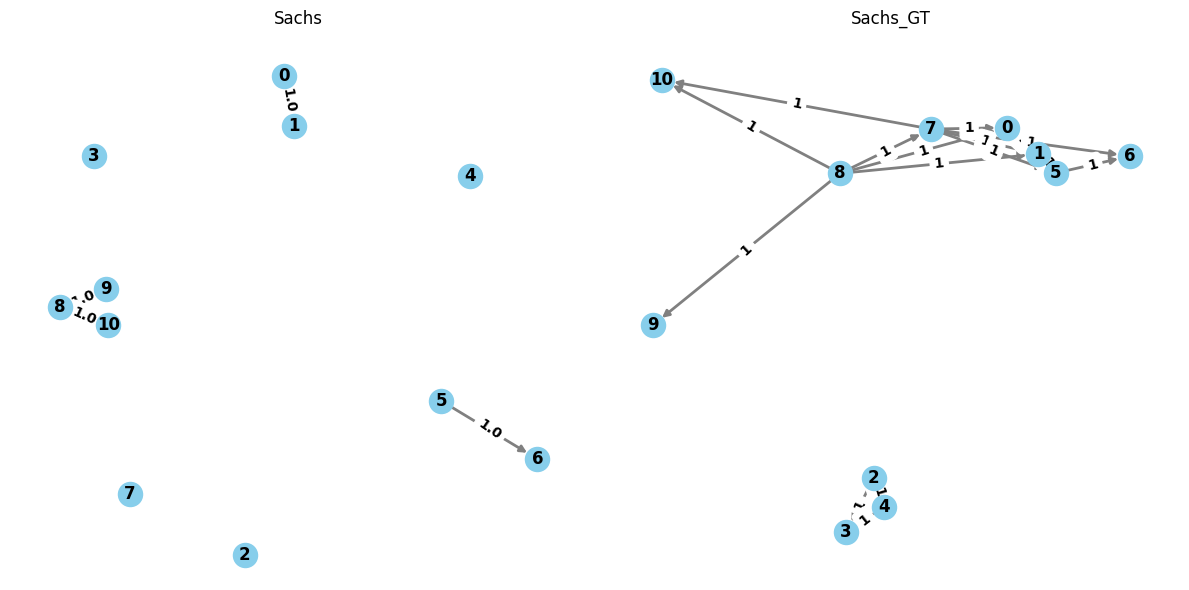

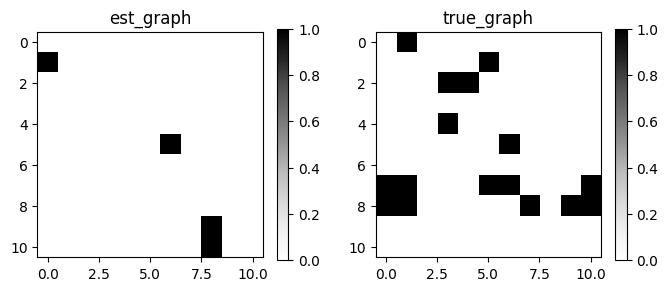

2024-05-10 20:49:19,224 - c:\Users\rubin\AppData\Local\Programs\Python\Python311\Lib\site-packages\castle\algorithms\gradient\dag_gnn\torch\dag_gnn.py[line:167] - INFO: GPU is unavailable.





~~~~~ Sachs WITHOUT DISCRETIZATION ~~~~~


2024-05-10 20:49:36,857 - c:\Users\rubin\AppData\Local\Programs\Python\Python311\Lib\site-packages\castle\algorithms\gradient\dag_gnn\torch\dag_gnn.py[line:253] - INFO: Iter: 0, epoch: 299, h_new: 2.9691590017423657
2024-05-10 20:50:28,569 - c:\Users\rubin\AppData\Local\Programs\Python\Python311\Lib\site-packages\castle\algorithms\gradient\dag_gnn\torch\dag_gnn.py[line:253] - INFO: Iter: 1, epoch: 299, h_new: 0.26020165558468733
2024-05-10 20:51:02,987 - c:\Users\rubin\AppData\Local\Programs\Python\Python311\Lib\site-packages\castle\algorithms\gradient\dag_gnn\torch\dag_gnn.py[line:253] - INFO: Iter: 2, epoch: 299, h_new: 0.03509109179300829
2024-05-10 20:51:35,868 - c:\Users\rubin\AppData\Local\Programs\Python\Python311\Lib\site-packages\castle\algorithms\gradient\dag_gnn\torch\dag_gnn.py[line:253] - INFO: Iter: 3, epoch: 299, h_new: 0.007034032456205708
2024-05-10 20:52:08,962 - c:\Users\rubin\AppData\Local\Programs\Python\Python311\Lib\site-packages\castle\algorithms\gradient\dag_gn

{'adjacency_f1': 0.5882352941176471, 'orientation_f1': 0.35294117647058826}


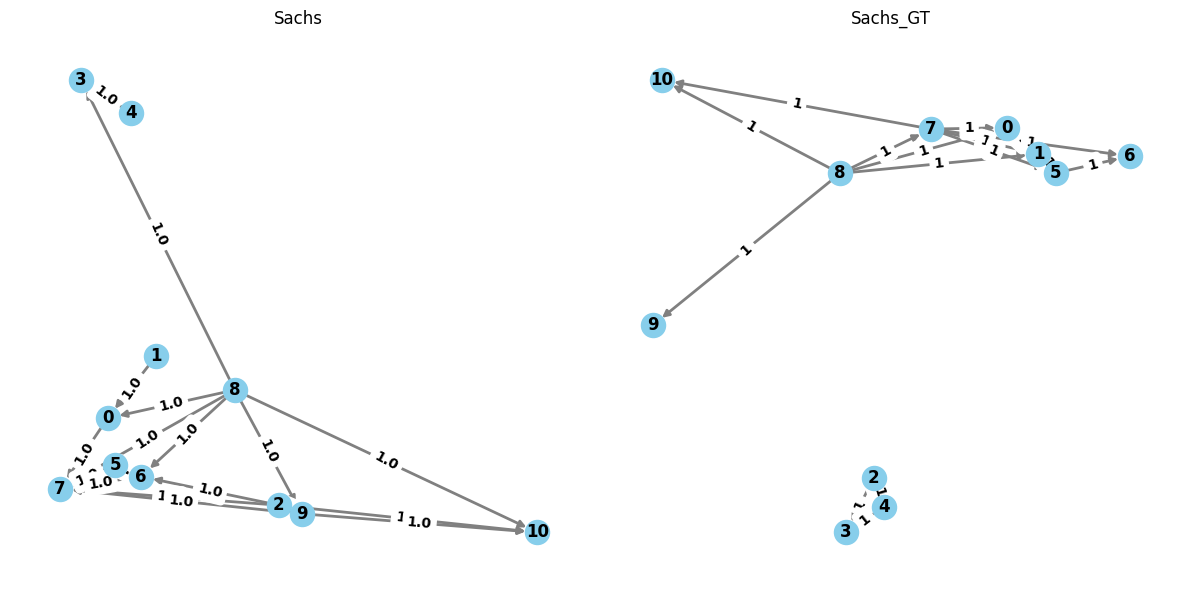

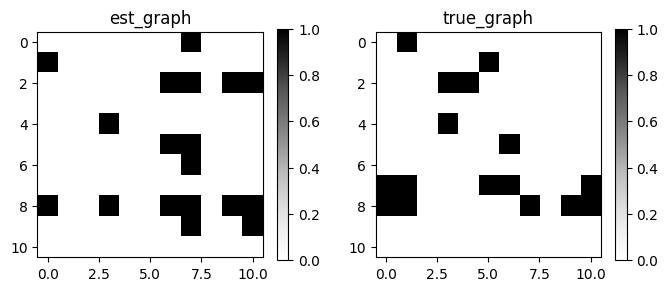

In [ ]:
# With discretization
print("~~~~~ Sachs WITH DISCRETIZATION ~~~~~")
hart_est_adj_sachs_gnn, gt_sachs, hart_f1_scores_sachs_gnn, hart_metrics_sachs_gnn = dag_gnn_sachs(apply_hartemink_discretization=True)

# Without discretization
print("\n\n\n~~~~~ Sachs WITHOUT DISCRETIZATION ~~~~~")
est_adj_sachs_gnn, gt_sachs, f1_scores_sachs_gnn, metrics_sachs_gnn = dag_gnn_sachs(apply_hartemink_discretization=False)

<h2>csuite</h2>

<h5>lingauss</h5>

~~~~~ lingauss WITH DISCRETIZATION ~~~~~
Working on the 60th level of discretization.
Working on the 50th level of discretization.
Working on the 40th level of discretization.
Working on the 30th level of discretization.
Working on the 20th level of discretization.
Working on the 10th level of discretization.


2024-05-10 20:58:31,141 - c:\Users\rubin\AppData\Local\Programs\Python\Python311\Lib\site-packages\castle\algorithms\gradient\dag_gnn\torch\dag_gnn.py[line:167] - INFO: GPU is unavailable.
2024-05-10 20:58:55,004 - c:\Users\rubin\AppData\Local\Programs\Python\Python311\Lib\site-packages\castle\algorithms\gradient\dag_gnn\torch\dag_gnn.py[line:253] - INFO: Iter: 0, epoch: 299, h_new: 0.0044760505022320984
2024-05-10 20:59:19,276 - c:\Users\rubin\AppData\Local\Programs\Python\Python311\Lib\site-packages\castle\algorithms\gradient\dag_gnn\torch\dag_gnn.py[line:253] - INFO: Iter: 1, epoch: 299, h_new: 0.0044760505022320984
2024-05-10 21:00:08,270 - c:\Users\rubin\AppData\Local\Programs\Python\Python311\Lib\site-packages\castle\algorithms\gradient\dag_gnn\torch\dag_gnn.py[line:253] - INFO: Iter: 2, epoch: 299, h_new: 0.0001515030567023068
2024-05-10 21:00:57,833 - c:\Users\rubin\AppData\Local\Programs\Python\Python311\Lib\site-packages\castle\algorithms\gradient\dag_gnn\torch\dag_gnn.py[lin

{'adjacency_f1': 1.0, 'orientation_f1': 0.0}


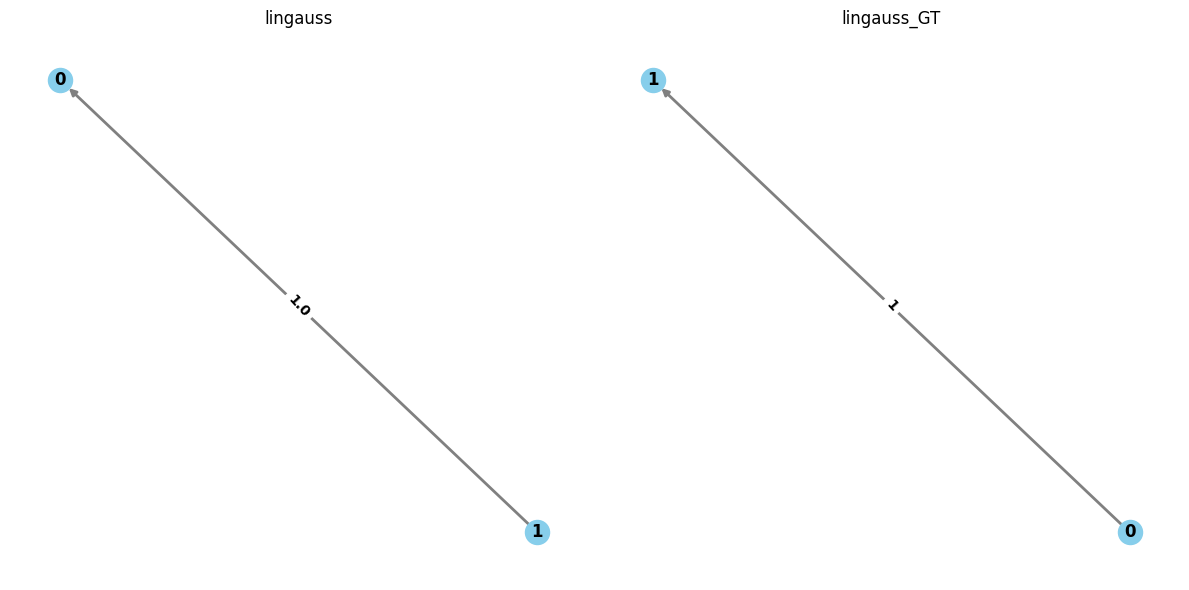

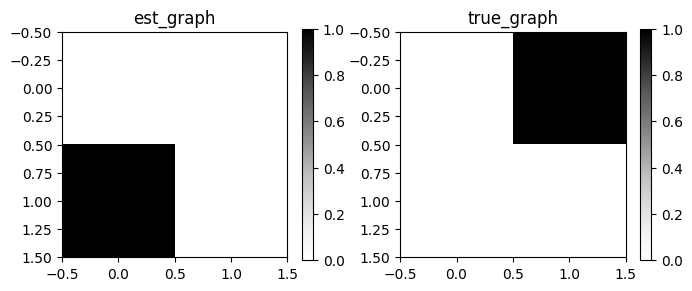

c:\Users\rubin\AppData\Local\Programs\Python\Python311\Lib\site-packages\castle\metrics\evaluation.py:226: RuntimeWarning: invalid value encountered in double_scalars
  F1 = 2*(recall*precision)/(recall+precision)
2024-05-10 21:05:00,822 - c:\Users\rubin\AppData\Local\Programs\Python\Python311\Lib\site-packages\castle\algorithms\gradient\dag_gnn\torch\dag_gnn.py[line:167] - INFO: GPU is unavailable.





~~~~~ lingauss WITHOUT DISCRETIZATION ~~~~~


2024-05-10 21:05:24,872 - c:\Users\rubin\AppData\Local\Programs\Python\Python311\Lib\site-packages\castle\algorithms\gradient\dag_gnn\torch\dag_gnn.py[line:253] - INFO: Iter: 0, epoch: 299, h_new: 1.0
2024-05-10 21:05:48,812 - c:\Users\rubin\AppData\Local\Programs\Python\Python311\Lib\site-packages\castle\algorithms\gradient\dag_gnn\torch\dag_gnn.py[line:253] - INFO: Iter: 1, epoch: 299, h_new: 1.0
2024-05-10 21:06:13,320 - c:\Users\rubin\AppData\Local\Programs\Python\Python311\Lib\site-packages\castle\algorithms\gradient\dag_gnn\torch\dag_gnn.py[line:253] - INFO: Iter: 2, epoch: 299, h_new: 1.1380431645946487e-06
2024-05-10 21:06:38,752 - c:\Users\rubin\AppData\Local\Programs\Python\Python311\Lib\site-packages\castle\algorithms\gradient\dag_gnn\torch\dag_gnn.py[line:253] - INFO: Iter: 3, epoch: 299, h_new: 1.4711951612511598e-07
2024-05-10 21:07:28,606 - c:\Users\rubin\AppData\Local\Programs\Python\Python311\Lib\site-packages\castle\algorithms\gradient\dag_gnn\torch\dag_gnn.py[line:25

{'adjacency_f1': 1.0, 'orientation_f1': 0.0}


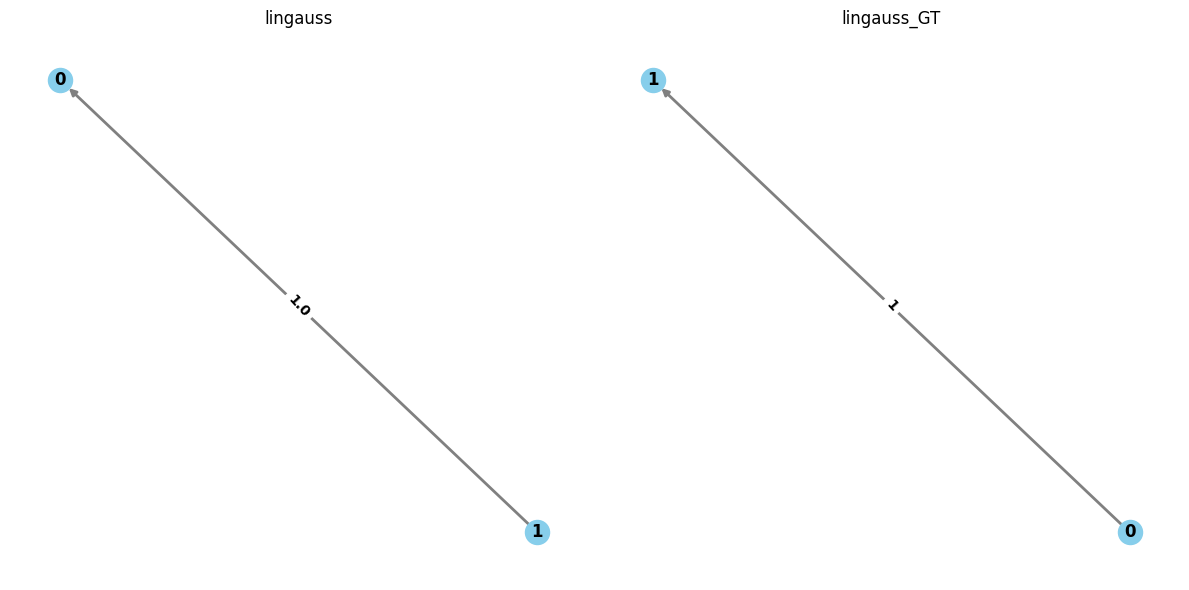

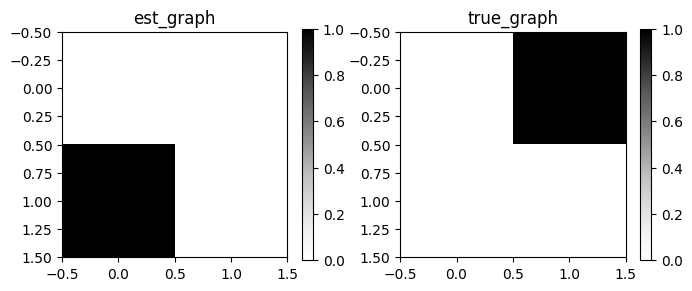

c:\Users\rubin\AppData\Local\Programs\Python\Python311\Lib\site-packages\castle\metrics\evaluation.py:226: RuntimeWarning: invalid value encountered in double_scalars
  F1 = 2*(recall*precision)/(recall+precision)


In [ ]:
# With discretization
print("~~~~~ lingauss WITH DISCRETIZATION ~~~~~")
hart_est_adj_lingauss_gnn, gt_lingauss, hart_f1_scores_lingauss_gnn, hart_metrics_lingauss_gnn = dag_gnn_cs(dataset = lingauss, apply_hartemink_discretization=True)

# Without discretization
print("\n\n\n~~~~~ lingauss WITHOUT DISCRETIZATION ~~~~~")
est_adj_lingauss_gnn, gt_lingauss, f1_scores_lingauss_gnn, metrics_lingauss_gnn = dag_gnn_cs(dataset=lingauss, apply_hartemink_discretization=False)

<h5>linexp</h5>

~~~~~ linexp WITH DISCRETIZATION ~~~~~
Working on the 60th level of discretization.
Working on the 50th level of discretization.
Working on the 40th level of discretization.
Working on the 30th level of discretization.
Working on the 20th level of discretization.
Working on the 10th level of discretization.


2024-05-10 21:09:47,210 - c:\Users\rubin\AppData\Local\Programs\Python\Python311\Lib\site-packages\castle\algorithms\gradient\dag_gnn\torch\dag_gnn.py[line:167] - INFO: GPU is unavailable.
2024-05-10 21:10:12,009 - c:\Users\rubin\AppData\Local\Programs\Python\Python311\Lib\site-packages\castle\algorithms\gradient\dag_gnn\torch\dag_gnn.py[line:253] - INFO: Iter: 0, epoch: 299, h_new: 1.0
2024-05-10 21:10:37,699 - c:\Users\rubin\AppData\Local\Programs\Python\Python311\Lib\site-packages\castle\algorithms\gradient\dag_gnn\torch\dag_gnn.py[line:253] - INFO: Iter: 1, epoch: 299, h_new: 1.0
2024-05-10 21:11:01,908 - c:\Users\rubin\AppData\Local\Programs\Python\Python311\Lib\site-packages\castle\algorithms\gradient\dag_gnn\torch\dag_gnn.py[line:253] - INFO: Iter: 2, epoch: 299, h_new: 1.0
2024-05-10 21:11:27,972 - c:\Users\rubin\AppData\Local\Programs\Python\Python311\Lib\site-packages\castle\algorithms\gradient\dag_gnn\torch\dag_gnn.py[line:253] - INFO: Iter: 3, epoch: 299, h_new: 6.858179211

{'adjacency_f1': 1.0, 'orientation_f1': 0.0}


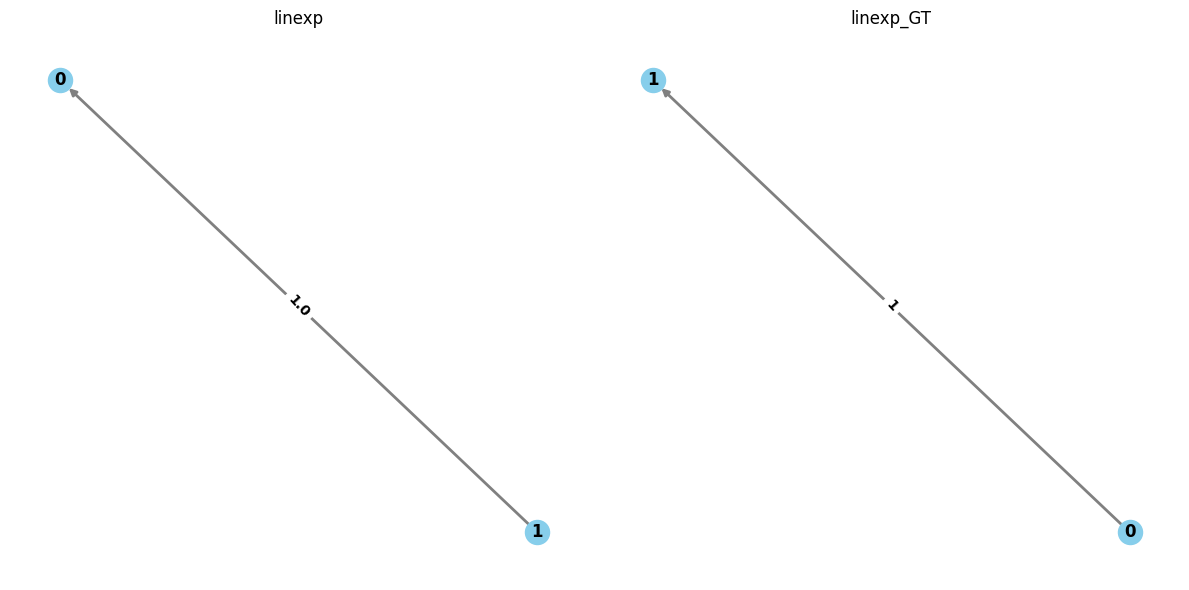

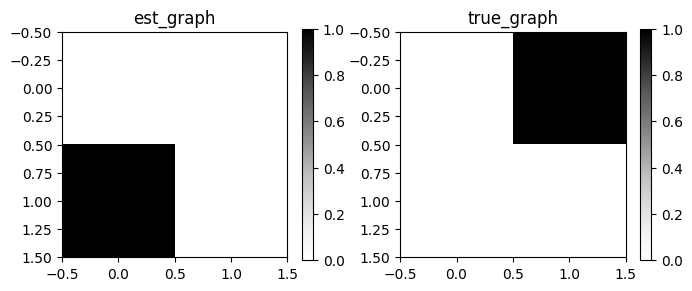

c:\Users\rubin\AppData\Local\Programs\Python\Python311\Lib\site-packages\castle\metrics\evaluation.py:226: RuntimeWarning: invalid value encountered in double_scalars
  F1 = 2*(recall*precision)/(recall+precision)
2024-05-10 21:13:34,511 - c:\Users\rubin\AppData\Local\Programs\Python\Python311\Lib\site-packages\castle\algorithms\gradient\dag_gnn\torch\dag_gnn.py[line:167] - INFO: GPU is unavailable.





~~~~~ linexp WITHOUT DISCRETIZATION ~~~~~


2024-05-10 21:13:59,138 - c:\Users\rubin\AppData\Local\Programs\Python\Python311\Lib\site-packages\castle\algorithms\gradient\dag_gnn\torch\dag_gnn.py[line:253] - INFO: Iter: 0, epoch: 299, h_new: 0.010014825714744102
2024-05-10 21:14:24,420 - c:\Users\rubin\AppData\Local\Programs\Python\Python311\Lib\site-packages\castle\algorithms\gradient\dag_gnn\torch\dag_gnn.py[line:253] - INFO: Iter: 1, epoch: 299, h_new: 0.010014825714744102
2024-05-10 21:14:48,613 - c:\Users\rubin\AppData\Local\Programs\Python\Python311\Lib\site-packages\castle\algorithms\gradient\dag_gnn\torch\dag_gnn.py[line:253] - INFO: Iter: 2, epoch: 299, h_new: 0.010014825714744102
2024-05-10 21:15:12,217 - c:\Users\rubin\AppData\Local\Programs\Python\Python311\Lib\site-packages\castle\algorithms\gradient\dag_gnn\torch\dag_gnn.py[line:253] - INFO: Iter: 3, epoch: 299, h_new: 0.0012737959489399486
2024-05-10 21:15:59,217 - c:\Users\rubin\AppData\Local\Programs\Python\Python311\Lib\site-packages\castle\algorithms\gradient\d

{'adjacency_f1': 0.0, 'orientation_f1': 0.0}


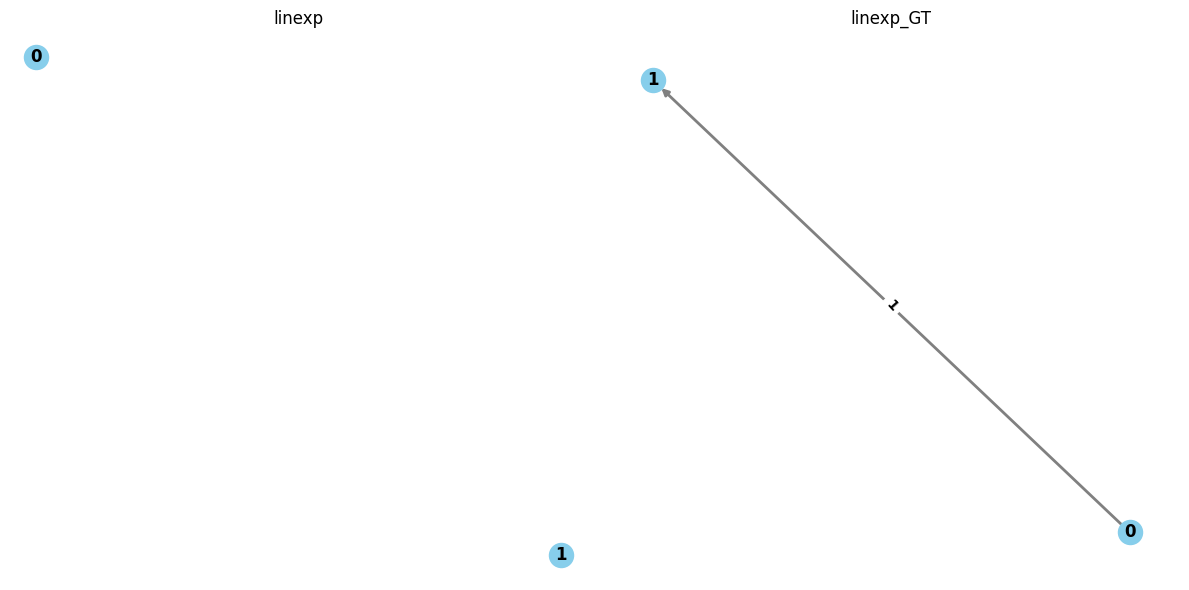

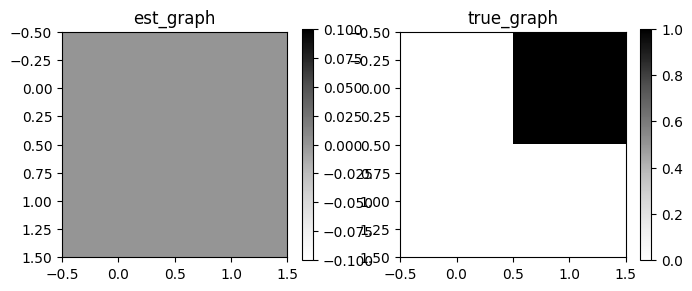

c:\Users\rubin\AppData\Local\Programs\Python\Python311\Lib\site-packages\castle\metrics\evaluation.py:224: RuntimeWarning: invalid value encountered in double_scalars
  precision = TP/TP_FP


In [ ]:
# With discretization
print("~~~~~ linexp WITH DISCRETIZATION ~~~~~")
hart_est_adj_linexp_gnn, gt_linexp, hart_f1_scores_linexp_gnn, hart_metrics_linexp_gnn = dag_gnn_cs(dataset = linexp, apply_hartemink_discretization=True)

# Without discretization
print("\n\n\n~~~~~ linexp WITHOUT DISCRETIZATION ~~~~~")
est_adj_linexp_gnn, gt_linexp, f1_scores_linexp_gnn, metrics_linexp_gnn = dag_gnn_cs(dataset=linexp, apply_hartemink_discretization=False)

<h5>nonlingauss</h5>

~~~~~ nonlingauss WITH DISCRETIZATION ~~~~~
Working on the 60th level of discretization.
Working on the 50th level of discretization.
Working on the 40th level of discretization.
Working on the 30th level of discretization.
Working on the 20th level of discretization.
Working on the 10th level of discretization.


2024-05-10 21:22:41,981 - c:\Users\rubin\AppData\Local\Programs\Python\Python311\Lib\site-packages\castle\algorithms\gradient\dag_gnn\torch\dag_gnn.py[line:167] - INFO: GPU is unavailable.
2024-05-10 21:23:06,720 - c:\Users\rubin\AppData\Local\Programs\Python\Python311\Lib\site-packages\castle\algorithms\gradient\dag_gnn\torch\dag_gnn.py[line:253] - INFO: Iter: 0, epoch: 299, h_new: 1.0
2024-05-10 21:23:31,111 - c:\Users\rubin\AppData\Local\Programs\Python\Python311\Lib\site-packages\castle\algorithms\gradient\dag_gnn\torch\dag_gnn.py[line:253] - INFO: Iter: 1, epoch: 299, h_new: 5.511367824340141e-07
2024-05-10 21:25:07,963 - c:\Users\rubin\AppData\Local\Programs\Python\Python311\Lib\site-packages\castle\algorithms\gradient\dag_gnn\torch\dag_gnn.py[line:253] - INFO: Iter: 2, epoch: 299, h_new: 1.0850256870753583e-07
2024-05-10 21:27:28,889 - c:\Users\rubin\AppData\Local\Programs\Python\Python311\Lib\site-packages\castle\algorithms\gradient\dag_gnn\torch\dag_gnn.py[line:253] - INFO: It

{'adjacency_f1': 0.0, 'orientation_f1': 0.0}


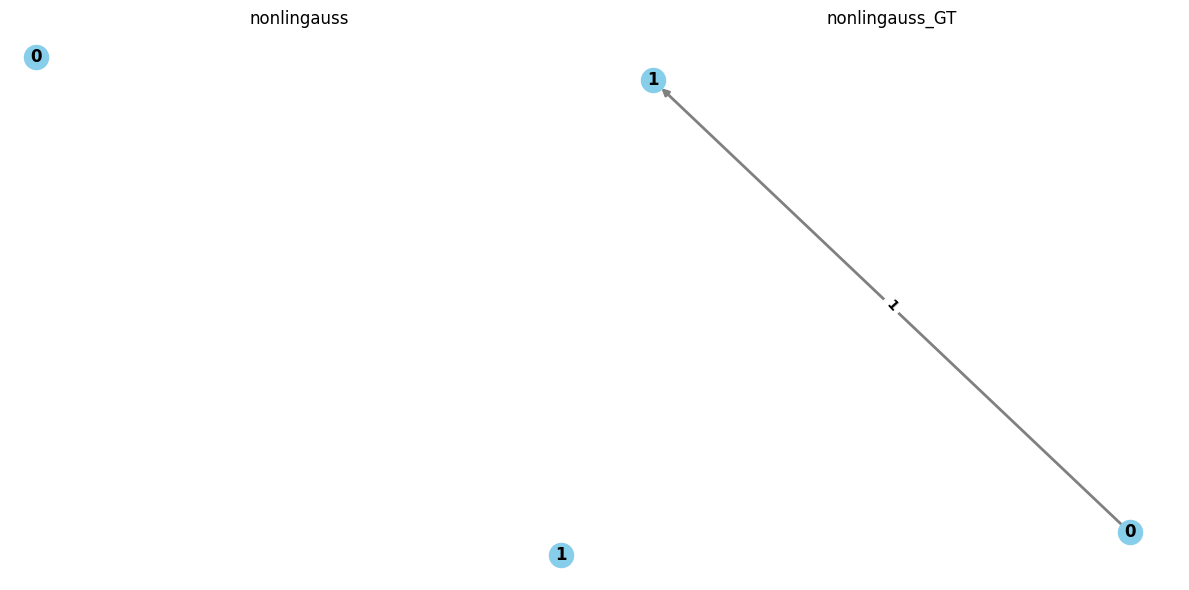

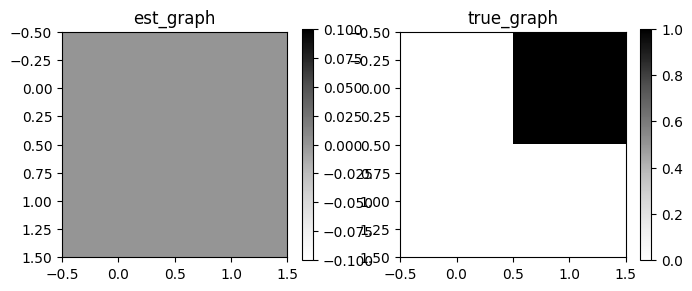

c:\Users\rubin\AppData\Local\Programs\Python\Python311\Lib\site-packages\castle\metrics\evaluation.py:224: RuntimeWarning: invalid value encountered in double_scalars
  precision = TP/TP_FP
2024-05-10 21:29:05,005 - c:\Users\rubin\AppData\Local\Programs\Python\Python311\Lib\site-packages\castle\algorithms\gradient\dag_gnn\torch\dag_gnn.py[line:167] - INFO: GPU is unavailable.





~~~~~ nonlingauss WITHOUT DISCRETIZATION ~~~~~


2024-05-10 21:29:27,940 - c:\Users\rubin\AppData\Local\Programs\Python\Python311\Lib\site-packages\castle\algorithms\gradient\dag_gnn\torch\dag_gnn.py[line:253] - INFO: Iter: 0, epoch: 299, h_new: 1.2246244752489588e-05
2024-05-10 21:30:14,491 - c:\Users\rubin\AppData\Local\Programs\Python\Python311\Lib\site-packages\castle\algorithms\gradient\dag_gnn\torch\dag_gnn.py[line:253] - INFO: Iter: 1, epoch: 299, h_new: 9.868708338522936e-06
2024-05-10 21:30:37,508 - c:\Users\rubin\AppData\Local\Programs\Python\Python311\Lib\site-packages\castle\algorithms\gradient\dag_gnn\torch\dag_gnn.py[line:253] - INFO: Iter: 2, epoch: 299, h_new: 9.868708338522936e-06
2024-05-10 21:31:25,056 - c:\Users\rubin\AppData\Local\Programs\Python\Python311\Lib\site-packages\castle\algorithms\gradient\dag_gnn\torch\dag_gnn.py[line:253] - INFO: Iter: 3, epoch: 299, h_new: 2.3557051389566652e-06
2024-05-10 21:33:25,017 - c:\Users\rubin\AppData\Local\Programs\Python\Python311\Lib\site-packages\castle\algorithms\gradi

{'adjacency_f1': 0.0, 'orientation_f1': 0.0}


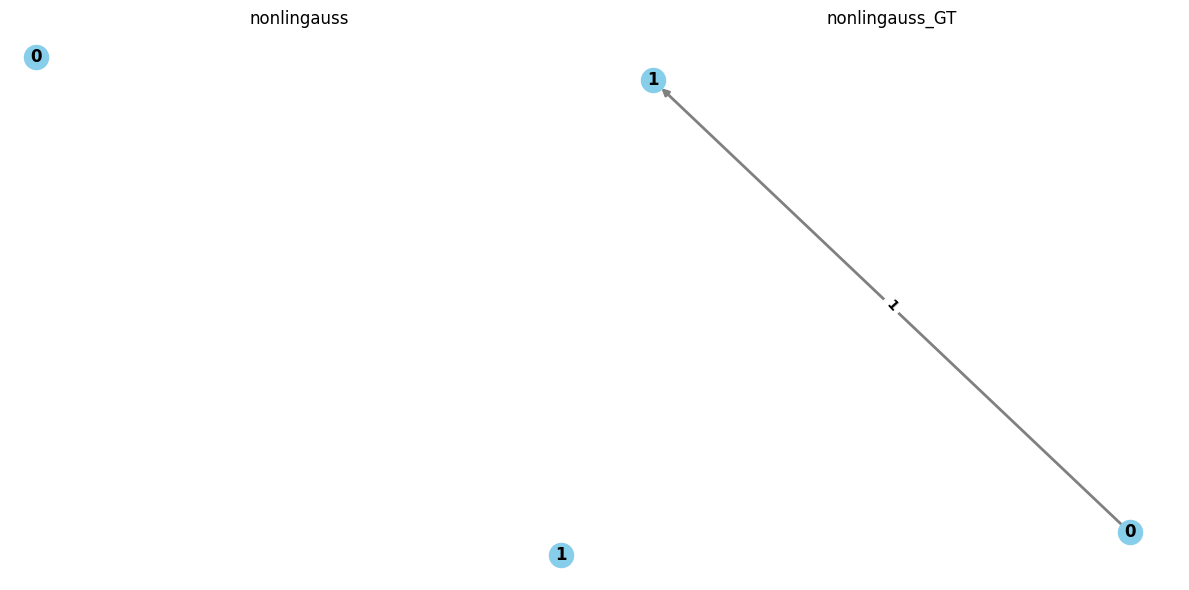

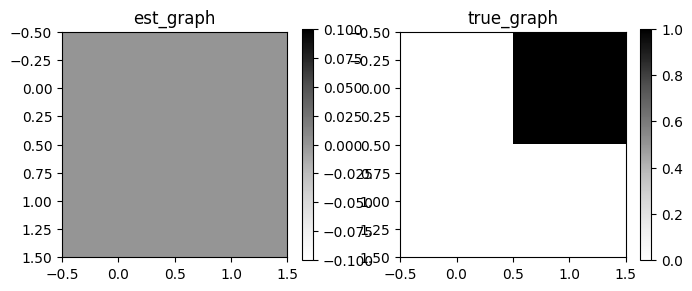

c:\Users\rubin\AppData\Local\Programs\Python\Python311\Lib\site-packages\castle\metrics\evaluation.py:224: RuntimeWarning: invalid value encountered in double_scalars
  precision = TP/TP_FP


In [ ]:
# With discretization
print("~~~~~ nonlingauss WITH DISCRETIZATION ~~~~~")
hart_est_adj_nonlingauss_gnn, gt_nonlingauss, hart_f1_scores_nonlingauss_gnn, hart_metrics_nonlingauss_gnn = dag_gnn_cs(dataset = nonlingauss, apply_hartemink_discretization=True)

# Without discretization
print("\n\n\n~~~~~ nonlingauss WITHOUT DISCRETIZATION ~~~~~")
est_adj_nonlingauss_gnn, gt_nonlingauss, f1_scores_nonlingauss_gnn, metrics_nonlingauss_gnn = dag_gnn_cs(dataset=nonlingauss, apply_hartemink_discretization=False)

<h5>nonlin_simpson</h5>

~~~~~ nonlin_simpson WITH DISCRETIZATION ~~~~~
Working on the 60th level of discretization.
Working on the 50th level of discretization.
Working on the 40th level of discretization.
Working on the 30th level of discretization.
Working on the 20th level of discretization.
Working on the 10th level of discretization.


2024-05-11 05:08:31,832 - c:\Users\rubin\AppData\Local\Programs\Python\Python311\Lib\site-packages\castle\algorithms\gradient\dag_gnn\torch\dag_gnn.py[line:167] - INFO: GPU is unavailable.
2024-05-11 05:08:58,193 - c:\Users\rubin\AppData\Local\Programs\Python\Python311\Lib\site-packages\castle\algorithms\gradient\dag_gnn\torch\dag_gnn.py[line:253] - INFO: Iter: 0, epoch: 299, h_new: 1.0
2024-05-11 05:09:24,207 - c:\Users\rubin\AppData\Local\Programs\Python\Python311\Lib\site-packages\castle\algorithms\gradient\dag_gnn\torch\dag_gnn.py[line:253] - INFO: Iter: 1, epoch: 299, h_new: 5.707817219580136e-05
2024-05-11 05:09:52,400 - c:\Users\rubin\AppData\Local\Programs\Python\Python311\Lib\site-packages\castle\algorithms\gradient\dag_gnn\torch\dag_gnn.py[line:253] - INFO: Iter: 2, epoch: 299, h_new: 5.707817219580136e-05
2024-05-11 05:10:43,919 - c:\Users\rubin\AppData\Local\Programs\Python\Python311\Lib\site-packages\castle\algorithms\gradient\dag_gnn\torch\dag_gnn.py[line:253] - INFO: Ite

{'adjacency_f1': 0.6666666666666666, 'orientation_f1': 0.3333333333333333}


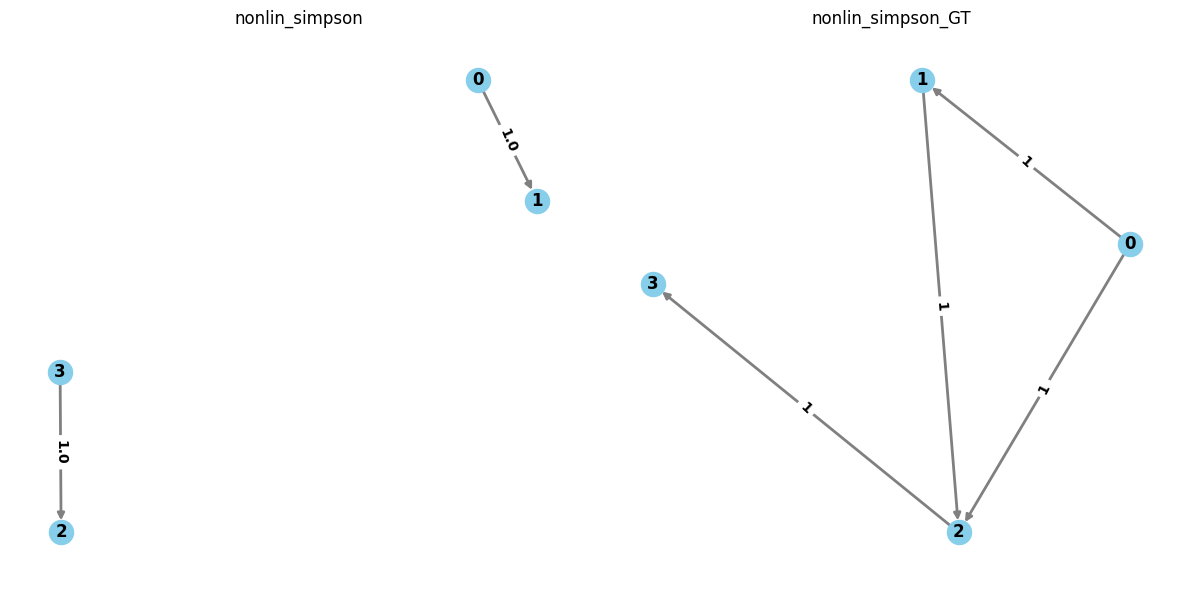

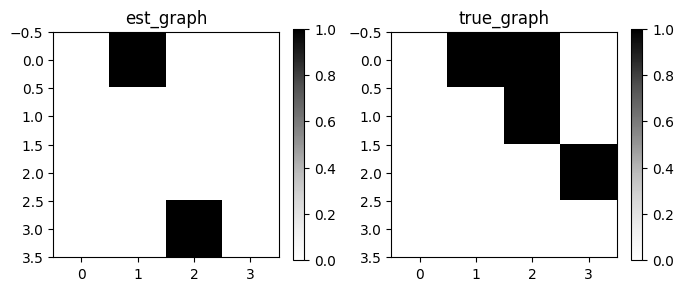

2024-05-11 05:16:25,585 - c:\Users\rubin\AppData\Local\Programs\Python\Python311\Lib\site-packages\castle\algorithms\gradient\dag_gnn\torch\dag_gnn.py[line:167] - INFO: GPU is unavailable.





~~~~~ nonlin_simpson WITHOUT DISCRETIZATION ~~~~~


2024-05-11 05:16:51,660 - c:\Users\rubin\AppData\Local\Programs\Python\Python311\Lib\site-packages\castle\algorithms\gradient\dag_gnn\torch\dag_gnn.py[line:253] - INFO: Iter: 0, epoch: 299, h_new: 0.021582472984277068
2024-05-11 05:17:44,224 - c:\Users\rubin\AppData\Local\Programs\Python\Python311\Lib\site-packages\castle\algorithms\gradient\dag_gnn\torch\dag_gnn.py[line:253] - INFO: Iter: 1, epoch: 299, h_new: 0.0014951658739636997
2024-05-11 05:18:36,695 - c:\Users\rubin\AppData\Local\Programs\Python\Python311\Lib\site-packages\castle\algorithms\gradient\dag_gnn\torch\dag_gnn.py[line:253] - INFO: Iter: 2, epoch: 299, h_new: 0.0001352836605299501
2024-05-11 05:19:27,793 - c:\Users\rubin\AppData\Local\Programs\Python\Python311\Lib\site-packages\castle\algorithms\gradient\dag_gnn\torch\dag_gnn.py[line:253] - INFO: Iter: 3, epoch: 299, h_new: 2.0886401776998298e-05
2024-05-11 05:20:23,060 - c:\Users\rubin\AppData\Local\Programs\Python\Python311\Lib\site-packages\castle\algorithms\gradien

{'adjacency_f1': 0.6666666666666665, 'orientation_f1': 0.22222222222222224}


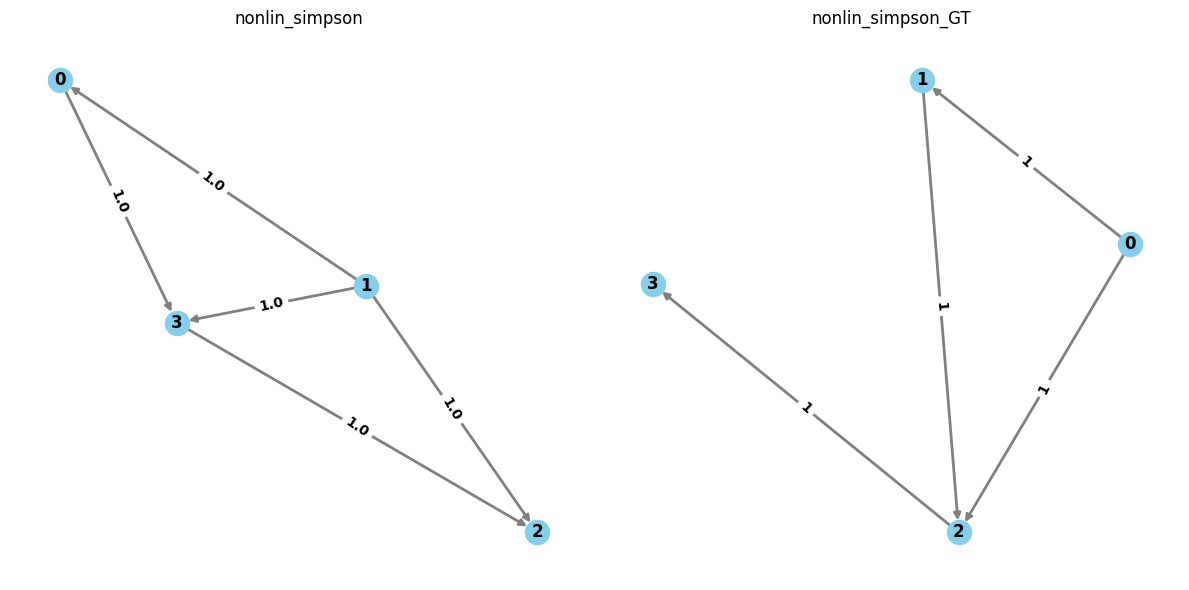

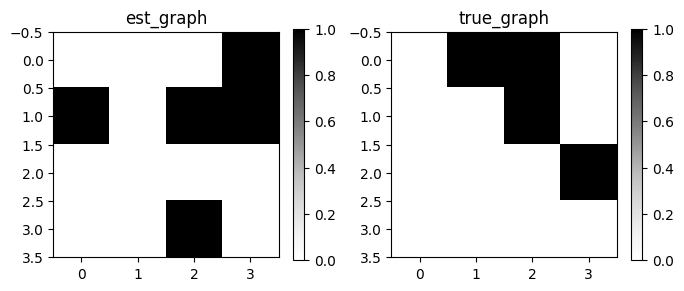

In [ ]:
# With discretization
print("~~~~~ nonlin_simpson WITH DISCRETIZATION ~~~~~")
hart_est_adj_nonlin_simpson_gnn, gt_nonlin_simpson, hart_f1_scores_nonlin_simpson_gnn, hart_metrics_nonlin_simpson_gnn = dag_gnn_cs(dataset = nonlin_simpson, apply_hartemink_discretization=True)

# Without discretization
print("\n\n\n~~~~~ nonlin_simpson WITHOUT DISCRETIZATION ~~~~~")
est_adj_nonlin_simpson_gnn, gt_nonlin_simpson, f1_scores_nonlin_simpson_gnn, metrics_nonlin_simpson_gnn = dag_gnn_cs(dataset=nonlin_simpson, apply_hartemink_discretization=False)

<h5>symprod_simpson</h5>

~~~~~ symprod_simpson WITH DISCRETIZATION ~~~~~
Working on the 60th level of discretization.
Working on the 50th level of discretization.
Working on the 40th level of discretization.
Working on the 30th level of discretization.
Working on the 20th level of discretization.
Working on the 10th level of discretization.


2024-05-11 05:27:58,820 - c:\Users\rubin\AppData\Local\Programs\Python\Python311\Lib\site-packages\castle\algorithms\gradient\dag_gnn\torch\dag_gnn.py[line:167] - INFO: GPU is unavailable.
2024-05-11 05:28:25,401 - c:\Users\rubin\AppData\Local\Programs\Python\Python311\Lib\site-packages\castle\algorithms\gradient\dag_gnn\torch\dag_gnn.py[line:253] - INFO: Iter: 0, epoch: 299, h_new: 1.0
2024-05-11 05:28:50,630 - c:\Users\rubin\AppData\Local\Programs\Python\Python311\Lib\site-packages\castle\algorithms\gradient\dag_gnn\torch\dag_gnn.py[line:253] - INFO: Iter: 1, epoch: 299, h_new: 9.087766244419981e-06
2024-05-11 05:29:43,565 - c:\Users\rubin\AppData\Local\Programs\Python\Python311\Lib\site-packages\castle\algorithms\gradient\dag_gnn\torch\dag_gnn.py[line:253] - INFO: Iter: 2, epoch: 299, h_new: 7.398347499076863e-07
2024-05-11 05:30:09,877 - c:\Users\rubin\AppData\Local\Programs\Python\Python311\Lib\site-packages\castle\algorithms\gradient\dag_gnn\torch\dag_gnn.py[line:253] - INFO: Ite

{'adjacency_f1': 0.888888888888889, 'orientation_f1': 0.888888888888889}


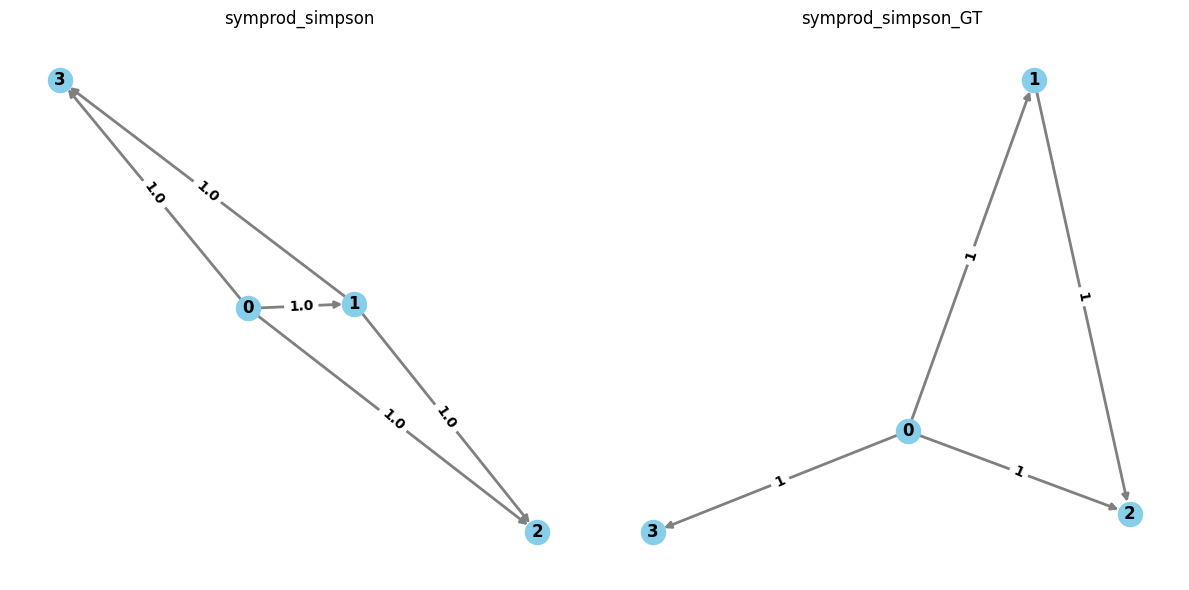

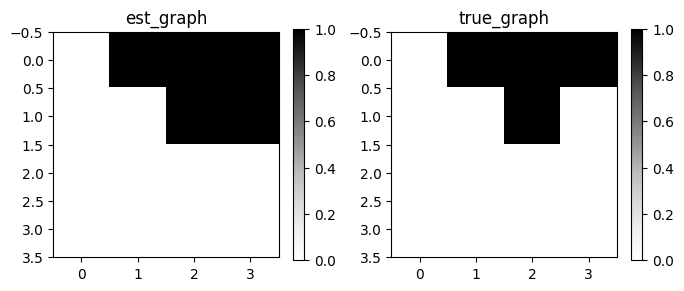

2024-05-11 05:34:41,448 - c:\Users\rubin\AppData\Local\Programs\Python\Python311\Lib\site-packages\castle\algorithms\gradient\dag_gnn\torch\dag_gnn.py[line:167] - INFO: GPU is unavailable.





~~~~~ symprod_simpson WITHOUT DISCRETIZATION ~~~~~


2024-05-11 05:35:09,223 - c:\Users\rubin\AppData\Local\Programs\Python\Python311\Lib\site-packages\castle\algorithms\gradient\dag_gnn\torch\dag_gnn.py[line:253] - INFO: Iter: 0, epoch: 299, h_new: 1.0
2024-05-11 05:35:36,756 - c:\Users\rubin\AppData\Local\Programs\Python\Python311\Lib\site-packages\castle\algorithms\gradient\dag_gnn\torch\dag_gnn.py[line:253] - INFO: Iter: 1, epoch: 299, h_new: 1.805688060141364e-05
2024-05-11 05:36:29,540 - c:\Users\rubin\AppData\Local\Programs\Python\Python311\Lib\site-packages\castle\algorithms\gradient\dag_gnn\torch\dag_gnn.py[line:253] - INFO: Iter: 2, epoch: 299, h_new: 2.02462296083894e-06
2024-05-11 05:36:57,640 - c:\Users\rubin\AppData\Local\Programs\Python\Python311\Lib\site-packages\castle\algorithms\gradient\dag_gnn\torch\dag_gnn.py[line:253] - INFO: Iter: 3, epoch: 299, h_new: 2.02462296083894e-06
2024-05-11 05:37:23,968 - c:\Users\rubin\AppData\Local\Programs\Python\Python311\Lib\site-packages\castle\algorithms\gradient\dag_gnn\torch\dag_

{'adjacency_f1': 0.5714285714285715, 'orientation_f1': 0.5714285714285715}


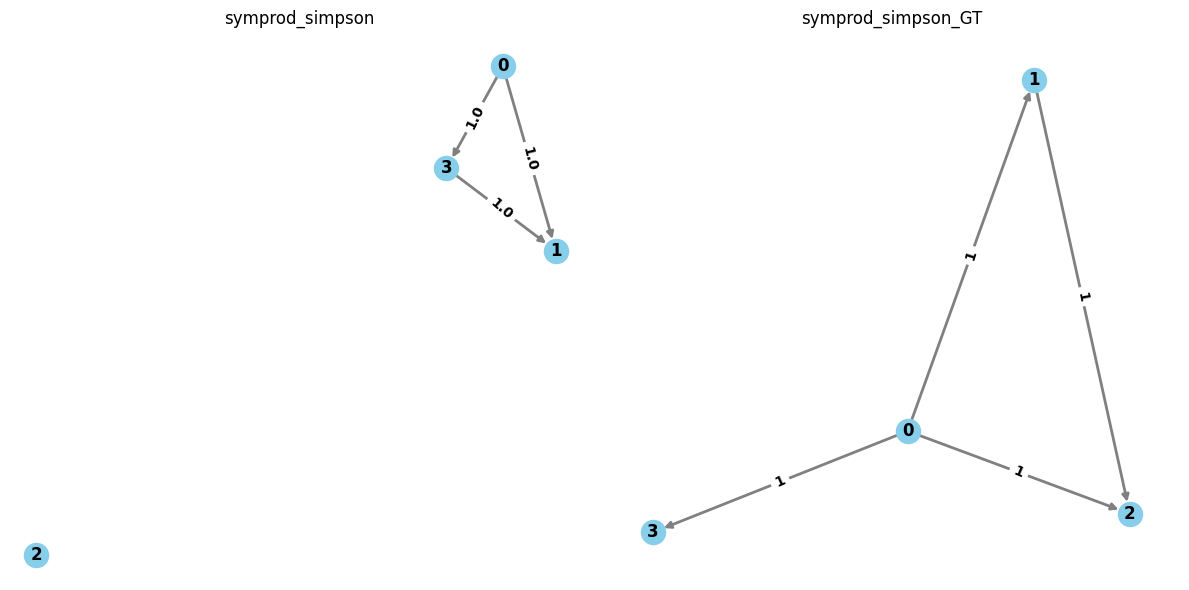

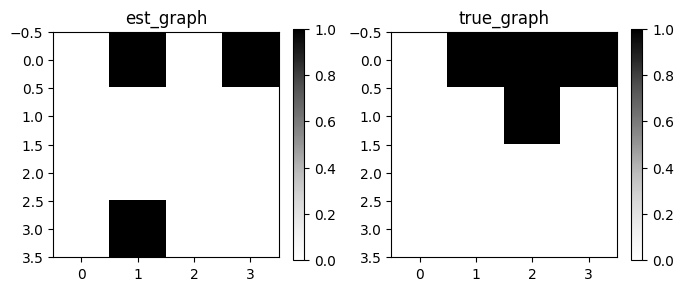

In [ ]:
# With discretization
print("~~~~~ symprod_simpson WITH DISCRETIZATION ~~~~~")
hart_est_adj_symprod_simpson_gnn, gt_symprod_simpson, hart_f1_scores_symprod_simpson_gnn, hart_metrics_symprod_simpson_gnn = dag_gnn_cs(dataset = symprod_simpson, apply_hartemink_discretization=True)

# Without discretization
print("\n\n\n~~~~~ symprod_simpson WITHOUT DISCRETIZATION ~~~~~")
est_adj_symprod_simpson_gnn, gt_symprod_simpson, f1_scores_symprod_simpson_gnn, metrics_symprod_simpson_gnn = dag_gnn_cs(dataset=symprod_simpson, apply_hartemink_discretization=False)

<h5>large_backdoor</h5>

~~~~~ large_backdoor WITH DISCRETIZATION ~~~~~
Working on the 60th level of discretization.
Working on the 50th level of discretization.
Working on the 40th level of discretization.
Working on the 30th level of discretization.
Working on the 20th level of discretization.
Working on the 10th level of discretization.


2024-05-11 06:05:31,916 - c:\Users\rubin\AppData\Local\Programs\Python\Python311\Lib\site-packages\castle\algorithms\gradient\dag_gnn\torch\dag_gnn.py[line:167] - INFO: GPU is unavailable.
2024-05-11 06:06:08,837 - c:\Users\rubin\AppData\Local\Programs\Python\Python311\Lib\site-packages\castle\algorithms\gradient\dag_gnn\torch\dag_gnn.py[line:253] - INFO: Iter: 0, epoch: 299, h_new: 0.012999508302378615
2024-05-11 06:07:25,432 - c:\Users\rubin\AppData\Local\Programs\Python\Python311\Lib\site-packages\castle\algorithms\gradient\dag_gnn\torch\dag_gnn.py[line:253] - INFO: Iter: 1, epoch: 299, h_new: 0.000968880232086633
2024-05-11 06:08:41,097 - c:\Users\rubin\AppData\Local\Programs\Python\Python311\Lib\site-packages\castle\algorithms\gradient\dag_gnn\torch\dag_gnn.py[line:253] - INFO: Iter: 2, epoch: 299, h_new: 0.0001809798477232505
2024-05-11 06:10:23,825 - c:\Users\rubin\AppData\Local\Programs\Python\Python311\Lib\site-packages\castle\algorithms\gradient\dag_gnn\torch\dag_gnn.py[line:

{'adjacency_f1': 0.823529411764706, 'orientation_f1': 0.7058823529411765}


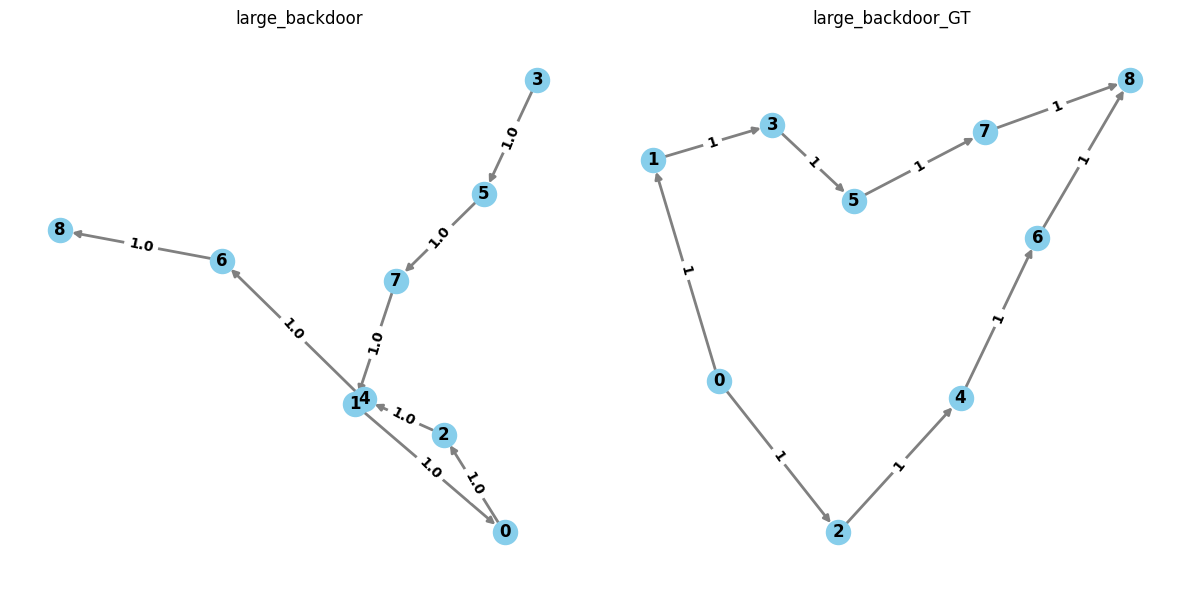

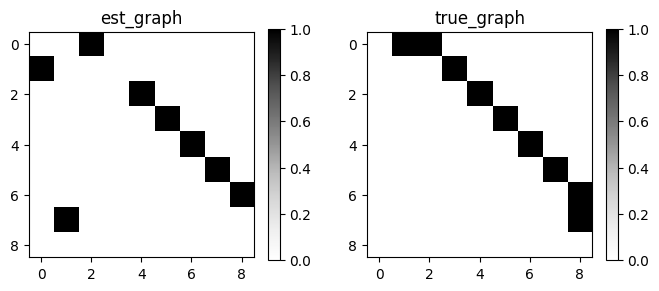

2024-05-11 06:17:56,231 - c:\Users\rubin\AppData\Local\Programs\Python\Python311\Lib\site-packages\castle\algorithms\gradient\dag_gnn\torch\dag_gnn.py[line:167] - INFO: GPU is unavailable.





~~~~~ large_backdoor WITHOUT DISCRETIZATION ~~~~~


2024-05-11 06:18:31,054 - c:\Users\rubin\AppData\Local\Programs\Python\Python311\Lib\site-packages\castle\algorithms\gradient\dag_gnn\torch\dag_gnn.py[line:253] - INFO: Iter: 0, epoch: 299, h_new: 1.0
2024-05-11 06:19:06,388 - c:\Users\rubin\AppData\Local\Programs\Python\Python311\Lib\site-packages\castle\algorithms\gradient\dag_gnn\torch\dag_gnn.py[line:253] - INFO: Iter: 1, epoch: 299, h_new: 0.0001636038840260312
2024-05-11 06:20:58,124 - c:\Users\rubin\AppData\Local\Programs\Python\Python311\Lib\site-packages\castle\algorithms\gradient\dag_gnn\torch\dag_gnn.py[line:253] - INFO: Iter: 2, epoch: 299, h_new: 2.558670395025331e-05
2024-05-11 06:23:48,026 - c:\Users\rubin\AppData\Local\Programs\Python\Python311\Lib\site-packages\castle\algorithms\gradient\dag_gnn\torch\dag_gnn.py[line:253] - INFO: Iter: 3, epoch: 299, h_new: 1.6053335070154162e-06
2024-05-11 06:25:29,609 - c:\Users\rubin\AppData\Local\Programs\Python\Python311\Lib\site-packages\castle\algorithms\gradient\dag_gnn\torch\d

{'adjacency_f1': 0.5714285714285714, 'orientation_f1': 0.42857142857142855}


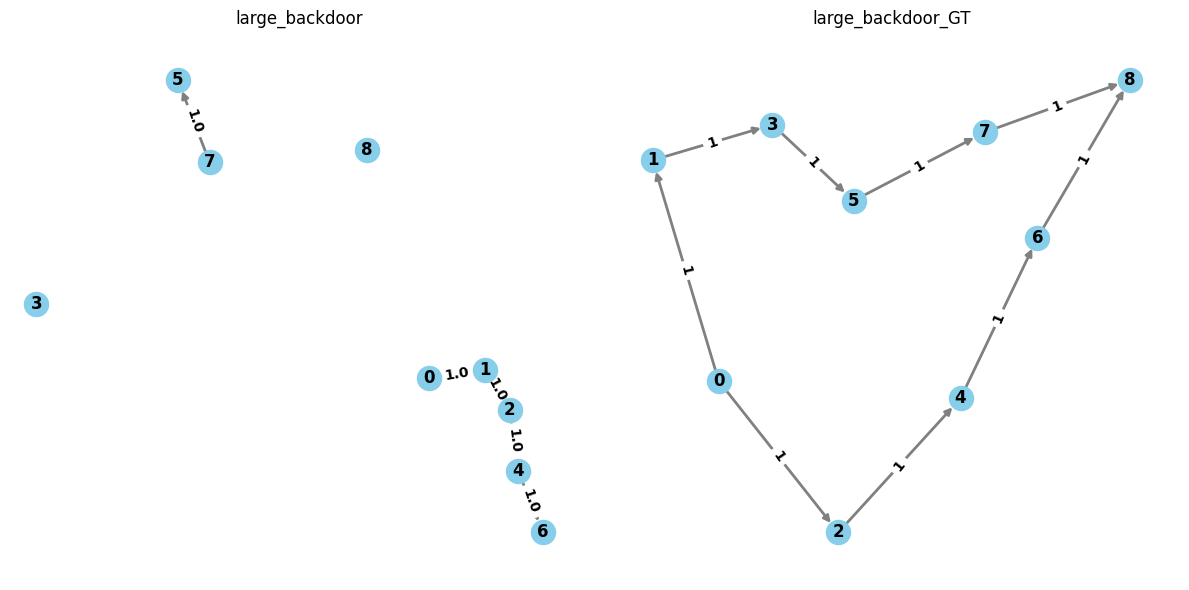

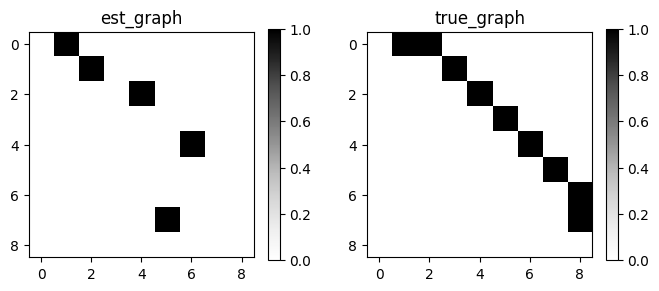

In [ ]:
# With discretization
print("~~~~~ large_backdoor WITH DISCRETIZATION ~~~~~")
hart_est_adj_large_backdoor_gnn, gt_large_backdoor, hart_f1_scores_large_backdoor_gnn, hart_metrics_large_backdoor_gnn = dag_gnn_cs(dataset = large_backdoor, apply_hartemink_discretization=True)

# Without discretization
print("\n\n\n~~~~~ large_backdoor WITHOUT DISCRETIZATION ~~~~~")
est_adj_large_backdoor_gnn, gt_large_backdoor, f1_scores_large_backdoor_gnn, metrics_large_backdoor_gnn = dag_gnn_cs(dataset=large_backdoor, apply_hartemink_discretization=False)

<h5>weak_arrows</h5>

~~~~~ weak_arrows WITH DISCRETIZATION ~~~~~
Working on the 60th level of discretization.
Working on the 50th level of discretization.
Working on the 40th level of discretization.
Working on the 30th level of discretization.
Working on the 20th level of discretization.
Working on the 10th level of discretization.


2024-05-11 06:48:39,347 - c:\Users\rubin\AppData\Local\Programs\Python\Python311\Lib\site-packages\castle\algorithms\gradient\dag_gnn\torch\dag_gnn.py[line:167] - INFO: GPU is unavailable.
2024-05-11 06:49:13,480 - c:\Users\rubin\AppData\Local\Programs\Python\Python311\Lib\site-packages\castle\algorithms\gradient\dag_gnn\torch\dag_gnn.py[line:253] - INFO: Iter: 0, epoch: 299, h_new: 1.0
2024-05-11 06:49:46,684 - c:\Users\rubin\AppData\Local\Programs\Python\Python311\Lib\site-packages\castle\algorithms\gradient\dag_gnn\torch\dag_gnn.py[line:253] - INFO: Iter: 1, epoch: 299, h_new: 8.058643273045618e-05
2024-05-11 06:50:20,900 - c:\Users\rubin\AppData\Local\Programs\Python\Python311\Lib\site-packages\castle\algorithms\gradient\dag_gnn\torch\dag_gnn.py[line:253] - INFO: Iter: 2, epoch: 299, h_new: 8.058643273045618e-05
2024-05-11 06:50:55,787 - c:\Users\rubin\AppData\Local\Programs\Python\Python311\Lib\site-packages\castle\algorithms\gradient\dag_gnn\torch\dag_gnn.py[line:253] - INFO: Ite

{'adjacency_f1': 0.5454545454545455, 'orientation_f1': 0.4545454545454545}


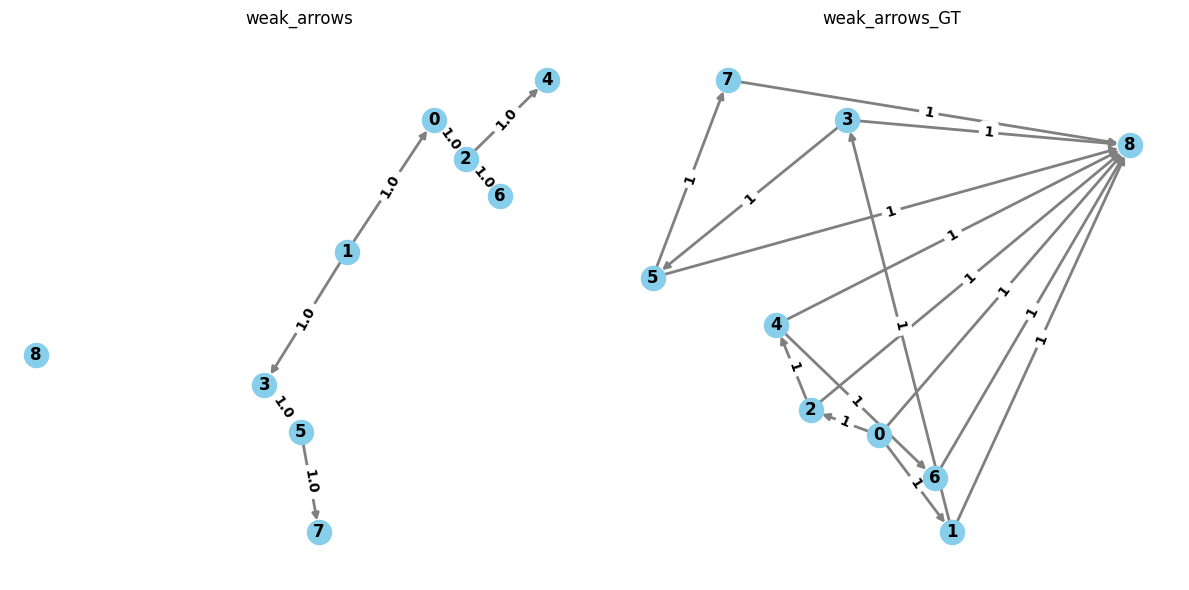

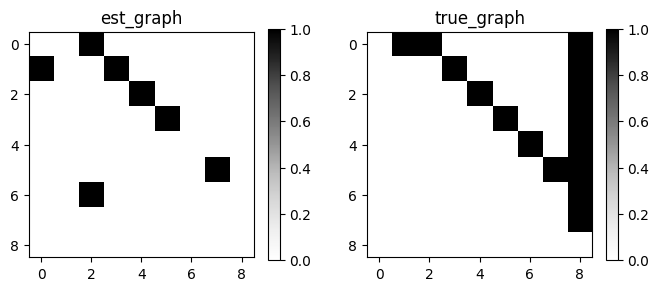

2024-05-11 06:59:02,823 - c:\Users\rubin\AppData\Local\Programs\Python\Python311\Lib\site-packages\castle\algorithms\gradient\dag_gnn\torch\dag_gnn.py[line:167] - INFO: GPU is unavailable.





~~~~~ weak_arrows WITHOUT DISCRETIZATION ~~~~~


2024-05-11 06:59:36,505 - c:\Users\rubin\AppData\Local\Programs\Python\Python311\Lib\site-packages\castle\algorithms\gradient\dag_gnn\torch\dag_gnn.py[line:253] - INFO: Iter: 0, epoch: 299, h_new: 0.030106181484232053
2024-05-11 07:00:10,555 - c:\Users\rubin\AppData\Local\Programs\Python\Python311\Lib\site-packages\castle\algorithms\gradient\dag_gnn\torch\dag_gnn.py[line:253] - INFO: Iter: 1, epoch: 299, h_new: 0.030106181484232053
2024-05-11 07:00:46,395 - c:\Users\rubin\AppData\Local\Programs\Python\Python311\Lib\site-packages\castle\algorithms\gradient\dag_gnn\torch\dag_gnn.py[line:253] - INFO: Iter: 2, epoch: 299, h_new: 0.005062000975740943
2024-05-11 07:01:56,085 - c:\Users\rubin\AppData\Local\Programs\Python\Python311\Lib\site-packages\castle\algorithms\gradient\dag_gnn\torch\dag_gnn.py[line:253] - INFO: Iter: 3, epoch: 299, h_new: 0.002936639041481115
2024-05-11 07:02:31,081 - c:\Users\rubin\AppData\Local\Programs\Python\Python311\Lib\site-packages\castle\algorithms\gradient\da

{'adjacency_f1': 0.7200000000000001, 'orientation_f1': 0.64}


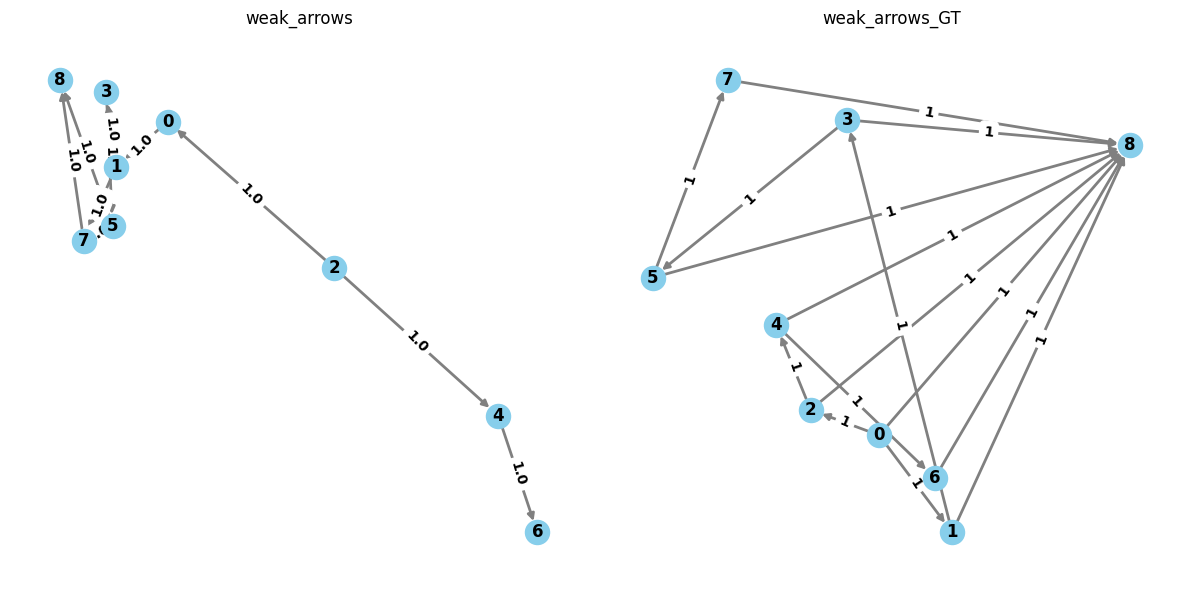

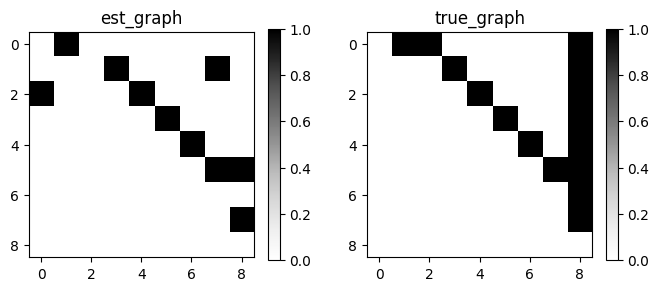

In [ ]:
# With discretization
print("~~~~~ weak_arrows WITH DISCRETIZATION ~~~~~")
hart_est_adj_weak_arrows_gnn, gt_weak_arrows, hart_f1_scores_weak_arrows_gnn, hart_metrics_weak_arrows_gnn = dag_gnn_cs(dataset = weak_arrows, apply_hartemink_discretization=True)

# Without discretization
print("\n\n\n~~~~~ weak_arrows WITHOUT DISCRETIZATION ~~~~~")
est_adj_weak_arrows_gnn, gt_weak_arrows, f1_scores_weak_arrows_gnn, metrics_weak_arrows_gnn = dag_gnn_cs(dataset=weak_arrows, apply_hartemink_discretization=False)

<h4>Let's plot the adjagency and orientation f1 scores of DAG-GNN for all datasets, with and without Hartemink Discretization.</h4>

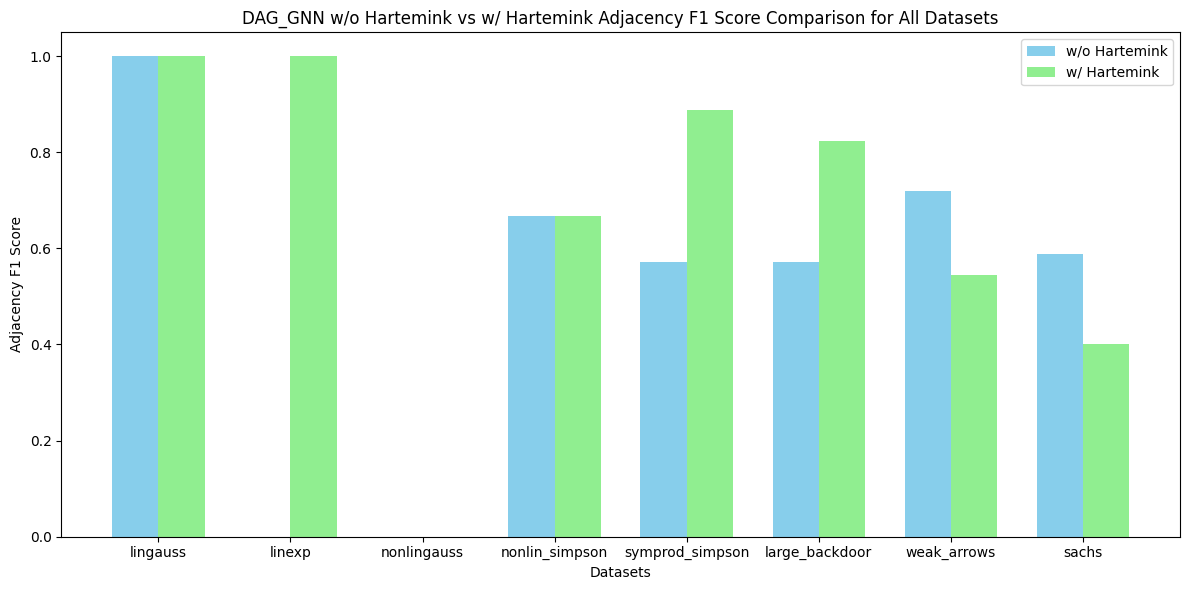

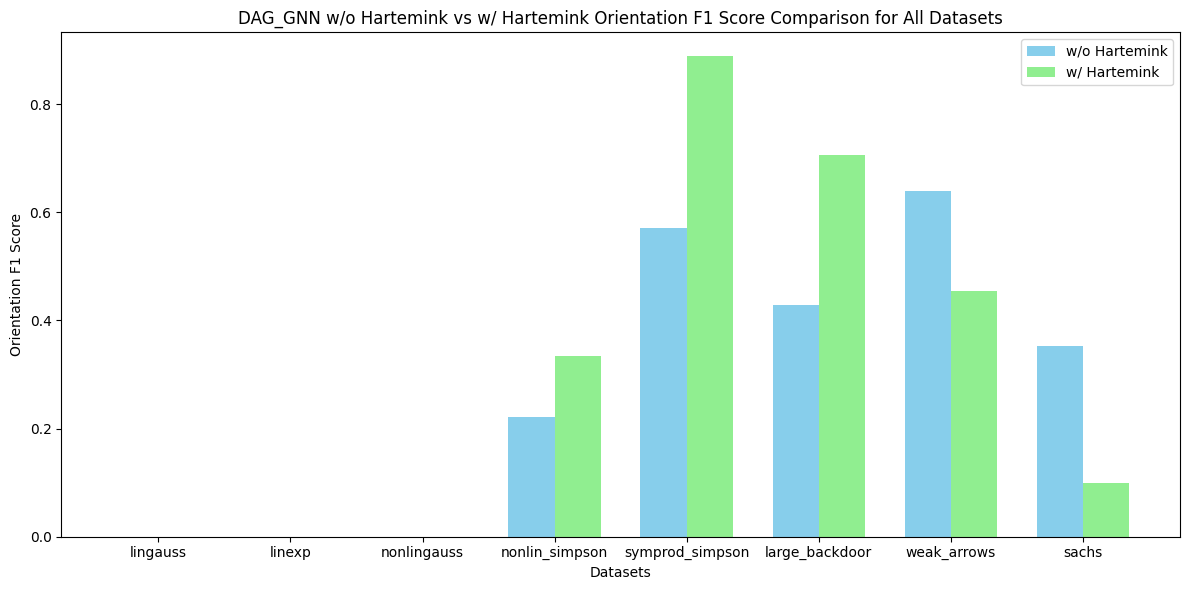

In [ ]:
f1_scores_all_gnn = [f1_scores_lingauss_gnn, f1_scores_linexp_gnn, f1_scores_nonlingauss_gnn, f1_scores_nonlin_simpson_gnn, f1_scores_symprod_simpson_gnn, f1_scores_large_backdoor_gnn, f1_scores_weak_arrows_gnn ]
f1_scores_all_hartemink_gnn = [hart_f1_scores_lingauss_gnn, hart_f1_scores_linexp_gnn, hart_f1_scores_nonlingauss_gnn, hart_f1_scores_nonlin_simpson_gnn, hart_f1_scores_symprod_simpson_gnn, hart_f1_scores_large_backdoor_gnn, hart_f1_scores_weak_arrows_gnn ]

all_datasets = [i.__name__ for i in datasets] + ['sachs']

DAG_GNN_adjacency = [d['adjacency_f1'] for d in f1_scores_all_gnn] + [f1_scores_sachs_gnn['adjacency_f1']]
#print(GAE_adjacency)
DAG_GNN_adjacency_hart = [d['adjacency_f1'] for d in f1_scores_all_hartemink_gnn] + [hart_f1_scores_sachs_gnn['adjacency_f1']]

DAG_GNN_orientation = [d['orientation_f1'] for d in f1_scores_all_gnn] + [f1_scores_sachs_gnn['orientation_f1']]
DAG_GNN_orientation_hart = [d['orientation_f1'] for d in f1_scores_all_hartemink_gnn] + [hart_f1_scores_sachs_gnn['orientation_f1']]

# Define colors
colors = ['skyblue', 'lightgreen']
bar_width = 0.35
index = range(len(all_datasets))

# Plot sequence F1 scores
plt.figure(figsize=(12, 6))

plt.bar(index, DAG_GNN_adjacency, bar_width, label='w/o Hartemink', color=colors[0])
plt.bar([i + bar_width for i in index], DAG_GNN_adjacency_hart, bar_width, label='w/ Hartemink', color=colors[1])

plt.xlabel('Datasets')
plt.ylabel('Adjacency F1 Score')
plt.title('DAG_GNN w/o Hartemink vs w/ Hartemink Adjacency F1 Score Comparison for All Datasets')
plt.xticks([i + bar_width / 2 for i in index], all_datasets)
plt.legend()

plt.tight_layout()
plt.show()

# Plot unrolled F1 scores
plt.figure(figsize=(12, 6))

plt.bar(index, DAG_GNN_orientation, bar_width, label='w/o Hartemink', color=colors[0])
plt.bar([i + bar_width for i in index], DAG_GNN_orientation_hart, bar_width, label='w/ Hartemink', color=colors[1])

plt.xlabel('Datasets')
plt.ylabel('Orientation F1 Score')
plt.title('DAG_GNN w/o Hartemink vs w/ Hartemink Orientation F1 Score Comparison for All Datasets')
plt.xticks([i + bar_width / 2 for i in index], all_datasets)
plt.legend()

plt.tight_layout()
plt.show()

<h4>Let's plot the SHD scores of GAE and DAG-GNN for all datasets, with and without Hartemink Discretization.</h4>

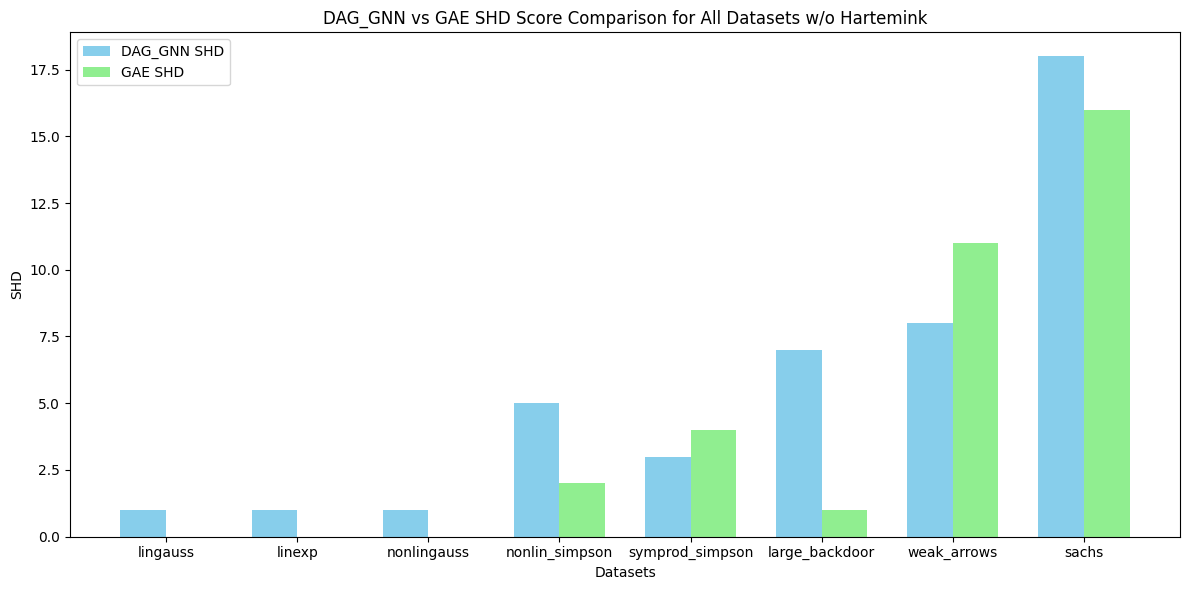

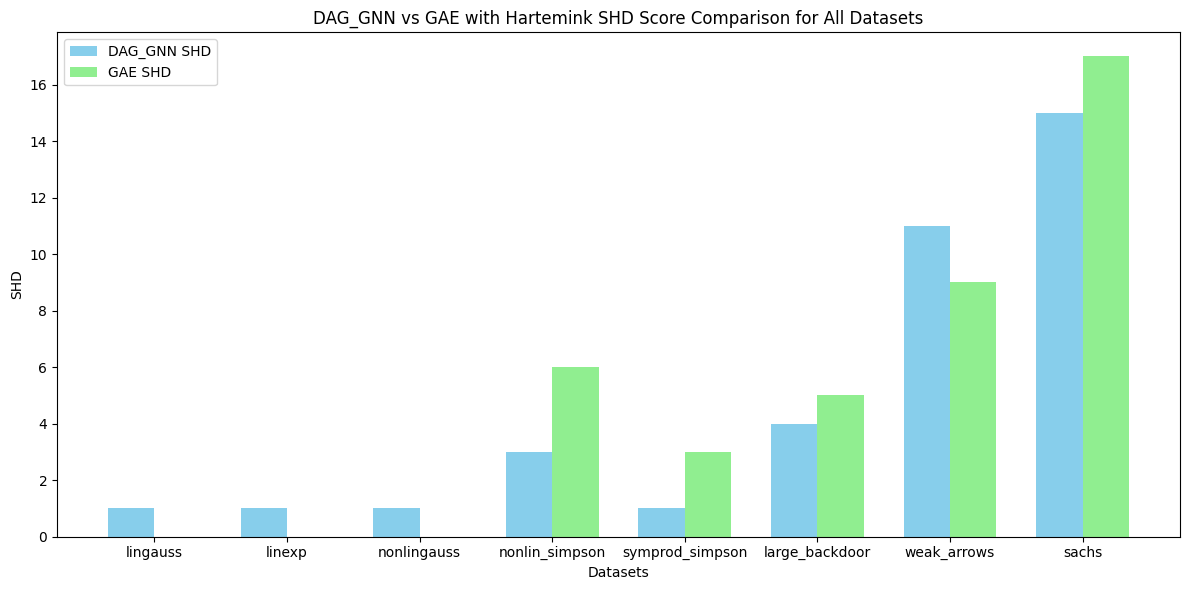

In [ ]:
shd_scores_all_gnn = [metrics_lingauss_gnn.metrics['shd'], metrics_linexp_gnn.metrics['shd'], metrics_nonlingauss_gnn.metrics['shd'], metrics_nonlin_simpson_gnn.metrics['shd'], metrics_symprod_simpson_gnn.metrics['shd'], metrics_large_backdoor_gnn.metrics['shd'], metrics_weak_arrows_gnn.metrics['shd']]
shd_scores_all_hartemink_gnn = [hart_metrics_lingauss_gnn.metrics['shd'], hart_metrics_linexp_gnn.metrics['shd'], hart_metrics_nonlingauss_gnn.metrics['shd'], hart_metrics_nonlin_simpson_gnn.metrics['shd'], hart_metrics_symprod_simpson_gnn.metrics['shd'], hart_metrics_large_backdoor_gnn.metrics['shd'], hart_metrics_weak_arrows_gnn.metrics['shd']]

shd_scores_all_gae = [metrics_lingauss.metrics['shd'], metrics_linexp.metrics['shd'], metrics_nonlingauss.metrics['shd'], metrics_nonlin_simpson.metrics['shd'], metrics_symprod_simpson.metrics['shd'], metrics_large_backdoor.metrics['shd'], metrics_weak_arrows.metrics['shd']]
shd_scores_all_hartemink_gae = [hart_metrics_lingauss.metrics['shd'], hart_metrics_linexp.metrics['shd'], hart_metrics_nonlingauss.metrics['shd'], hart_metrics_nonlin_simpson.metrics['shd'], hart_metrics_symprod_simpson.metrics['shd'], hart_metrics_large_backdoor.metrics['shd'], hart_metrics_weak_arrows.metrics['shd']]

all_datasets = [i.__name__ for i in datasets] + ['sachs']

DAG_GNN_shd = [d for d in shd_scores_all_gnn] + [metrics_sachs_gnn.metrics['shd']]
DAG_GNN_shd_hart = [d for d in shd_scores_all_hartemink_gnn] + [hart_metrics_sachs_gnn.metrics['shd']]

GAE_shd = [d for d in shd_scores_all_gae] + [metrics_sachs.metrics['shd']]
GAE_shd_hart = [d for d in shd_scores_all_hartemink_gae] + [hart_metrics_sachs.metrics['shd']]

# Define colors
colors = ['skyblue', 'lightgreen']
bar_width = 0.35
index = range(len(all_datasets))

# Plot sequence F1 scores
plt.figure(figsize=(12, 6))

plt.bar(index, DAG_GNN_shd, bar_width, label='DAG_GNN SHD', color=colors[0])
plt.bar([i + bar_width for i in index], GAE_shd, bar_width, label='GAE SHD', color=colors[1])

plt.xlabel('Datasets')
plt.ylabel('SHD')
plt.title('DAG_GNN vs GAE SHD Score Comparison for All Datasets w/o Hartemink')
plt.xticks([i + bar_width / 2 for i in index], all_datasets)
plt.legend()

plt.tight_layout()
plt.show()

# Plot unrolled F1 scores
plt.figure(figsize=(12, 6))

plt.bar(index, DAG_GNN_shd_hart, bar_width, label='DAG_GNN SHD', color=colors[0])
plt.bar([i + bar_width for i in index], GAE_shd_hart, bar_width, label='GAE SHD', color=colors[1])

plt.xlabel('Datasets')
plt.ylabel('SHD')
plt.title('DAG_GNN vs GAE with Hartemink SHD Score Comparison for All Datasets')
plt.xticks([i + bar_width / 2 for i in index], all_datasets)
plt.legend()

plt.tight_layout()
plt.show()

<h4>Let's plot the TPR scores of GAE and DAG-GNN for all datasets, with and without Hartemink Discretization.</h4>

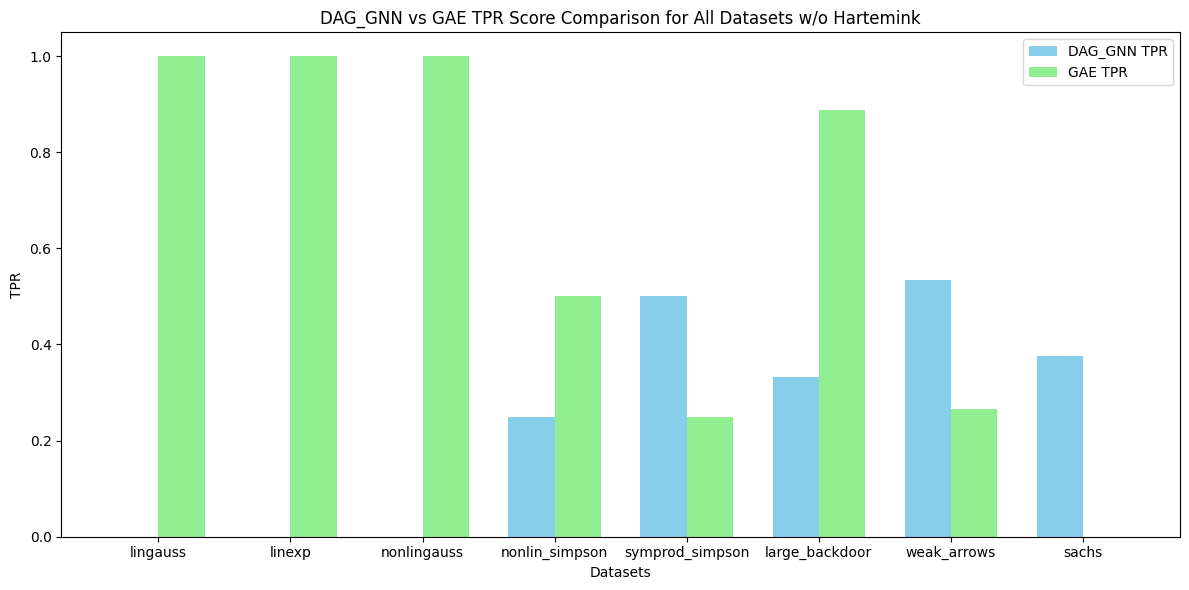

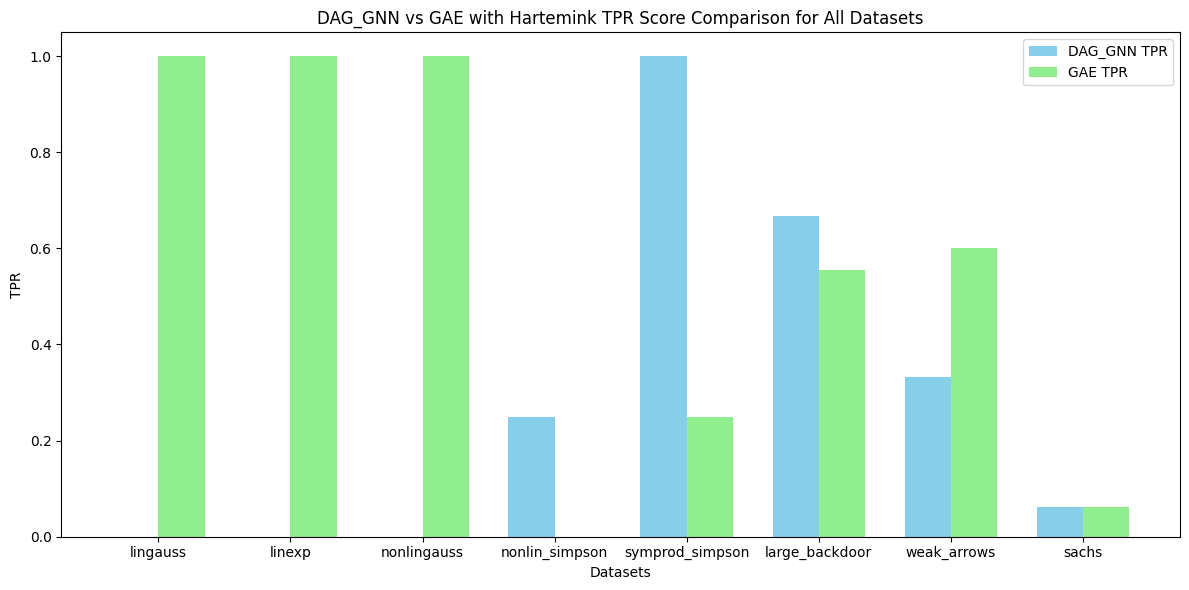

In [ ]:
tpr_scores_all_gnn = [metrics_lingauss_gnn.metrics['tpr'], metrics_linexp_gnn.metrics['tpr'], metrics_nonlingauss_gnn.metrics['tpr'], metrics_nonlin_simpson_gnn.metrics['tpr'], metrics_symprod_simpson_gnn.metrics['tpr'], metrics_large_backdoor_gnn.metrics['tpr'], metrics_weak_arrows_gnn.metrics['tpr']]
tpr_scores_all_hartemink_gnn = [hart_metrics_lingauss_gnn.metrics['tpr'], hart_metrics_linexp_gnn.metrics['tpr'], hart_metrics_nonlingauss_gnn.metrics['tpr'], hart_metrics_nonlin_simpson_gnn.metrics['tpr'], hart_metrics_symprod_simpson_gnn.metrics['tpr'], hart_metrics_large_backdoor_gnn.metrics['tpr'], hart_metrics_weak_arrows_gnn.metrics['tpr']]

tpr_scores_all_gae = [metrics_lingauss.metrics['tpr'], metrics_linexp.metrics['tpr'], metrics_nonlingauss.metrics['tpr'], metrics_nonlin_simpson.metrics['tpr'], metrics_symprod_simpson.metrics['tpr'], metrics_large_backdoor.metrics['tpr'], metrics_weak_arrows.metrics['tpr']]
tpr_scores_all_hartemink_gae = [hart_metrics_lingauss.metrics['tpr'], hart_metrics_linexp.metrics['tpr'], hart_metrics_nonlingauss.metrics['tpr'], hart_metrics_nonlin_simpson.metrics['tpr'], hart_metrics_symprod_simpson.metrics['tpr'], hart_metrics_large_backdoor.metrics['tpr'], hart_metrics_weak_arrows.metrics['tpr']]

all_datasets = [i.__name__ for i in datasets] + ['sachs']

DAG_GNN_shd = [d for d in tpr_scores_all_gnn] + [metrics_sachs_gnn.metrics['tpr']]
DAG_GNN_shd_hart = [d for d in tpr_scores_all_hartemink_gnn] + [hart_metrics_sachs_gnn.metrics['tpr']]

GAE_shd = [d for d in tpr_scores_all_gae] + [metrics_sachs.metrics['tpr']]
GAE_shd_hart = [d for d in tpr_scores_all_hartemink_gae] + [hart_metrics_sachs.metrics['tpr']]

# Define colors
colors = ['skyblue', 'lightgreen']
bar_width = 0.35
index = range(len(all_datasets))

# Plot sequence F1 scores
plt.figure(figsize=(12, 6))

plt.bar(index, DAG_GNN_shd, bar_width, label='DAG_GNN TPR', color=colors[0])
plt.bar([i + bar_width for i in index], GAE_shd, bar_width, label='GAE TPR', color=colors[1])

plt.xlabel('Datasets')
plt.ylabel('TPR')
plt.title('DAG_GNN vs GAE TPR Score Comparison for All Datasets w/o Hartemink')
plt.xticks([i + bar_width / 2 for i in index], all_datasets)
plt.legend()

plt.tight_layout()
plt.show()

# Plot unrolled F1 scores
plt.figure(figsize=(12, 6))

plt.bar(index, DAG_GNN_shd_hart, bar_width, label='DAG_GNN TPR', color=colors[0])
plt.bar([i + bar_width for i in index], GAE_shd_hart, bar_width, label='GAE TPR', color=colors[1])

plt.xlabel('Datasets')
plt.ylabel('TPR')
plt.title('DAG_GNN vs GAE with Hartemink TPR Score Comparison for All Datasets')
plt.xticks([i + bar_width / 2 for i in index], all_datasets)
plt.legend()

plt.tight_layout()
plt.show()

<h1>Fine Tuning</h1>

<p>GAE</p>

In [2]:
best_results_gae = {}
best_results_gae = gae_tuning()

Best results for nonlin_simpson:
Best results for symprod_simpson:
Best results for large_backdoor:
Best results for weak_arrows:


<p>Due to lack of time i chose to perform the fine tuning with a reduced number of samples: 500 instead of 2000, and with a smaller number of iterations for the training.</p>
<p>Another choice that i made was to perform the fine tuning only on the last 4 sets since for Lingauss, Linexp and nonLingauss it did not matter which parameters were used because the results were always the same, which can make sense since there is only one link between the 2 nodes.</p>

In [ ]:
for dataset_name, result in best_results_gae.items():
    print(f"Best results for {dataset_name}:")
    print(f"  Best adj score: {result['best_adj_score']}")
    print("  Best parameters:")
    for param_name, param_value in result['best_params_adj'].items():
        print(f"    {param_name}: {param_value}")


for dataset_name, result in best_results_gae.items():
    print(f"Best results for {dataset_name}:")
    print(f"  Best orientation score: {result['best_orientation_score']}")
    print("  Best parameters:")
    for param_name, param_value in result['best_params_or'].items():
        print(f"    {param_name}: {param_value}")

~~~~~ Tuned nonlin_simpson WITHOUT DISCRETIZATION ~~~~~
{'adjacency_f1': 0.888888888888889, 'orientation_f1': 0.4444444444444445}


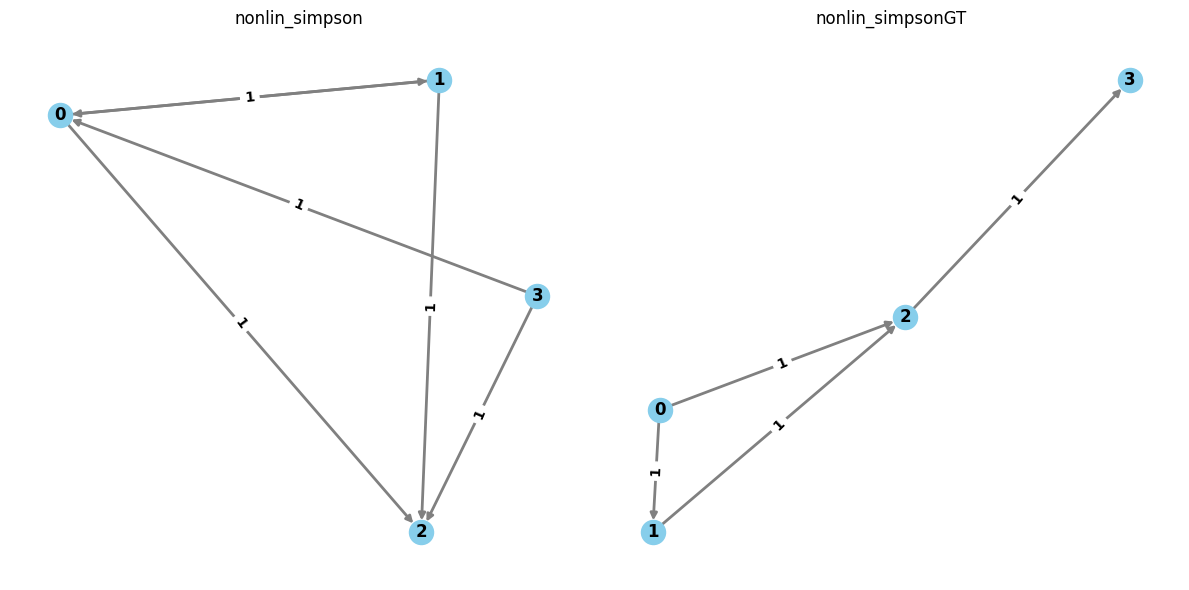

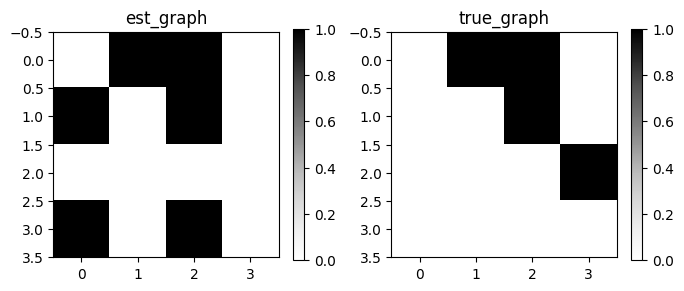

~~~~~ Tuned nonlin_simpson WITH DISCRETIZATION ~~~~~
Working on the 60th level of discretization.
Working on the 50th level of discretization.
Working on the 40th level of discretization.
Working on the 30th level of discretization.
Working on the 20th level of discretization.
Working on the 10th level of discretization.
{'adjacency_f1': 0.6666666666666666, 'orientation_f1': 0.0}


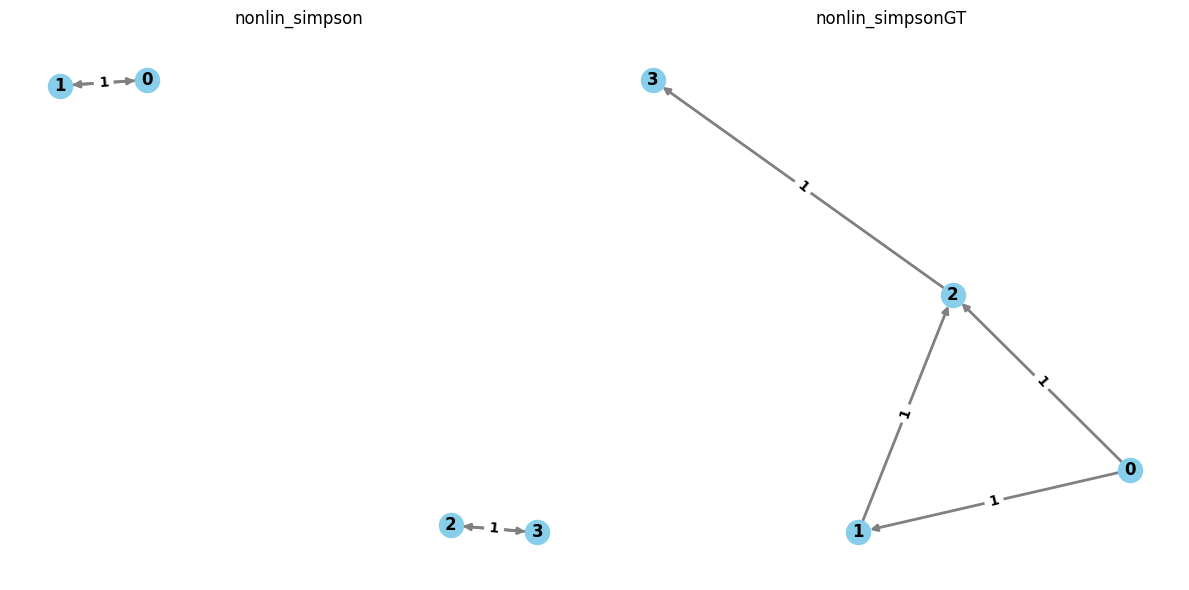

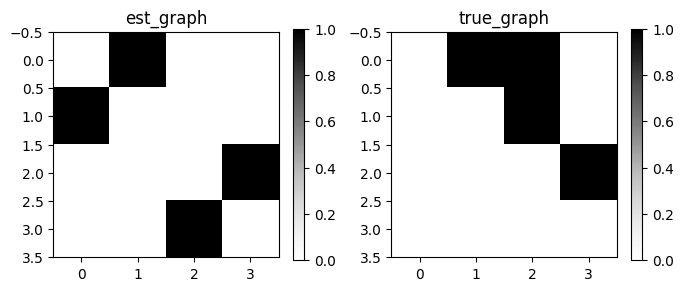

In [ ]:
# Without discretization
print("~~~~~ Tuned nonlin_simpson WITHOUT DISCRETIZATION ~~~~~")
est_adj_nonlin_simpson_gae_tuned, gt_nonlin_simpson, f1_scores_nonlin_simpson_gae_tuned, metrics_nonlin_simpson_gae_tuned = gae_cs(dataset = nonlin_simpson, apply_hartemink_discretization=False,  beta = 2.5, gamma = 0.45, hidden_dim=4, samples=2000, update_freq=200)

#With discretization
print("~~~~~ Tuned nonlin_simpson WITH DISCRETIZATION ~~~~~")
hart_est_adj_nonlin_simpson_gae_tuned, gt_nonlin_simpson, hart_f1_scores_nonlin_simpson_gae_tuned, hart_metrics_nonlin_simpson_gae_tuned = gae_cs(dataset = nonlin_simpson, apply_hartemink_discretization=True,  beta = 2.5, gamma = 0.45, hidden_dim=4, samples=2000, update_freq=200)


~~~~~ Tuned symprod_simpson WITHOUT DISCRETIZATION ~~~~~
{'adjacency_f1': 0.4, 'orientation_f1': 0.4}


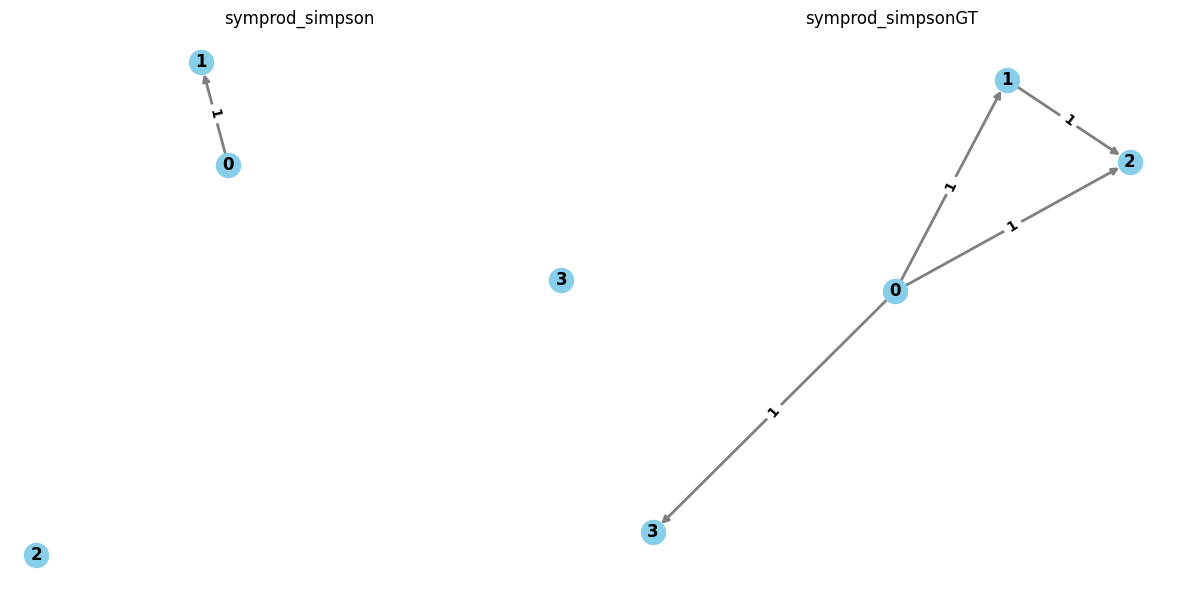

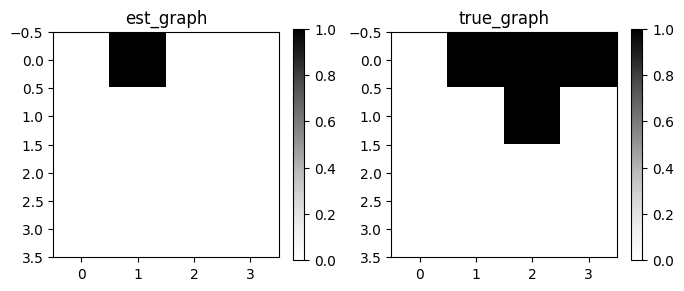

~~~~~ Tuned symprod_simpson WITH DISCRETIZATION ~~~~~
Working on the 60th level of discretization.
Working on the 50th level of discretization.
Working on the 40th level of discretization.
Working on the 30th level of discretization.
Working on the 20th level of discretization.
Working on the 10th level of discretization.
{'adjacency_f1': 0.6666666666666665, 'orientation_f1': 0.4444444444444445}


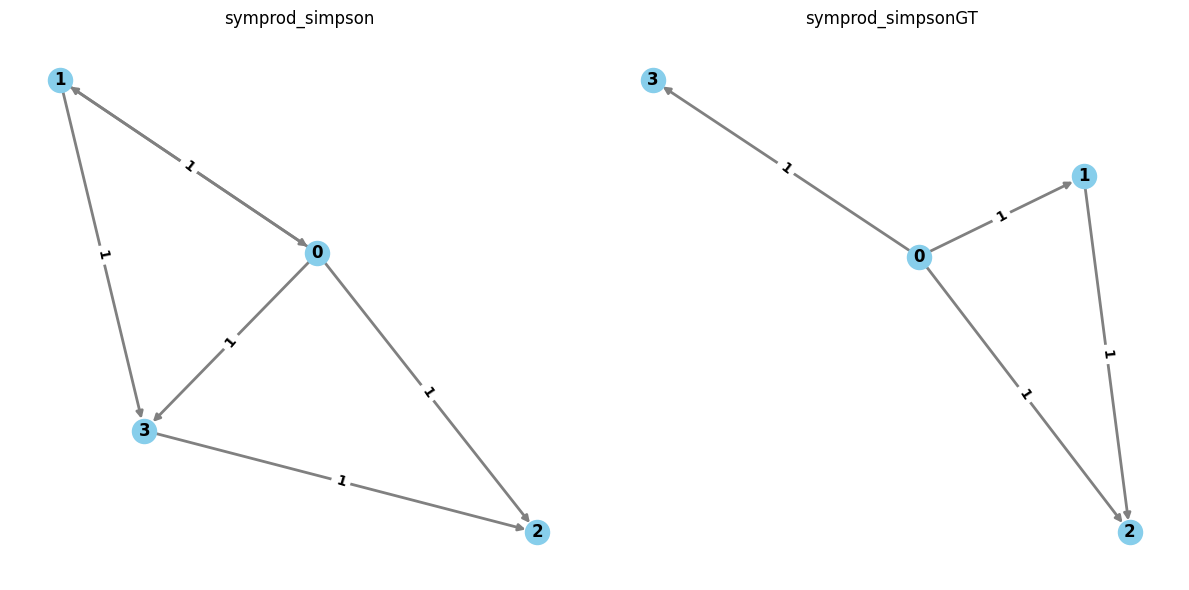

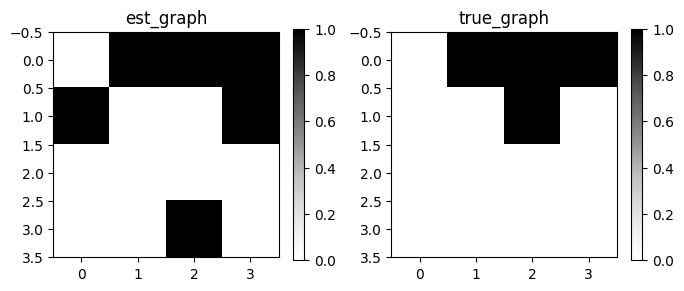

In [ ]:
# Without discretization
print("~~~~~ Tuned symprod_simpson WITHOUT DISCRETIZATION ~~~~~")
est_adj_symprod_simpson_gae_tuned, gt_symprod_simpson, f1_scores_symprod_simpson_gae_tuned, metrics_symprod_simpson_gae_tuned = gae_cs(dataset = symprod_simpson, apply_hartemink_discretization=False,  beta = 3, gamma = 0.10, hidden_dim=8, samples=2000, update_freq=200)

#With discretization
print("~~~~~ Tuned symprod_simpson WITH DISCRETIZATION ~~~~~")
hart_est_adj_symprod_simpson_gae_tuned, gt_symprod_simpson, hart_f1_scores_symprod_simpson_gae_tuned, hart_metrics_symprod_simpson_gae_tuned = gae_cs(dataset = symprod_simpson, apply_hartemink_discretization=True,  beta = 3, gamma = 0.10, hidden_dim=8, samples=2000, update_freq=200)


~~~~~ Tuned large_backdoor WITHOUT DISCRETIZATION ~~~~~
{'adjacency_f1': 1.0, 'orientation_f1': 0.4444444444444444}


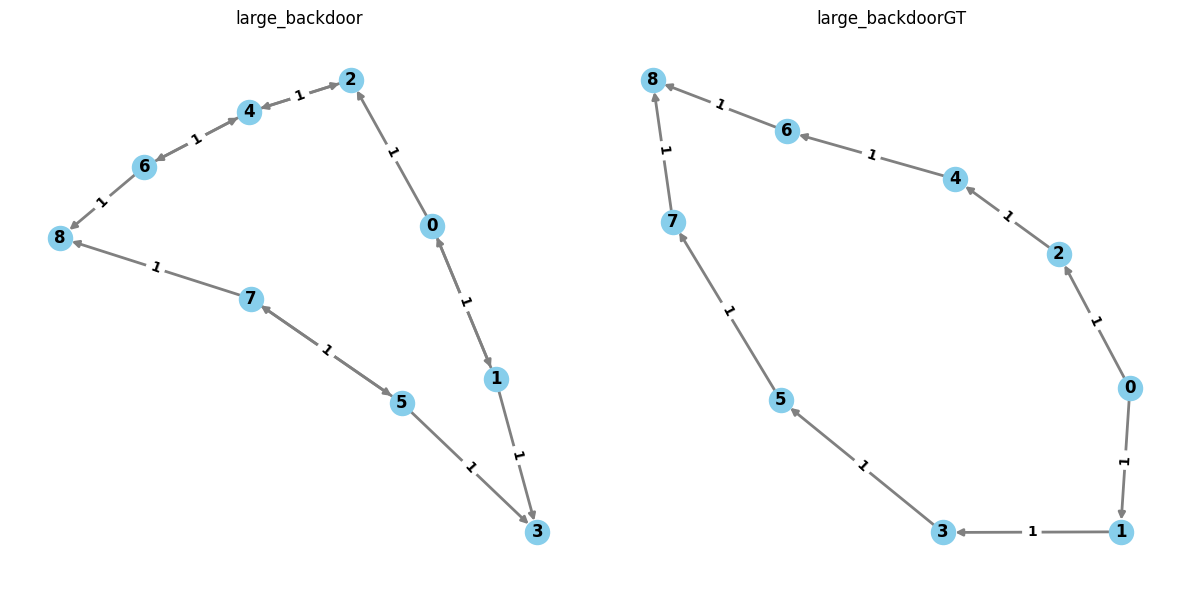

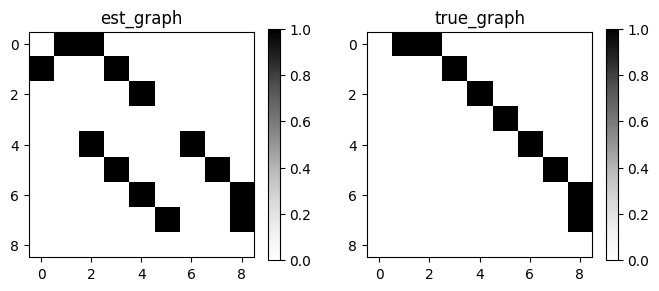

~~~~~ Tuned large_backdoor WITH DISCRETIZATION ~~~~~
Working on the 60th level of discretization.
Working on the 50th level of discretization.
Working on the 40th level of discretization.
Working on the 30th level of discretization.
Working on the 20th level of discretization.
Working on the 10th level of discretization.
{'adjacency_f1': 0.16666666666666666, 'orientation_f1': 0.16666666666666666}


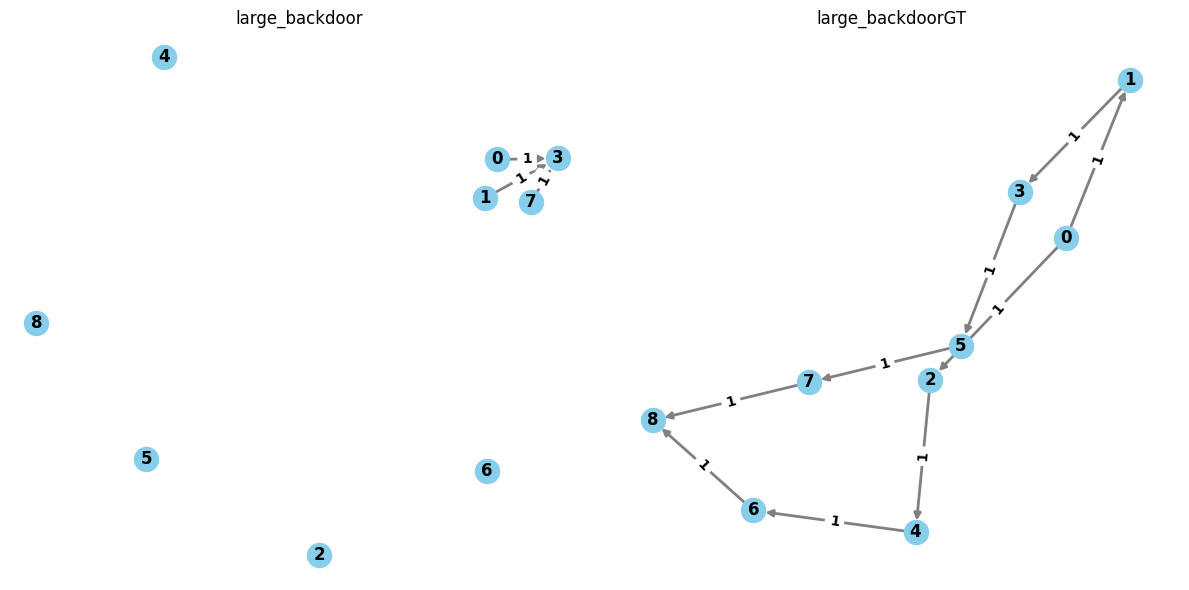

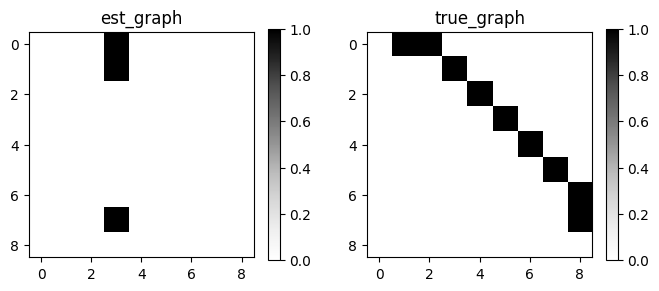

In [ ]:
# Without discretization
print("~~~~~ Tuned large_backdoor WITHOUT DISCRETIZATION ~~~~~")
est_adj_large_backdoor_gae_tuned, gt_large_backdoor, f1_scores_large_backdoor_gae_tuned, metrics_large_backdoor_gae_tuned = gae_cs(dataset = large_backdoor, apply_hartemink_discretization=False,  beta = 2, gamma = 0.25, hidden_dim=16, samples=2000, update_freq=200)

#With discretization
print("~~~~~ Tuned large_backdoor WITH DISCRETIZATION ~~~~~")
hart_est_adj_large_backdoor_gae_tuned, gt_large_backdoor, hart_f1_scores_large_backdoor_gae_tuned, hart_metrics_large_backdoor_gae_tuned = gae_cs(dataset = large_backdoor, apply_hartemink_discretization=True,  beta = 2, gamma = 0.25, hidden_dim=16, samples=2000, update_freq=200)


~~~~~ Tuned weak_arrows WITHOUT DISCRETIZATION ~~~~~
{'adjacency_f1': 0.689655172413793, 'orientation_f1': 0.1379310344827586}


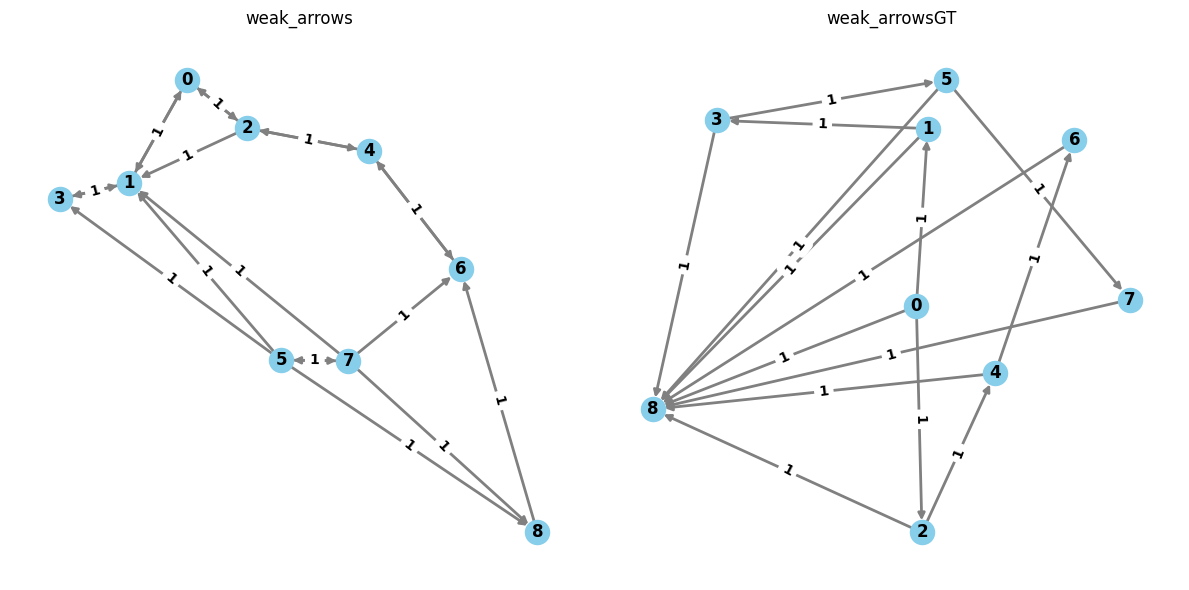

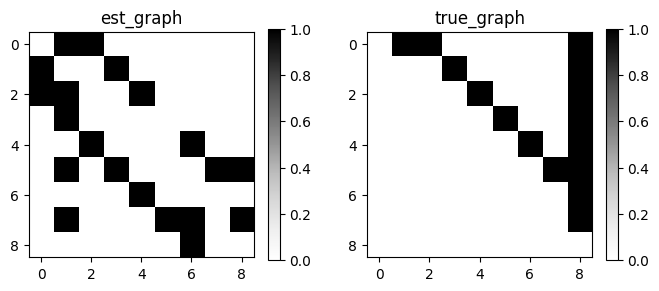

~~~~~ Tuned weak_arrows WITH DISCRETIZATION ~~~~~
Working on the 60th level of discretization.
Working on the 50th level of discretization.
Working on the 40th level of discretization.
Working on the 30th level of discretization.
Working on the 20th level of discretization.
Working on the 10th level of discretization.
{'adjacency_f1': 0.64, 'orientation_f1': 0.0}


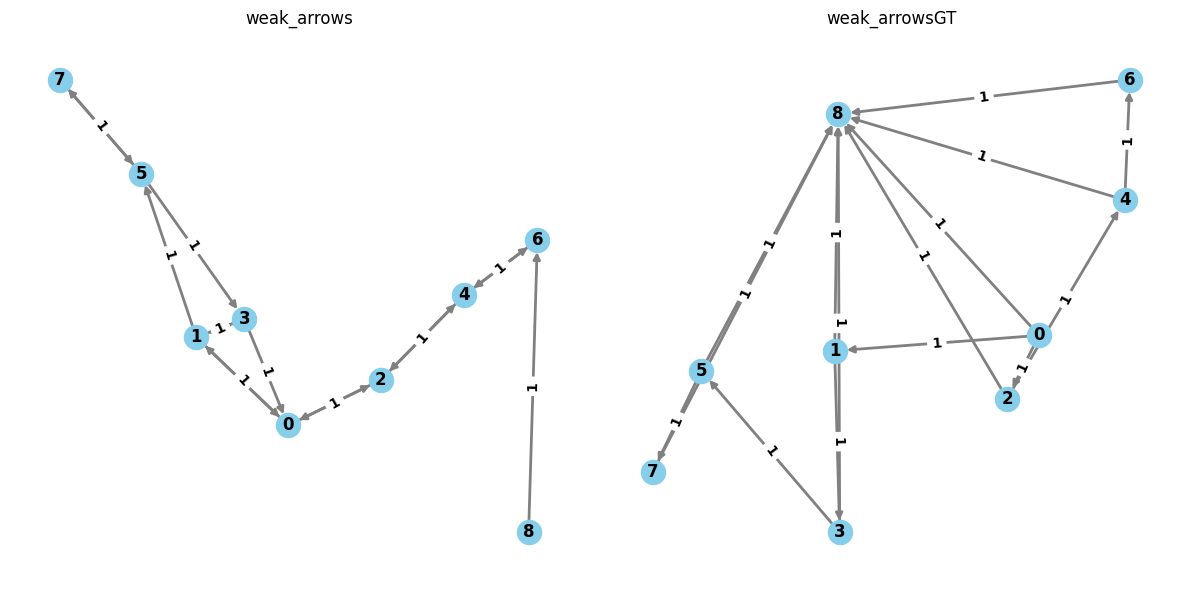

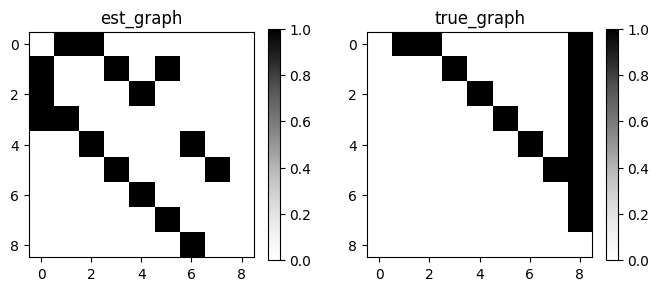

In [ ]:
# Without discretization
print("~~~~~ Tuned weak_arrows WITHOUT DISCRETIZATION ~~~~~")
est_adj_weak_arrows_gae_tuned, gt_weak_arrows, f1_scores_weak_arrows_gae_tuned, metrics_weak_arrows_gae_tuned = gae_cs(dataset = weak_arrows, apply_hartemink_discretization=False,  beta = 3, gamma = 0.45, hidden_dim=8, samples=2000, update_freq=200)

#With discretization
print("~~~~~ Tuned weak_arrows WITH DISCRETIZATION ~~~~~")
hart_est_adj_weak_arrows_gae_tuned, gt_weak_arrows, hart_f1_scores_weak_arrows_gae_tuned, hart_metrics_weak_arrows_gae_tuned = gae_cs(dataset = weak_arrows, apply_hartemink_discretization=True,  beta = 3, gamma = 0.45, hidden_dim=8, samples=2000, update_freq=200)


~~~~~ Sachs WITH DISCRETIZATION ~~~~~
Working on the 60th level of discretization.
Working on the 50th level of discretization.
Working on the 40th level of discretization.
Working on the 30th level of discretization.
Working on the 20th level of discretization.
Working on the 10th level of discretization.
{'adjacency_f1': 0.0, 'orientation_f1': 0.0}


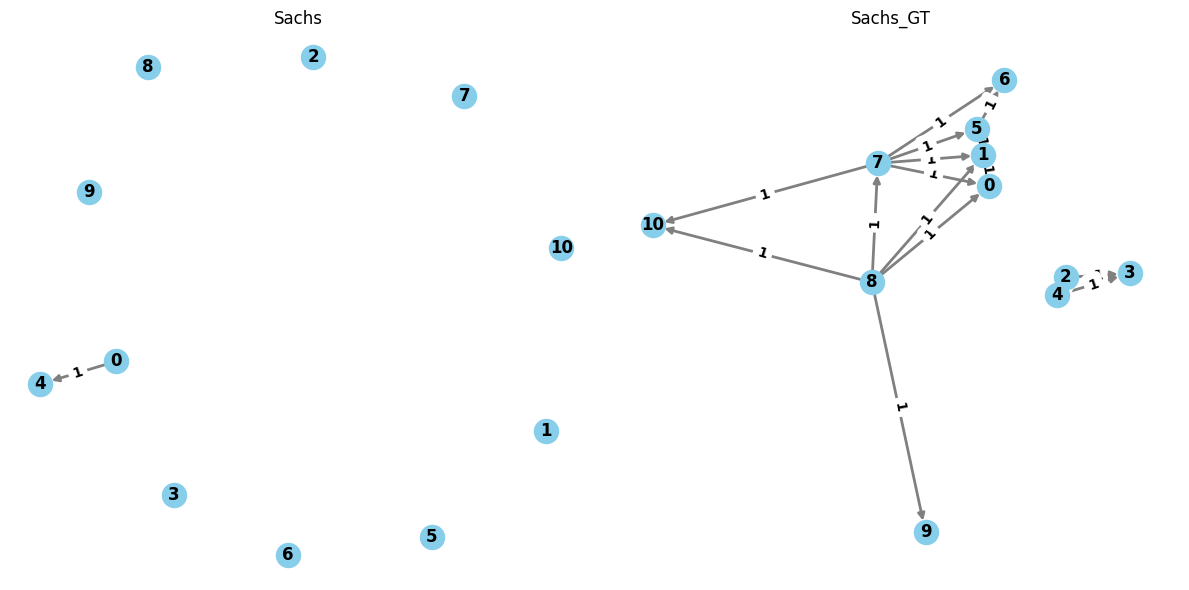

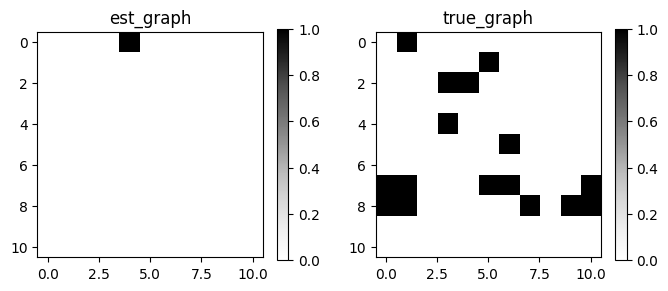

c:\Users\rubin\AppData\Local\Programs\Python\Python311\Lib\site-packages\castle\metrics\evaluation.py:226: RuntimeWarning: invalid value encountered in double_scalars
  F1 = 2*(recall*precision)/(recall+precision)





~~~~~ Sachs WITHOUT DISCRETIZATION ~~~~~
{'adjacency_f1': 0.5454545454545454, 'orientation_f1': 0.36363636363636365}


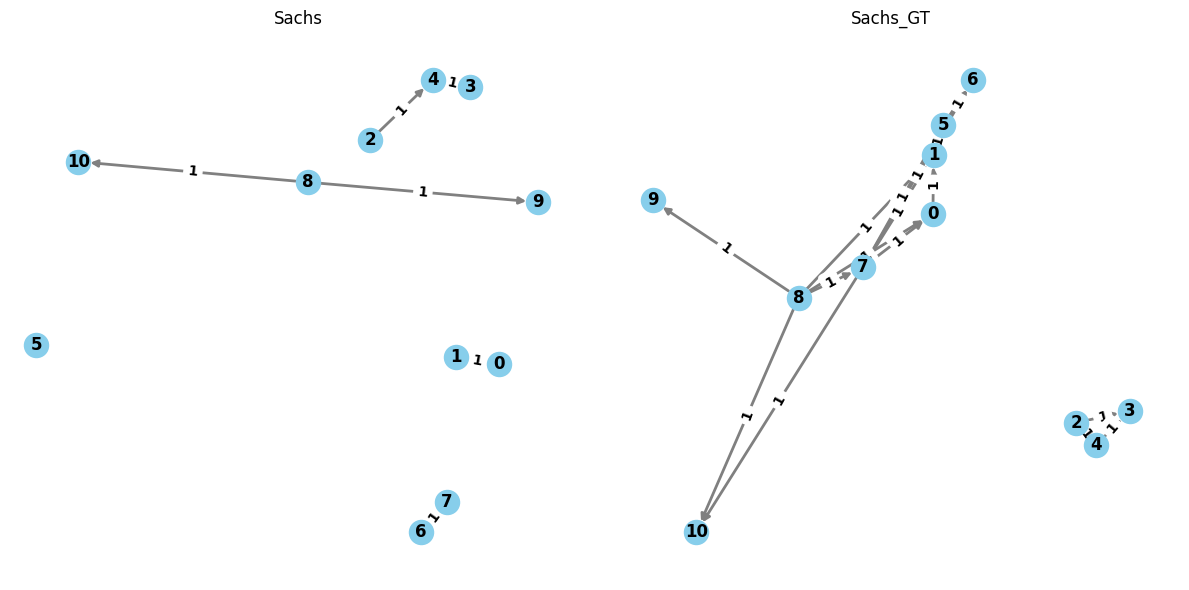

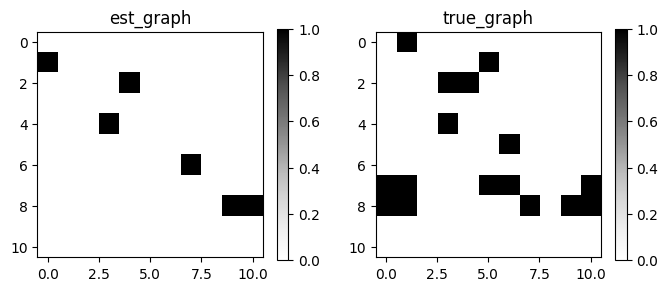

In [ ]:
# With discretization
print("~~~~~ Sachs WITH DISCRETIZATION ~~~~~")
hart_est_adj_sachs_gae_tuned, gt_sachs, hart_f1_scores_sachs_gae_tuned, hart_metrics_sachs_gae_tuned = gae_sachs(apply_hartemink_discretization=True, beta = 2, gamma = 0.25, hidden_dim = 16, update_freq = 200)

# Without discretization
print("\n\n\n~~~~~ Sachs WITHOUT DISCRETIZATION ~~~~~")
est_adj_sachs_gae_tuned, gt_sachs, f1_scores_sachs_gae_tuned, metrics_sachs_gae_tuned = gae_sachs(apply_hartemink_discretization=False, beta = 2, gamma = 0.25, hidden_dim = 16, update_freq = 200)

In [ ]:
f1_scores_all_gae_tuned = [f1_scores_nonlin_simpson_gae_tuned, f1_scores_symprod_simpson_gae_tuned, f1_scores_large_backdoor_gae_tuned, f1_scores_weak_arrows_gae_tuned ]
f1_scores_all_hartemink_gae_tuned = [hart_f1_scores_nonlin_simpson_gae_tuned, hart_f1_scores_symprod_simpson_gae_tuned, hart_f1_scores_large_backdoor_gae_tuned, hart_f1_scores_weak_arrows_gae_tuned ]

all_datasets = [i.__name__ for i in datasets] + ['sachs']

tuned_GAE_adjacency = [d['adjacency_f1'] for d in f1_scores_all_gae_tuned] + [f1_scores_sachs_gae_tuned['adjacency_f1']]
#print(GAE_adjacency)
tuned_GAE_adjacency_hart = [d['adjacency_f1'] for d in f1_scores_all_hartemink_gae_tuned] + [hart_f1_scores_sachs_gae_tuned['adjacency_f1']]

tuned_GAE_orientation = [d['orientation_f1'] for d in f1_scores_all_gae_tuned] + [f1_scores_sachs_gae_tuned['orientation_f1']]
tuned_GAE_orientation_hart = [d['orientation_f1'] for d in f1_scores_all_hartemink_gae_tuned] + [hart_f1_scores_sachs_gae_tuned['orientation_f1']]

# Define colors
colors = ['skyblue', 'lightgreen', 'orange', 'purple']
bar_width = 0.35
index = range(len(all_datasets))

# Plot sequence F1 scores
plt.figure(figsize=(12, 6))

plt.bar(index, tuned_GAE_adjacency, bar_width, label='Tuned GAE adj score', color=colors[0])
plt.bar([i + bar_width for i in index], tuned_GAE_orientation, bar_width, label='Tuned GAE or. score', color=colors[2])
plt.bar([i + 2*bar_width for i in index], GAE_adjacency, bar_width, label='Non-Tuned GAE adj score', color=colors[1])
plt.bar([i + 3*bar_width for i in index], GAE_orientation, bar_width, label='Non-Tuned GAE or. score', color=colors[3])

plt.xlabel('Datasets')
plt.ylabel('Adjacency/Orientation F1 Score')
plt.title('Tuned GAE vs Non Tuned GAE Adjacency and Orientation F1 Score Comparison for All Datasets')
plt.xticks([i + bar_width / 2 for i in index], all_datasets)
plt.legend()

plt.tight_layout()
plt.show()

# Plot unrolled F1 scores
plt.figure(figsize=(12, 6))

plt.bar(index, tuned_GAE_adjacency_hart, bar_width, label='Tuned GAE adj Hartemink', color=colors[0])
plt.bar([i + bar_width for i in index], tuned_GAE_orientation_hart, bar_width, label='Tuned GAE OR. Hartemink', color=colors[1])
plt.bar([i + 2*bar_width for i in index], GAE_adjacency_hart, bar_width, label='Non-Tuned GAE adj Hartemink', color=colors[1])
plt.bar([i + 3*bar_width for i in index], GAE_orientation_hart, bar_width, label='Non-Tuned GAE OR. Hartemink', color=colors[1])


plt.xlabel('Datasets')
plt.ylabel('Adjacency/Orientation F1 Score')
plt.title('Tuned GAE vs Non Tuned GAE with Hartemink Adjacency and Orientation F1 Score Comparison for All Datasets')
plt.xticks([i + bar_width / 2 for i in index], all_datasets)
plt.legend()

plt.tight_layout()
plt.show()

NameError: name 'f1_scores_weak_arrows_gae_tuned' is not defined

<h3>Fine-Tuning of DAG-GNN<h3>

<p>Not done yet</p>

In [ ]:
best_results_gnn = {}
best_results_gnn = gnn_tuning()

In [ ]:
for dataset_name, result in best_results_gnn.items():
    print(f"Best results for {dataset_name}:")
    print(f"  Best adj score: {result['best_adj_score']}")
    print("  Best parameters:")
    for param_name, param_value in result['best_params_adj'].items():
        print(f"    {param_name}: {param_value}")


for dataset_name, result in best_results_gnn.items():
    print(f"Best results for {dataset_name}:")
    print(f"  Best orientation score: {result['best_orientation_score']}")
    print("  Best parameters:")
    for param_name, param_value in result['best_params_or'].items():
        print(f"    {param_name}: {param_value}")

<h5>lingauss</h5>

In [ ]:
# With discretization
print("~~~~~ lingauss WITH DISCRETIZATION ~~~~~")
hart_est_adj_lingauss_gnn_tuned, gt_lingauss, hart_f1_scores_lingauss_gnn_tuned, hart_metrics_lingauss_gnn_tuned = dag_gnn_cs(dataset =lingauss, apply_hartemink_discretization=True, hidden_dim=16, eta=4, gamma=0.10)

# Without discretization
print("\n\n\n~~~~~ lingauss WITHOUT DISCRETIZATION ~~~~~")
est_adj_lingauss_gnn_tuned, gt_lingauss, f1_scores_lingauss_gnn_tuned, metrics_lingauss_gnn_tuned = dag_gnn_cs(dataset=lingauss, apply_hartemink_discretization=False, hidden_dim=16, eta=4, gamma=0.10)

<h5>linexp</h5>

In [ ]:
# With discretization
print("~~~~~ linexp WITH DISCRETIZATION ~~~~~")
hart_est_adj_linexp_gnn_tuned, gt_linexp, hart_f1_scores_linexp_gnn_tuned, hart_metrics_linexp_gnn_tuned = dag_gnn_cs(dataset = linexp, apply_hartemink_discretization=True, hidden_dim=16, eta=4, gamma=0.10)

# Without discretization
print("\n\n\n~~~~~ linexp WITHOUT DISCRETIZATION ~~~~~")
est_adj_linexp_gnn_tuned, gt_linexp, f1_scores_linexp_gnn_tuned, metrics_linexp_gnn_tuned = dag_gnn_cs(dataset=linexp, apply_hartemink_discretization=False, hidden_dim=16, eta=4, gamma=0.10)

<h5>nonlingauss</h5>

In [ ]:
# With discretization
print("~~~~~ nonlingauss WITH DISCRETIZATION ~~~~~")
hart_est_adj_nonlingauss_gnn_tuned, gt_nonlingauss, hart_f1_scores_nonlingauss_gnn_tuned, hart_metrics_nonlingauss_gnn_tuned = dag_gnn_cs(dataset = nonlingauss, apply_hartemink_discretization=True, hidden_dim=4, eta=4, gamma=0.10)

# Without discretization
print("\n\n\n~~~~~ nonlingauss WITHOUT DISCRETIZATION ~~~~~")
est_adj_nonlingauss_gnn_tuned, gt_nonlingauss, f1_scores_nonlingauss_gnn_tuned, metrics_nonlingauss_gnn_tuned = dag_gnn_cs(dataset=nonlingauss, apply_hartemink_discretization=False, hidden_dim=4, eta=4, gamma=0.10)

<h5>nonlin_simpson</h5>

In [ ]:
# With discretization
print("~~~~~ nonlin_simpson WITH DISCRETIZATION ~~~~~")
hart_est_adj_nonlin_simpson_gnn_tuned, gt_nonlin_simpson, hart_f1_scores_nonlin_simpson_gnn_tuned, hart_metrics_nonlin_simpson_gnn_tuned = dag_gnn_cs(dataset = nonlin_simpson, apply_hartemink_discretization=True, hidden_dim=8, eta=4, gamma=0.10)

# Without discretization
print("\n\n\n~~~~~ nonlin_simpson WITHOUT DISCRETIZATION ~~~~~")
est_adj_nonlin_simpson_gnn_tuned, gt_nonlin_simpson, f1_scores_nonlin_simpson_gnn_tuned, metrics_nonlin_simpson_gnn_tuned = dag_gnn_cs(dataset=nonlin_simpson, apply_hartemink_discretization=False, hidden_dim=8, eta=4, gamma=0.10)

<h5>symprod_simpson</h5>

In [ ]:
# With discretization
print("~~~~~ symprod_simpson WITH DISCRETIZATION ~~~~~")
hart_est_adj_symprod_simpson_gnn_tuned, gt_symprod_simpson, hart_f1_scores_symprod_simpson_gnn_tuned, hart_metrics_symprod_simpson_gnn_tuned = dag_gnn_cs(dataset = symprod_simpson, apply_hartemink_discretization=True, hidden_dim=64, eta=10, gamma=1)

# Without discretization
print("\n\n\n~~~~~ symprod_simpson WITHOUT DISCRETIZATION ~~~~~")
est_adj_symprod_simpson_gnn_tuned, gt_symprod_simpson, f1_scores_symprod_simpson_gnn_tuned, metrics_symprod_simpson_gnn_tuned = dag_gnn_cs(dataset=symprod_simpson, apply_hartemink_discretization=False, hidden_dim=64, eta=10, gamma=1)

<h5>large_backdoor</h5>

In [ ]:
# With discretization
print("~~~~~ large_backdoor WITH DISCRETIZATION ~~~~~")
hart_est_adj_large_backdoor_gnn_tuned, gt_large_backdoor, hart_f1_scores_large_backdoor_gnn_tuned, hart_metrics_large_backdoor_gnn_tuned = dag_gnn_cs(dataset = large_backdoor, apply_hartemink_discretization=True, hidden_dim=64, eta=10, gamma=1)

# Without discretization
print("\n\n\n~~~~~ large_backdoor WITHOUT DISCRETIZATION ~~~~~")
est_adj_large_backdoor_gnn_tuned, gt_large_backdoor, f1_scores_large_backdoor_gnn_tuned, metrics_large_backdoor_gnn_tuned = dag_gnn_cs(dataset=large_backdoor, apply_hartemink_discretization=False, hidden_dim=64, eta=10, gamma=1)

<h5>weak_arrow</h5>

In [ ]:
# With discretization
print("~~~~~ weak_arrows WITH DISCRETIZATION ~~~~~")
hart_est_adj_weak_arrows_gnn_tuned, gt_weak_arrows, hart_f1_scores_weak_arrows_gnn_tuned, hart_metrics_weak_arrows_gnn_tuned = dag_gnn_cs(dataset = weak_arrows, apply_hartemink_discretization=True, hidden_dim=16, eta=8, gamma=0.10)

# Without discretization
print("\n\n\n~~~~~ weak_arrows WITHOUT DISCRETIZATION ~~~~~")
est_adj_weak_arrows_gnn_tuned, gt_weak_arrows, f1_scores_weak_arrows_gnn_tuned, metrics_weak_arrows_gnn_tuned = dag_gnn_cs(dataset=weak_arrows, apply_hartemink_discretization=False, hidden_dim=16, eta=8, gamma=0.10)

<h5>sachs</h5>

In [ ]:
# With discretization
print("~~~~~ Sachs WITH DISCRETIZATION ~~~~~")
hart_est_adj_sachs_gnn_tuned, gt_sachs, hart_f1_scores_sachs_gnn_tuned, hart_metrics_sachs_gnn_tuned = dag_gnn_sachs(apply_hartemink_discretization=True, hidden_dim=16, eta=8, gamma=0.10)

# Without discretization
print("\n\n\n~~~~~ Sachs WITHOUT DISCRETIZATION ~~~~~")
est_adj_sachs_gnn_tuned, gt_sachs, f1_scores_sachs_gnn_tuned, metrics_sachs_gnn_tuned = dag_gnn_sachs(apply_hartemink_discretization=False, hidden_dim=16, eta=8, gamma=0.10)

In [ ]:
f1_scores_all_gnn_tuned = [f1_scores_lingauss_gnn_tuned, f1_scores_linexp_gnn_tuned, f1_scores_nonlingauss_gnn_tuned ,f1_scores_nonlin_simpson_gnn_tuned, f1_scores_symprod_simpson_gnn_tuned, f1_scores_large_backdoor_gnn_tuned, f1_scores_weak_arrows_gnn_tuned ]
f1_scores_all_hartemink_gnn_tuned = [hart_f1_scores_lingauss_gnn_tuned, hart_f1_scores_linexp_gnn_tuned, hart_f1_scores_nonlingauss_gnn_tuned ,hart_f1_scores_nonlin_simpson_gae_tuned, hart_f1_scores_symprod_simpson_gae_tuned, hart_f1_scores_large_backdoor_gae_tuned, hart_f1_scores_weak_arrows_gae_tuned ]

all_datasets = [i.__name__ for i in datasets] + ['sachs']

tuned_GNN_adjacency = [d['adjacency_f1'] for d in f1_scores_all_gnn_tuned] + [f1_scores_sachs_gnn_tuned['adjacency_f1']]
#print(GAE_adjacency)
tuned_GNN_adjacency_hart = [d['adjacency_f1'] for d in f1_scores_all_hartemink_gnn_tuned] + [hart_f1_scores_sachs_gnn_tuned['adjacency_f1']]

tuned_GNN_orientation = [d['orientation_f1'] for d in f1_scores_all_gnn_tuned] + [f1_scores_sachs_gnn_tuned['orientation_f1']]
tuned_GNN_orientation_hart = [d['orientation_f1'] for d in f1_scores_all_hartemink_gnn_tuned] + [hart_f1_scores_sachs_gnn_tuned['orientation_f1']]

# Define colors
colors = ['skyblue', 'lightgreen', 'orange', 'purple']
bar_width = 0.35
index = range(len(all_datasets))

# Plot sequence F1 scores
plt.figure(figsize=(12, 6))

plt.bar(index, tuned_GNN_adjacency, bar_width, label='Tuned GNN adj score', color=colors[0])
plt.bar([i + bar_width for i in index], tuned_GNN_orientation, bar_width, label='Tuned GNN or. score', color=colors[2])
plt.bar([i + 2*bar_width for i in index], DAG_GNN_adjacency, bar_width, label='Non-Tuned GNN adj score', color=colors[1])
plt.bar([i + 3*bar_width for i in index], DAG_GNN_orientation, bar_width, label='Non-Tuned GNN or. score', color=colors[3])

plt.xlabel('Datasets')
plt.ylabel('Adjacency/Orientation F1 Score')
plt.title('Tuned GNN vs Non Tuned GNN Adjacency and Orientation F1 Score Comparison for All Datasets')
plt.xticks([i + bar_width / 2 for i in index], all_datasets)
plt.legend()

plt.tight_layout()
plt.show()

# Plot unrolled F1 scores
plt.figure(figsize=(12, 6))

plt.bar(index, tuned_GNN_adjacency_hart, bar_width, label='Tuned GNN adj Hartemink', color=colors[0])
plt.bar([i + bar_width for i in index], tuned_GNN_orientation_hart, bar_width, label='Tuned GNN OR. Hartemink', color=colors[1])
plt.bar([i + 2*bar_width for i in index], DAG_GNN_adjacency_hart, bar_width, label='Non-Tuned GNN adj Hartemink', color=colors[1])
plt.bar([i + 3*bar_width for i in index], DAG_GNN_orientation_hart, bar_width, label='Non-Tuned GNN OR. Hartemink', color=colors[1])


plt.xlabel('Datasets')
plt.ylabel('Adjacency/Orientation F1 Score')
plt.title('Tuned GNN vs Non Tuned GNN with Hartemink Adjacency and Orientation F1 Score Comparison for All Datasets')
plt.xticks([i + bar_width / 2 for i in index], all_datasets)
plt.legend()

plt.tight_layout()
plt.show()

<p>Error analysis and will be done soon!</p>